                                          Name: Bharath Yelika
                                          Applicant ID: 001182137

# PROJECT : PRODUCT CLASSIFICATION

### Importing Required Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report 
import warnings
warnings.filterwarnings("ignore")

### Loading the Data

In [2]:
# loading the data
train_df = pd.read_json('/Users/bharathyb/Downloads/train.json', lines=True, encoding = 'utf-8-sig')
val_df = pd.read_json('/Users/bharathyb/Downloads/validation.json', lines=True, encoding = 'utf-8-sig')
test_df1 = pd.read_json('/Users/bharathyb/Downloads/task2_testset_with_labels.json', lines=True, 
                        encoding = 'utf-8-sig')
test_df2 = pd.read_json('/Users/bharathyb/Downloads/test_public.json', lines=True, encoding = 'utf-8-sig')
# printing the first 5 rows from the train_df 
train_df.head()

ID                                               Name  \
0   549                        Sterling Silver Angel Charm   
1  5664        HP Pavilion 23xi 58.40 cm (23�) IPS Monitor   
2  3307  East Carolina Pirates Ladies Personalized Bask...   
3  4609  Tekonsha 90195 P3 Electric Brake Control, 1-4 ...   
4  7822                  RN-XV WiFly Module - Wire Antenna   

                                         Description  \
0           This little angel charm is just heavenly   
1  Share photos, videos, and games with everyone ...   
2  Feel like a bona fide member of East Carolina ...   
3  Receive free shipping on this item. Enter coup...   
4  Description: The RN-XV module by Roving Networ...   

                                        CategoryText  \
0                                       All Products   
1                                            Product   
2  East Carolina Pirates > East Carolina Pirates ...   
3     Vehicles & Parts > Vehicle Parts & Accessories   
4  Home              ::                 Wireless ...   

                                                 URL  \
0  http://www.thecharmworks.com/product/CW-UA/Ste...   
1  http://store.hp.com/UKStore/Merch/Product.aspx...   
2  http://eastcarolina.teamfanshop.com/COLLEGE_Ea...   
3  http://www.anythingtruck.com/product/755-90195...   
4  http://www.karlssonrobotics.com/cart/rn-xv-wif...   

                            lvl1  \
0  64000000_Personal Accessories   
1             65000000_Computing   
2              67000000_Clothing   
3            77000000_Automotive   
4   78000000_Electrical Supplies   

                                              lvl2  \
0                    64010000_Personal Accessories   
1                   65010000_Computers/Video Games   
2                                67010000_Clothing   
3  77010000_Automotive Accessories and Maintenance   
4     78050000_Electronic Communication Components   

                                           lvl3  
0                            64010100_Jewellery  
1      65010700_Computer/Video Game Peripherals  
2                 67010800_Upper Body Wear/Tops  
3        77011200_Automotive Maintenance/Repair  
4  78050100_Electronic Communication Components

### Checking the datatype

In [3]:
# checking the datatype
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10012 entries, 0 to 10011
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10012 non-null  int64 
 1   Name          10012 non-null  object
 2   Description   10012 non-null  object
 3   CategoryText  10012 non-null  object
 4   URL           10012 non-null  object
 5   lvl1          10012 non-null  object
 6   lvl2          10012 non-null  object
 7   lvl3          10012 non-null  object
dtypes: int64(1), object(7)
memory usage: 625.9+ KB


### Checking the Unique Values in each level

In [518]:
# checking the unique value in each level
target_column_lvl1 = train_df['lvl1'].value_counts()
target_column_lvl2 = train_df['lvl2'].value_counts()
target_column_lvl3 = train_df['lvl3'].value_counts()
len(target_column_lvl1), len(target_column_lvl2), len(target_column_lvl3)

(37, 76, 281)

### Plotting UniqueValues of Level 1

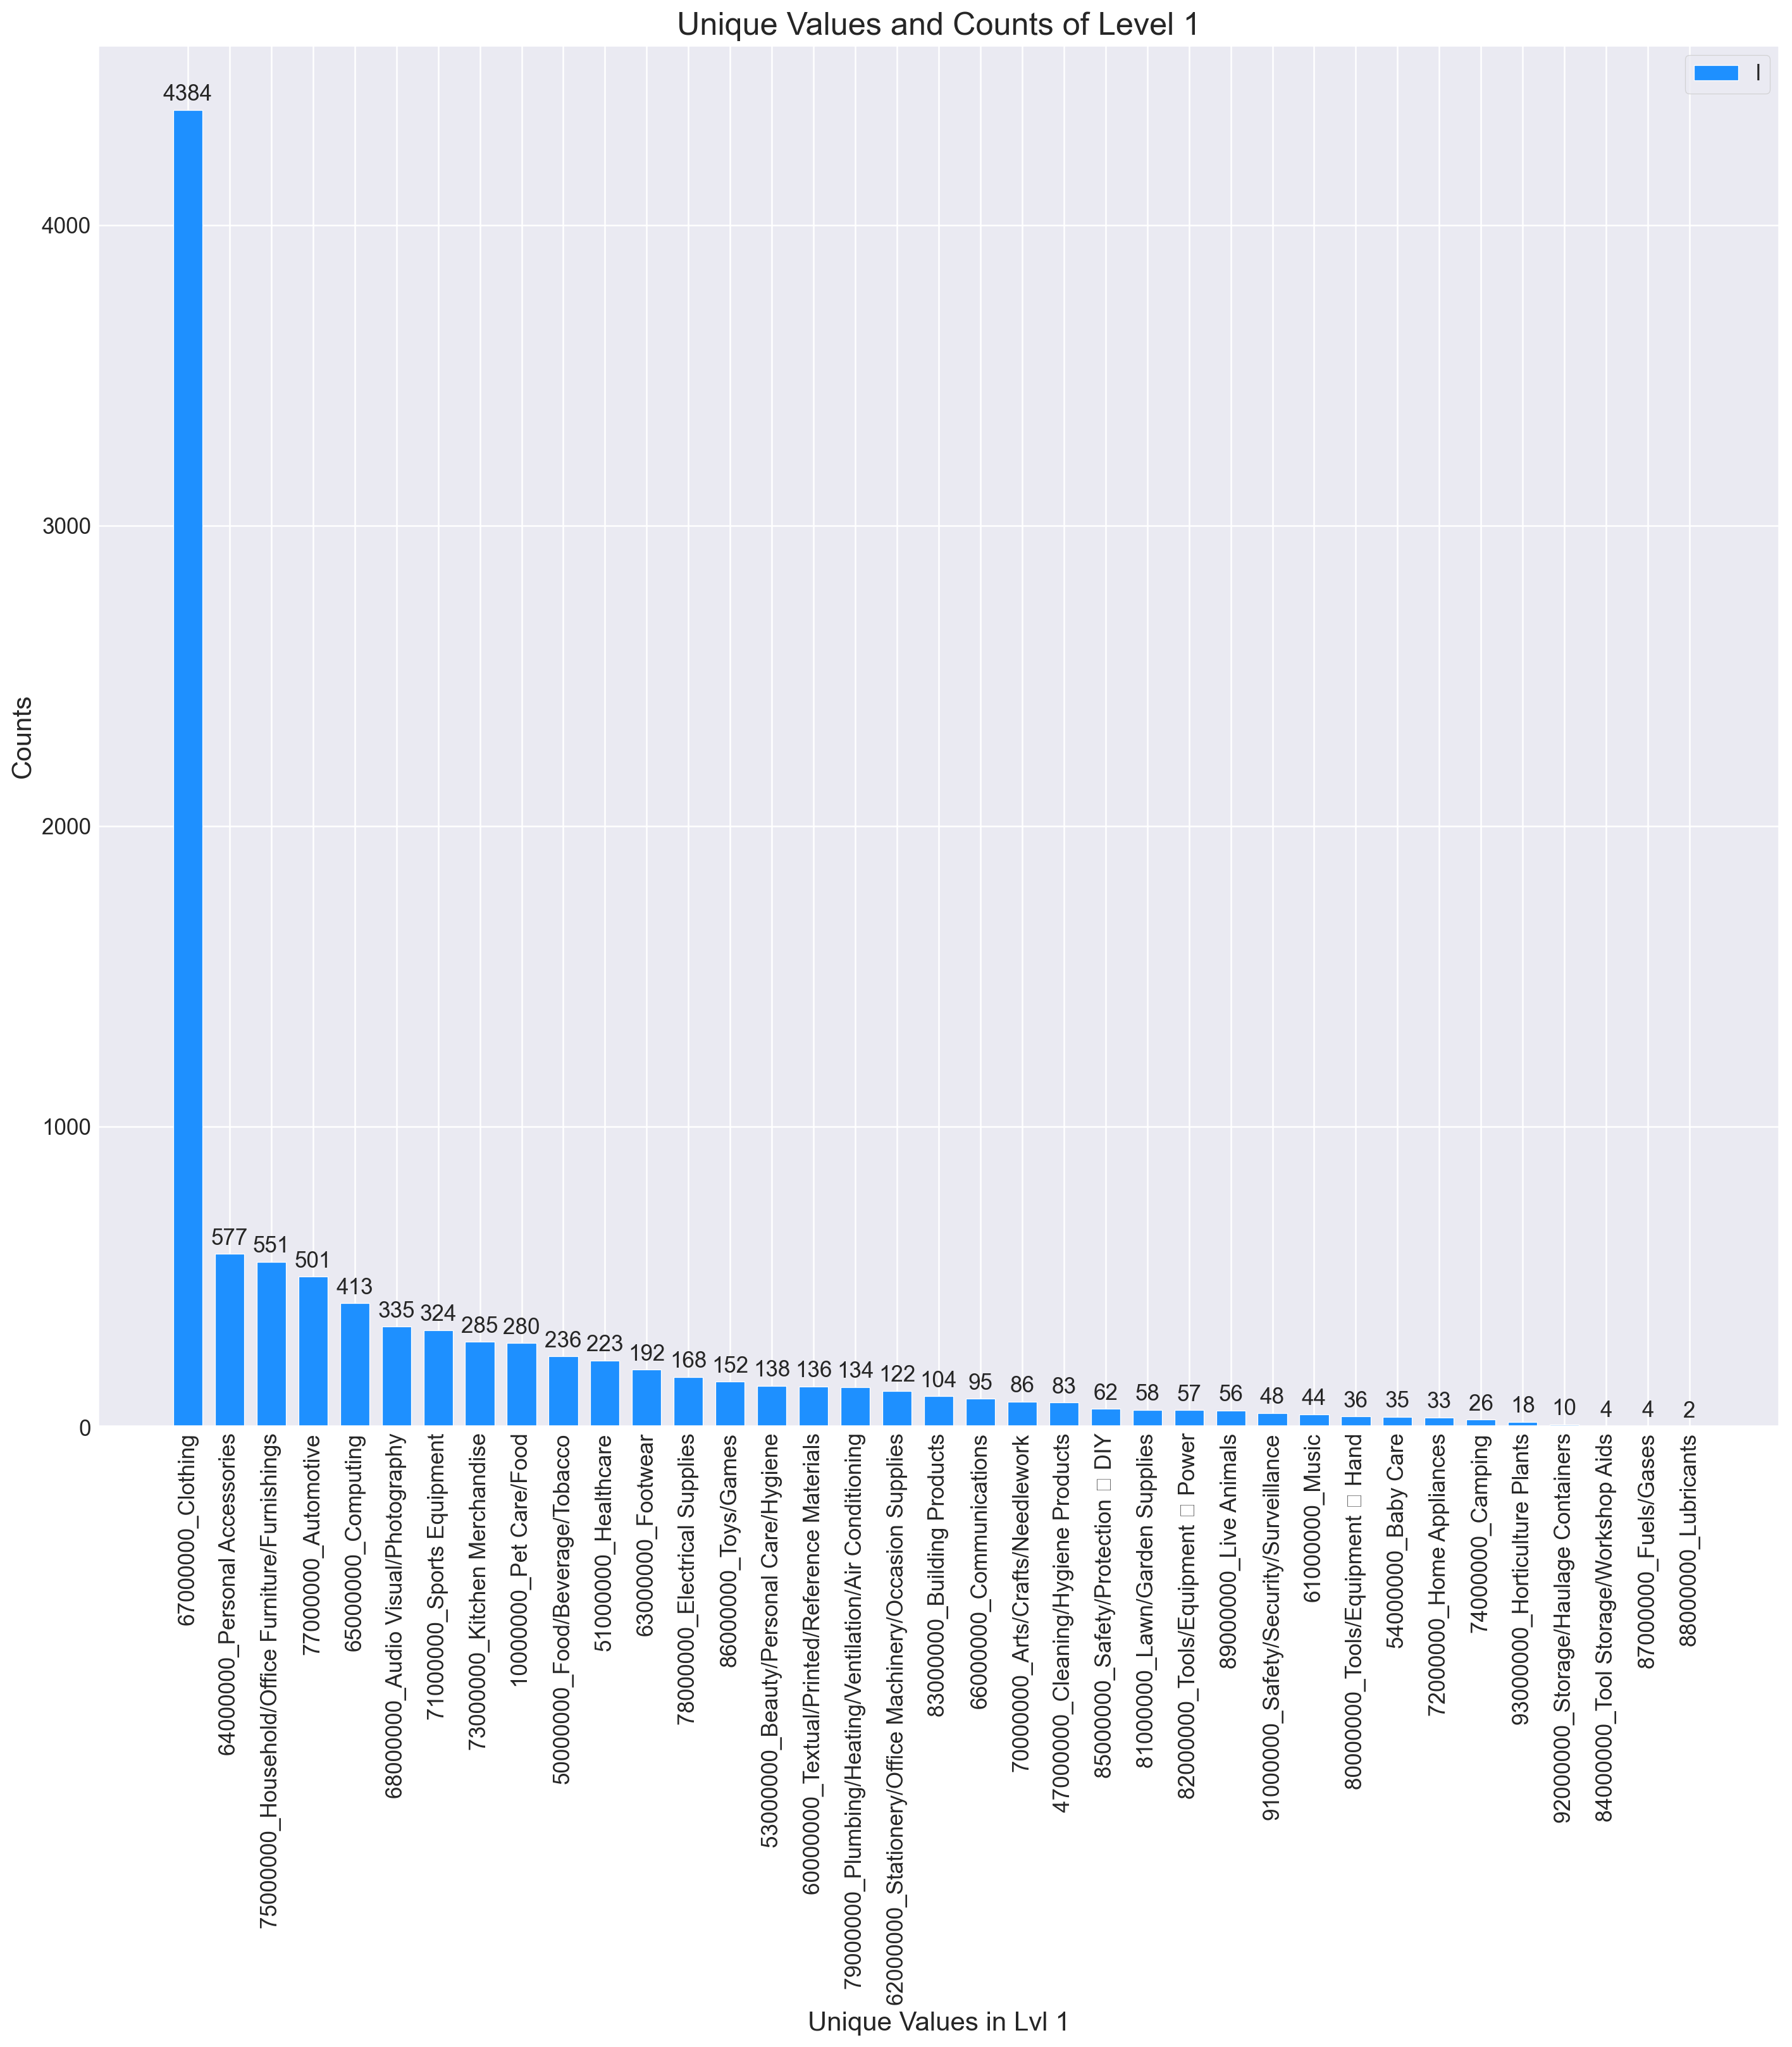

In [546]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

data = target_column_lvl1
names = list(data.keys())
values = list(data.values)

fig = plt.figure(figsize=(17, 15), dpi=180)
ax = fig.subplots()

x = np.arange(len(values)) # the label locations
width = 0.7 # the width of the bars

plt.xticks(rotation='vertical')

pps = ax.bar(x - width/2, values, width, tick_label= names,color = 'dodgerblue')
plt.xticks(rotation='vertical')
ax.set_ylabel('Counts')
ax.set_xlabel('Unique Values in Lvl 1')
ax.legend(labels= 'lvl1')
ax.set_title('Unique Values and Counts of Level 1')


for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()

### Checking the Null Values

<AxesSubplot:>

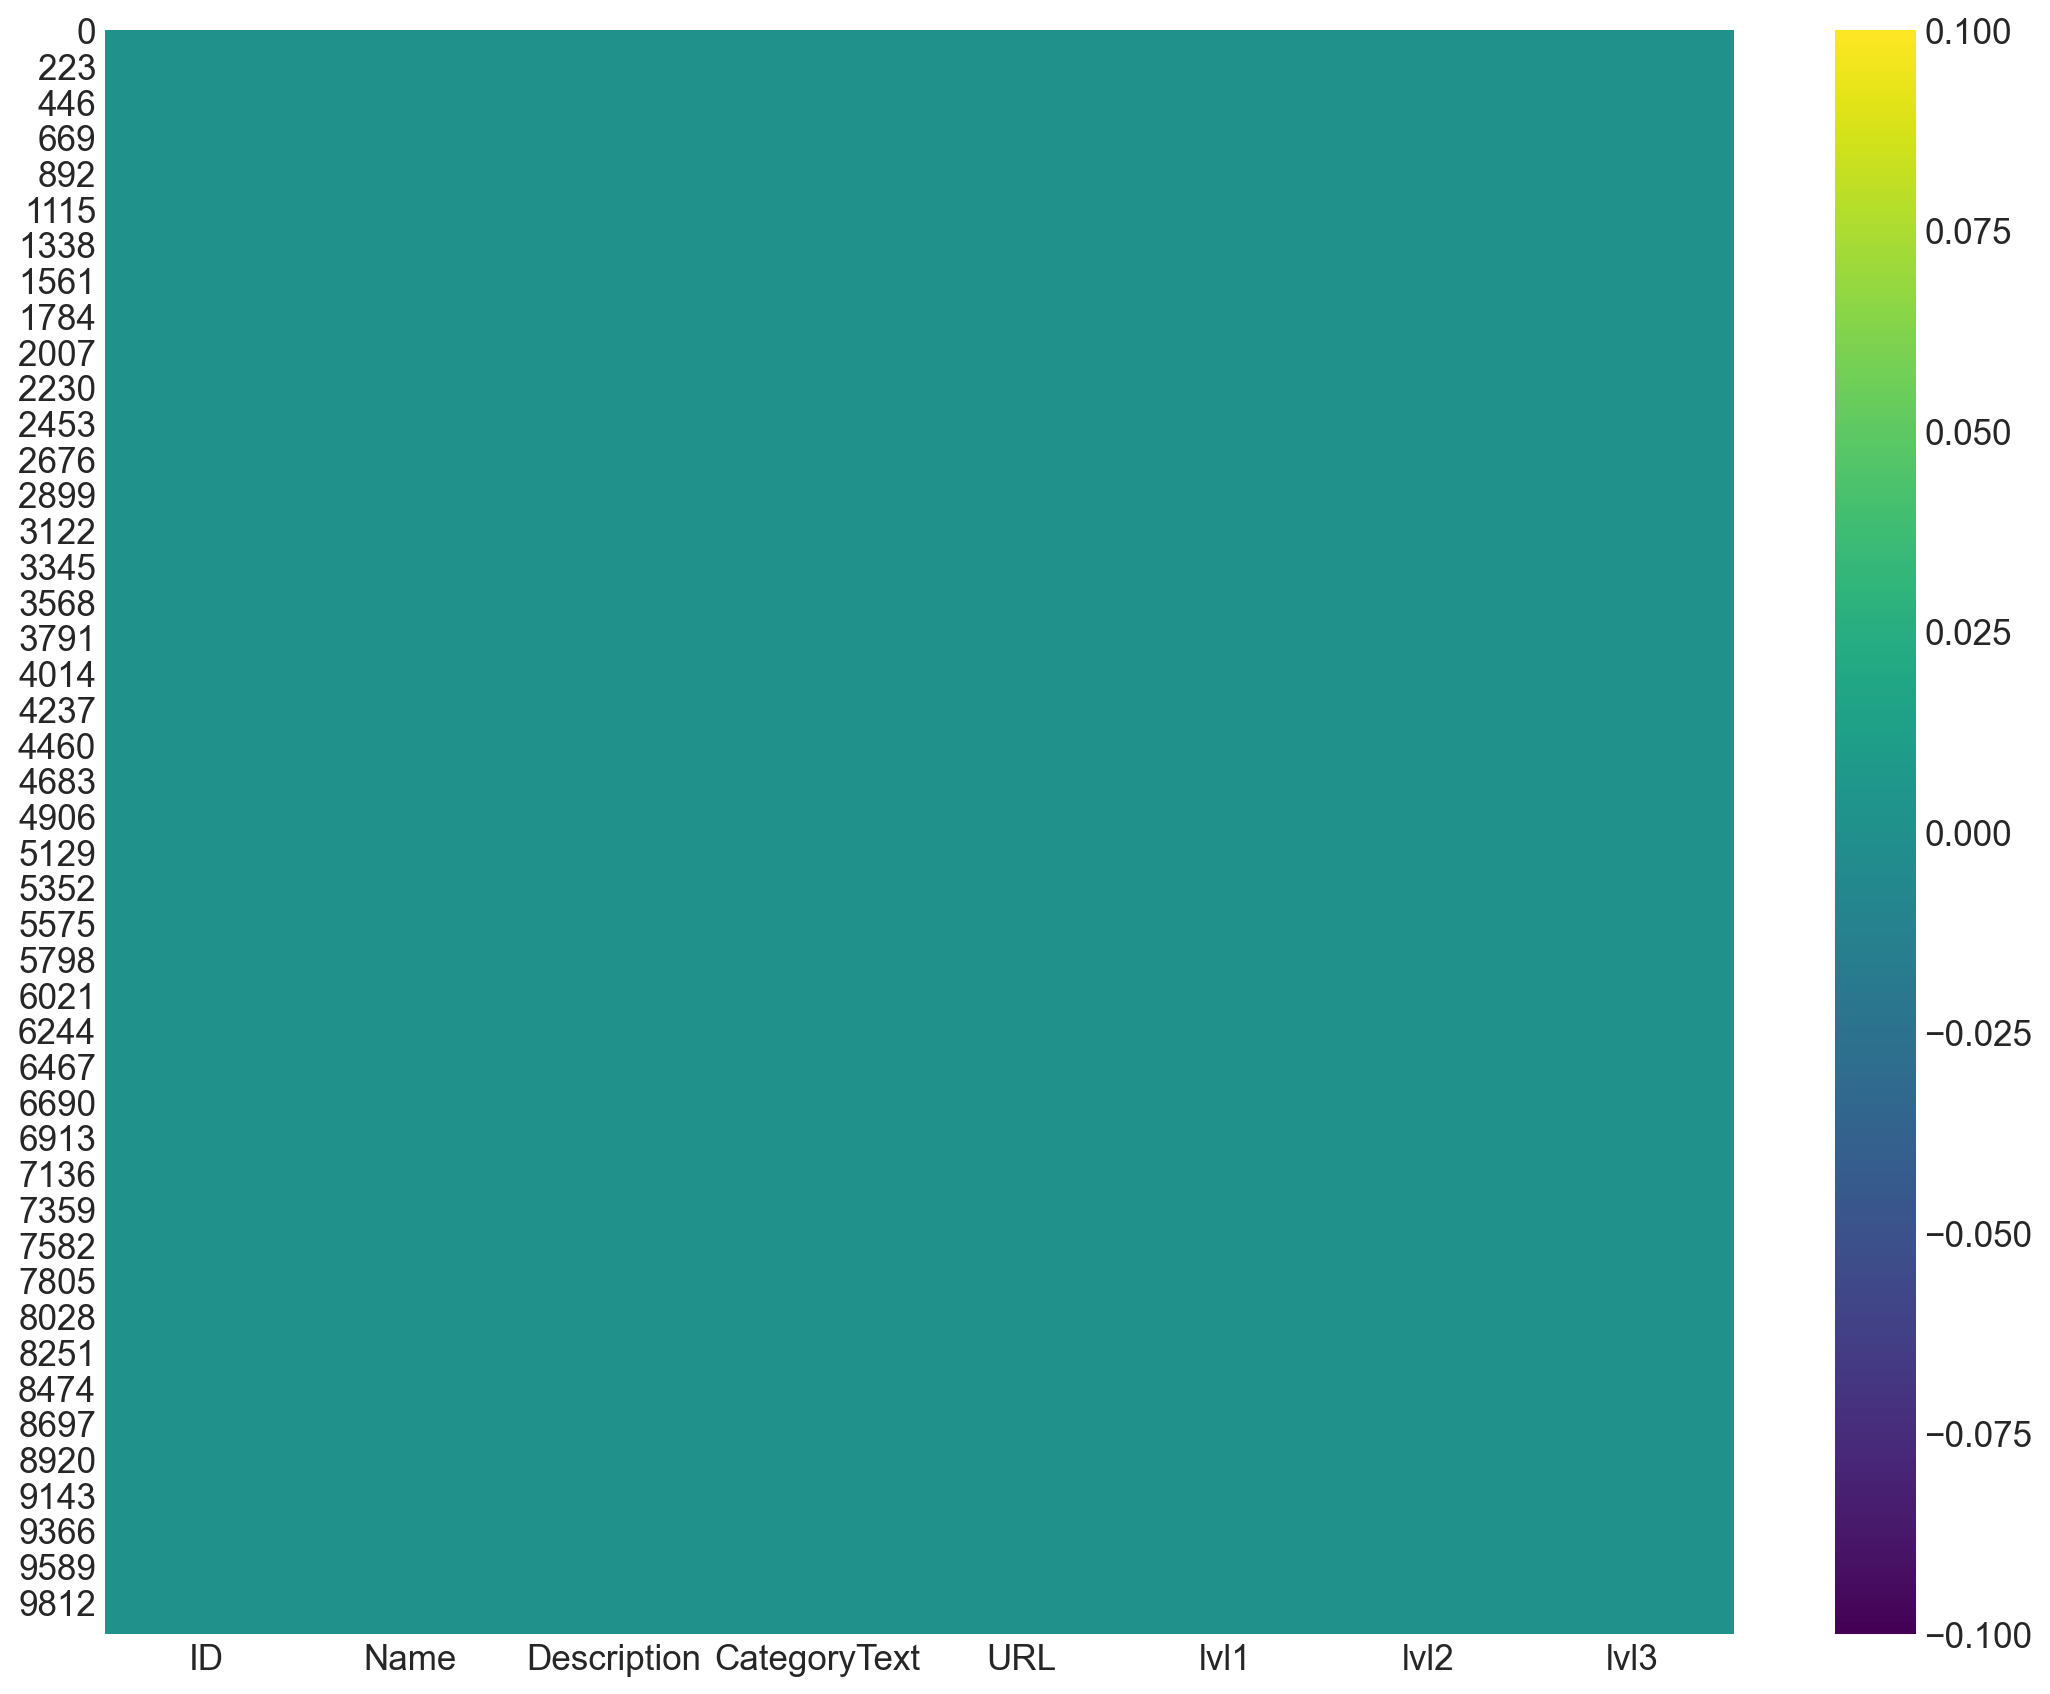

In [6]:
import seaborn as sns
fig = plt.figure(figsize=(13, 11), dpi=180)
sns.heatmap(train_df.isnull(), cmap = 'viridis')

### Installing the required packages

In [7]:
!pip install emoji
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bharathyb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bharathyb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocessing the Data

In [8]:
def preprocess_text(df, field):
    df[field] = df['Name'] + "." + df['Description']
    df.drop(labels = ['ID','Name', 'Description', 'CategoryText', 'URL'], axis = 1, inplace = True)
    if set(['lvl1','lvl2','lvl3']).issubset(df.columns):
        df = df[[field,'lvl1', 'lvl2','lvl3']]
    else: 
        df = df[[field]]

    
    # Removing Duplicates
    df.drop_duplicates(inplace = True)
    # Text cleaning
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ") 
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ") 
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    
    import emoji
    # Applying Lemmmatizer to remove tenses from texts.
    lemmatizer = WordNetLemmatizer()
    #shortcuts
    Context = re.sub(r"won\'t", "will not", str(df[field]))
    Context = re.sub(r"can\'t", "can not", Context)
    Context = re.sub('[^a-zA-Z0-9]',' ',Context)
    Context= re.sub(emoji.get_emoji_regexp(),"",Context)
    Context = [lemmatizer.lemmatize(word) for word in Context.split() if not word in set(stopwords.words('english'))]
    Context = ' '.join(Context)
    df.drop_duplicates(inplace = True)
    return df

cleaned_train_df = preprocess_text(train_df, "Context" )

### Cleaned Training Data

In [9]:
cleaned_train_df

Context  \
0      sterling silver angel charm this little angel ...   
1      hp pavilion   xi       cm (   ) ips monitor sh...   
2      east carolina pirates ladies personalized bask...   
3      tekonsha       p  electric brake control,     ...   
4      rn xv wifly module   wire antenna description ...   
...                                                  ...   
10007  mens washington capitals reebok striped scarf ...   
10008  new york yankees ladies stripe cami tank   nav...   
10009  mens uconn huskies navy blue arch t shirt cele...   
10010  sony ericsson xperia arc s lt  i product featu...   
10011  riviera   toe ring our riviera is a classy sap...   

                                lvl1  \
0      64000000_Personal Accessories   
1                 65000000_Computing   
2                  67000000_Clothing   
3                77000000_Automotive   
4       78000000_Electrical Supplies   
...                              ...   
10007              67000000_Clothing   
10008              67000000_Clothing   
10009              67000000_Clothing   
10010        66000000_Communications   
10011  64000000_Personal Accessories   

                                                  lvl2  \
0                        64010000_Personal Accessories   
1                       65010000_Computers/Video Games   
2                                    67010000_Clothing   
3      77010000_Automotive Accessories and Maintenance   
4         78050000_Electronic Communication Components   
...                                                ...   
10007                                67010000_Clothing   
10008                                67010000_Clothing   
10009                                67010000_Clothing   
10010                          66010000_Communications   
10011                    64010000_Personal Accessories   

                                                 lvl3  
0                                  64010100_Jewellery  
1            65010700_Computer/Video Game Peripherals  
2                       67010800_Upper Body Wear/Tops  
3              77011200_Automotive Maintenance/Repair  
4        78050100_Electronic Communication Components  
...                                               ...  
10007                   67010100_Clothing Accessories  
10008                   67010800_Upper Body Wear/Tops  
10009                   67010800_Upper Body Wear/Tops  
10010  66010300_Mobile Communication Devices/Services  
10011                              64010100_Jewellery  

[9833 rows x 4 columns]

### Checking the duplicates in Trained data

In [10]:
cleaned_train_df.duplicated().sum()

0

### Calculating the length of each levels in Training Data

In [11]:
len(cleaned_train_df.Context), len(cleaned_train_df.lvl1), 
len(cleaned_train_df.lvl2), len(cleaned_train_df.lvl3), cleaned_train_df.shape

(9833, 9833, (9833, 4))

### Checking the shape of Training Data

In [12]:
train_df.shape

(10012, 4)

### Downloading the punkt Package

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/bharathyb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Splitting the training data to input and target columns

In [14]:
X_train = cleaned_train_df['Context']
Y_train = cleaned_train_df[['lvl1', 'lvl2','lvl3']]

### Cleaned validation data and splitting the validation data to input and target columns

In [15]:
cleaned_valid_df = preprocess_text(val_df, "Context" )
X_valid = cleaned_valid_df['Context']
Y_valid = cleaned_valid_df[['lvl1', 'lvl2','lvl3']]

### Cleaned Test data and printing them 

In [16]:
cleaned_test_df1 = preprocess_text(test_df1, "Context" )
cleaned_test_df1.head()

Context  \
0  alpinestars winter tech performance top produc...   
1       ford f     ranger xlt short bed         c...   
2  toronto blue jays for bare feet argyle crew so...   
3  the vranum stool the vranum stool is made from...   
4  arkansas razorbacks women's fantasy fan tail s...   

                                              lvl1  \
0                                67000000_Clothing   
1                              77000000_Automotive   
2                                67000000_Clothing   
3  75000000_Household/Office Furniture/Furnishings   
4                                67000000_Clothing   

                                  lvl2                               lvl3  
0                    67010000_Clothing      67010800_Upper Body Wear/Tops  
1        77030000_Cars and Motorcycles                      77030100_Cars  
2                    67010000_Clothing                 67010700_Underwear  
3  75010000_Household/Office Furniture  75010200_Household/Office Seating  
4                    67010000_Clothing      67010100_Clothing Accessories

### Checking the duplicates for cleaned test data

In [17]:
cleaned_test_df1.duplicated().sum()

0

### Splitting the test data to input and target columns

In [18]:
X_test_df1 = cleaned_test_df1['Context']
Y_test_df1 = cleaned_test_df1[['lvl1', 'lvl2','lvl3']]
cleaned_test_df1.duplicated().sum()

0

### Cleaned public test data which has only input - finally used for predicting the traget columns

In [19]:
cleaned_test_df2 = preprocess_text(test_df2, "Context" )
cleaned_test_df2

Context
0     alpinestars winter tech performance top produc...
1          ford f     ranger xlt short bed         c...
2     toronto blue jays for bare feet argyle crew so...
3     the vranum stool the vranum stool is made from...
4     arkansas razorbacks women's fantasy fan tail s...
...                                                 ...
3102  oklahoma sooners activo cooler take your soone...
3103  ageless ageless is a scientifically advanced a...
3104  original retro brand duquesne dukes womens gre...
3105  st louis cardinals silver plated mens cufflink...
3106  lumisource spyra bar table the spyra bar table...

[3102 rows x 1 columns]

###  Checking the duplicates for cleaned public test data


In [20]:
cleaned_test_df2.duplicated().sum()

0

In [21]:
X_test_df2 = cleaned_test_df2['Context']

### Converting text to weights using TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
xtrain = tfidf2.fit_transform(X_train)
xvalid = tfidf2.transform(X_valid)
xtestdf1 = tfidf2.transform(X_test_df1)
xtestdf2 = tfidf2.transform(X_test_df2)

### Checking the converted weights

In [23]:
xtrain, xvalid, xtestdf1, xtestdf2

(<9833x30812 sparse matrix of type '<class 'numpy.float64'>'
 	with 478976 stored elements in Compressed Sparse Row format>,
 <2977x30812 sparse matrix of type '<class 'numpy.float64'>'
 	with 142860 stored elements in Compressed Sparse Row format>,
 <3102x30812 sparse matrix of type '<class 'numpy.float64'>'
 	with 191595 stored elements in Compressed Sparse Row format>,
 <3102x30812 sparse matrix of type '<class 'numpy.float64'>'
 	with 191595 stored elements in Compressed Sparse Row format>)

### Importing the base model MultiOutputClassifier

In [24]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

### Ensembling Random Forest Classifier with default parameters into Multi Output Classifier

In [521]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model0 = MultiOutputClassifier(estimator = rf)
rfm_model = model0.fit(xtrain, Y_train)
print("Train_Score = ", rfm_model.score(xtrain, Y_train),"Valid_Score = ",rfm_model.score(xvalid, Y_valid),
      "Test_Score = ", rfm_model.score(xtestdf1, Y_test_df1))

Train_Score =  0.9989830163734363 Valid_Score =  0.6291568693315418 Test_Score =  0.5609284332688588


### Hyperparameter Tuning for Random Forest Classifier

In [25]:
Valid_Score_RF = []
for i in range(5,100,10):
    clf = RandomForestClassifier(n_estimators = i, max_features= 'sqrt', random_state = 0)
    model1 = MultiOutputClassifier(estimator=clf)
    clf_rfc_1 = model1.fit(xtrain, Y_train)
    Valid_Score_RF.append(clf_rfc_1.score(xvalid, Y_valid))
    print("No of Estimators =", i, "Train_Score = ",clf_rfc_1.score(xtrain, Y_train),
          "Valid_Score = ", clf_rfc_1.score(xvalid, Y_valid))


No of Estimators = 5 Train_Score =  0.9508796908369775 Valid_Score =  0.5021834061135371
No of Estimators = 15 Train_Score =  0.9962371605817146 Valid_Score =  0.5723883103795767
No of Estimators = 25 Train_Score =  0.9980677311095292 Valid_Score =  0.5979173664763184
No of Estimators = 35 Train_Score =  0.9984745245601546 Valid_Score =  0.5999328182734296
No of Estimators = 45 Train_Score =  0.9986779212854673 Valid_Score =  0.6053073563990594
No of Estimators = 55 Train_Score =  0.9988813180107801 Valid_Score =  0.611353711790393
No of Estimators = 65 Train_Score =  0.9988813180107801 Valid_Score =  0.6116896204232449
No of Estimators = 75 Train_Score =  0.9989830163734363 Valid_Score =  0.6143768894860598
No of Estimators = 85 Train_Score =  0.9989830163734363 Valid_Score =  0.6140409808532079
No of Estimators = 95 Train_Score =  0.9989830163734363 Valid_Score =  0.6194155189788377


### Printing the Validation Scores for Random Forest Classifier

In [542]:
Valid_Score_RF1 = []
for i in Valid_Score_RF:
    Valid_Score_RF1.append(round(i * 100, 2))
    
Valid_Score_RF1

[50.22, 57.24, 59.79, 59.99, 60.53, 61.14, 61.17, 61.44, 61.4, 61.94]

###  Plotting the Validation Scores for Random Forest Classifier

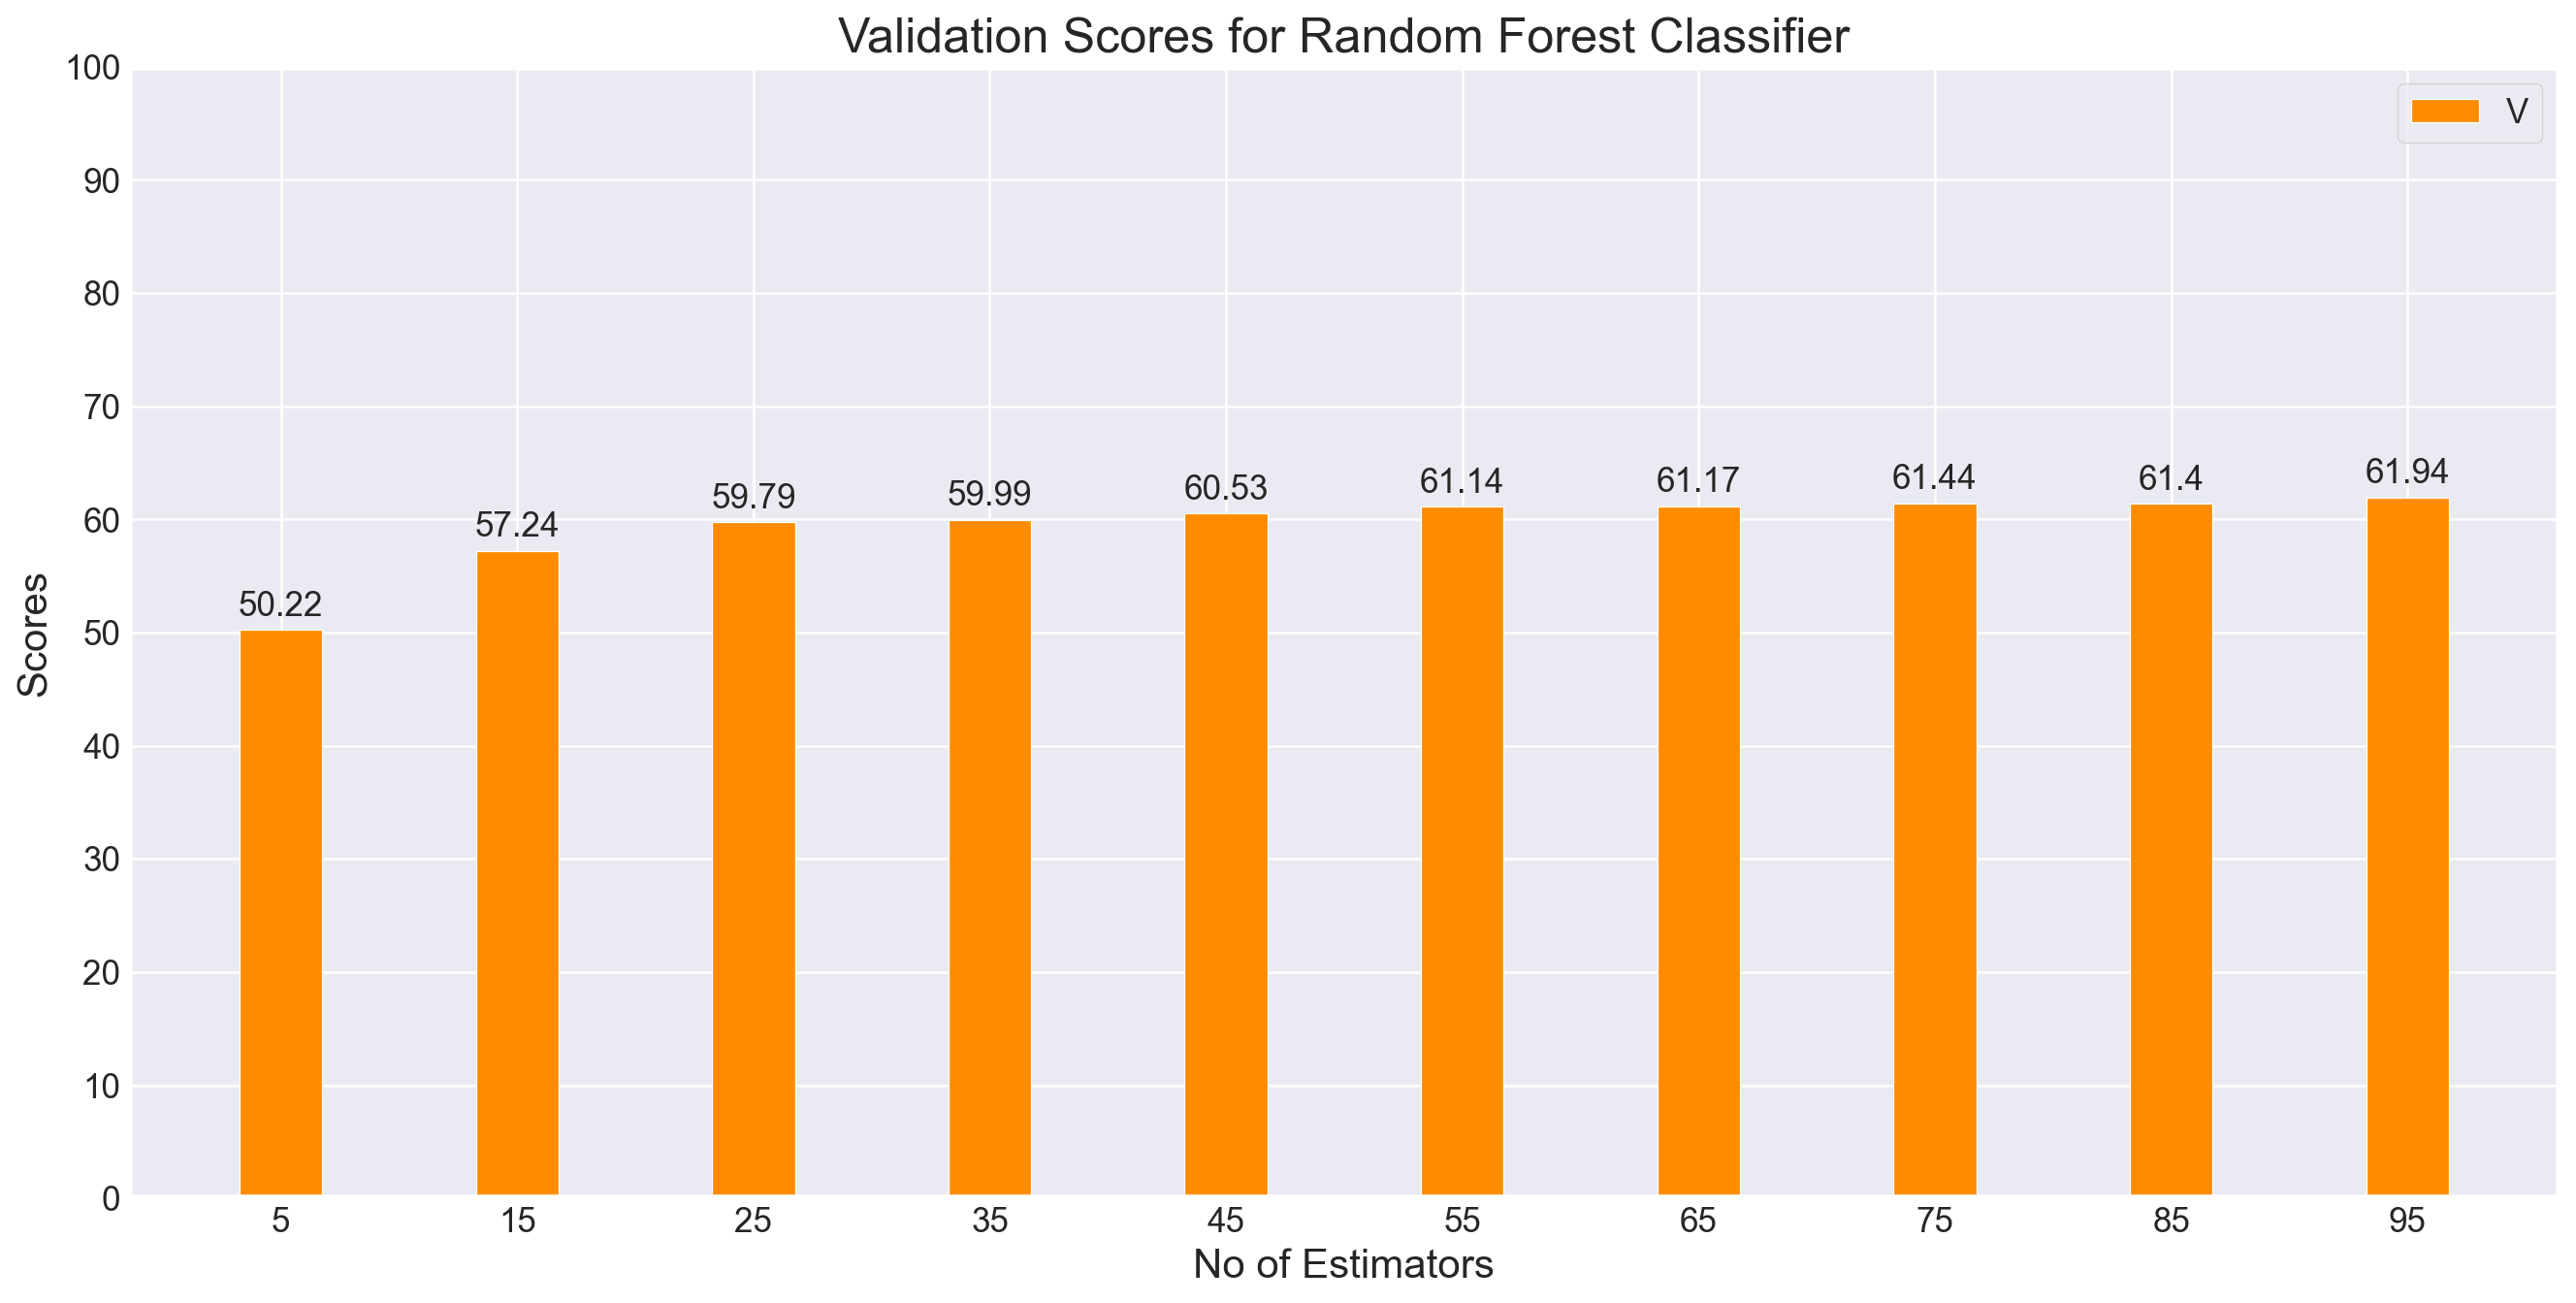

In [27]:
import matplotlib.pyplot as plt
import numpy as np

x = range(5,100,10)
y = Valid_Score_RF1

fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.subplots()

xx = np.arange(len(Valid_Score_RF1)) # the label locations
width = 0.35 # the width of the bars

#plt.xticks(rotation='vertical')

pps = ax.bar(xx - width/2, y, width, tick_label= x,color = 'darkorange')
#plt.xticks(rotation='vertical')
ax.set_ylabel('Scores')
ax.set_xlabel('No of Estimators')
ax.legend(labels= 'Validation Scores')
ax.set_title('Validation Scores for Random Forest Classifier')
score_label = np.arange(0, 110, 10)
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()


### Finalising the best parameter in Random Forest Classifier

In [103]:
clf1 = RandomForestClassifier(n_estimators = 95, max_features= 'sqrt', random_state = 0)
model1_clf = MultiOutputClassifier(estimator=clf1)
clf_rfc_11 = model1_clf.fit(xtrain, Y_train)
print("Train_Score = ",clf_rfc_11.score(xtrain, Y_train),
     "Valid_Score = ", clf_rfc_11.score(xvalid, Y_valid), 
     "Test_Score = ",clf_rfc_11.score(xtestdf1, Y_test_df1))

Train_Score =  0.9989830163734363 Valid_Score =  0.6194155189788377 Test_Score =  0.5480335267569311


###  Test Score of finalised parameter in Random Forest Classifier

In [104]:
test_df1_score_rf = clf_rfc_11.score(xtestdf1, Y_test_df1)
print(test_df1_score_rf)

0.5480335267569311


### Predicting the public test data using  Random Forest Classifier

In [105]:
test_df2_predict_rf = clf_rfc_11.predict(xtestdf2)
print(test_df2_predict_rf)

[['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['77000000_Automotive' '77010000_Automotive Accessories and Maintenance'
  '77011200_Automotive Maintenance/Repair']
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ...
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories']
 ['67000000_Clothing' '67010000_Clothing'
  '75010300_Household/Office Tables/Desks']]


### Actual Target columns of each level

In [239]:
actual_lvl1_rf = Y_test_df1.iloc[:,0].to_numpy()
actual_lvl2_rf = Y_test_df1.iloc[:,1].to_numpy()
actual_lvl3_rf = Y_test_df1.iloc[:,2].to_numpy()

###  Predicted Target columns of each level

In [240]:
predicted_lvl1_rf = test_df2_predict_rf[:,0]
predicted_lvl2_rf = test_df2_predict_rf[:,1]
predicted_lvl3_rf = test_df2_predict_rf[:,2]

### Calculating the Level 1 Classification Report of Random Forest Classifier 

In [241]:
print(classification_report(actual_lvl1_rf, predicted_lvl1_rf))

                                                        precision    recall  f1-score   support

                                10000000_Pet Care/Food       0.72      0.56      0.63        88
                    47000000_Cleaning/Hygiene Products       0.67      0.22      0.33        27
                        50000000_Food/Beverage/Tobacco       0.81      0.53      0.64        80
                                   51000000_Healthcare       0.69      0.54      0.61        70
                 53000000_Beauty/Personal Care/Hygiene       0.74      0.63      0.68        41
                                    54000000_Baby Care       0.00      0.00      0.00         9
          60000000_Textual/Printed/Reference Materials       0.77      0.72      0.74        50
                                        61000000_Music       1.00      0.41      0.58        22
62000000_Stationery/Office Machinery/Occasion Supplies       1.00      0.12      0.21        51
                                     63

###  Calculating the Level 2 Classification Report of Random Forest Classifier 

In [242]:
print(classification_report(actual_lvl2_rf, predicted_lvl2_rf))

                                                                      precision    recall  f1-score   support

                                                   10100000_Pet Care       0.66      0.59      0.62        82
                                            10110000_Pet Food/Drinks       1.00      0.17      0.29         6
                                          47100000_Cleaning Products       0.62      0.26      0.37        19
                               47120000_Insect/Pest/Allergen Control       1.00      0.38      0.55         8
            50100000_Fruits/Vegetables/Nuts/Seeds Prepared/Processed       1.00      0.17      0.29         6
          50130000_Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes       0.00      0.00      0.00         1
                                           50150000_Oils/Fats Edible       0.00      0.00      0.00         7
                    50160000_Confectionery/Sugar Sweetening Products       1.00      0.25      0.40         4
         

###  Calculating the Level 3 Classification Report of Random Forest Classifier 

In [243]:
print(classification_report(actual_lvl3_rf, predicted_lvl3_rf))

                                                                      precision    recall  f1-score   support

                                        10101500_Pet Welfare/Hygiene       1.00      0.10      0.18        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.41      0.64      0.50        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                                   10111600_Pet Food       1.00      0.33      0.50         6
                                     47101500_Fresheners/Deodorisers       0.00      0.00      0.00         1
                                                   47101600_Cleaners       0.50      0.47      0.48        17
                                                    47101700_Laundry       0.00      0.00      0.00         1
         

### Sublist of all three Actual Target Column

In [106]:
flatten_list1_rf = [element for sublist in Y_test_df1.to_numpy() for element in sublist]
len(flatten_list1_rf)

9306

### Sublist of all three Predicted Target Column

In [107]:
flatten_list2_rf = [element for sublist in test_df2_predict_rf for element in sublist]
len(flatten_list2_rf)


9306

###  Combining all 3 levels -  Classification Report of Random Forest Classifier 

In [108]:
print(classification_report(flatten_list1_rf, flatten_list2_rf))

                                                                      precision    recall  f1-score   support

                                              10000000_Pet Care/Food       0.72      0.56      0.63        88
                                                   10100000_Pet Care       0.66      0.59      0.62        82
                                        10101500_Pet Welfare/Hygiene       1.00      0.10      0.18        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.41      0.64      0.50        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                            10110000_Pet Food/Drinks       1.00      0.17      0.29         6
                                                   10111600_Pet Food       1.00      0.33      0.50         6
         

### Macro Average Results for Random Forest Model

In [247]:
macro_avg_RF = [[0.69, 0.37, 0.44], [0.55, 0.29, 0.35], [0.42, 0.28, 0.31],[0.48, 0.29, 0.33]]
Results_Macro_Average_RF = pd.DataFrame(macro_avg_RF,index = ['macro_avg_RF_lvl1','macro_avg_RF_lvl2',
                                                        'macro_avg_RF_lvl3','Total_Macro_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Macro_Average_RF

Precision  Recall  F1_score
macro_avg_RF_lvl1       0.69    0.37      0.44
macro_avg_RF_lvl2       0.55    0.29      0.35
macro_avg_RF_lvl3       0.42    0.28      0.31
Total_Macro_AVG         0.48    0.29      0.33

### Weighted Average Results for Random Forest Model

In [249]:
weighted_avg_RF = [[0.71, 0.69, 0.65], [0.69, 0.68, 0.64], [0.64, 0.65, 0.60],[0.68, 0.67, 0.63]]
Results_Weighted_Average_RF = pd.DataFrame(weighted_avg_RF,index = ['weighted_avg_RF_lvl1','weighted_avg_RF_lvl2',
                                                        'weighted_avg_RF_lvl3','Total_Weighted_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Weighted_Average_RF

Precision  Recall  F1_score
weighted_avg_RF_lvl1       0.71    0.69      0.65
weighted_avg_RF_lvl2       0.69    0.68      0.64
weighted_avg_RF_lvl3       0.64    0.65      0.60
Total_Weighted_AVG         0.68    0.67      0.63

### Plotting the Evaluation Metrics of random Forest Classifier

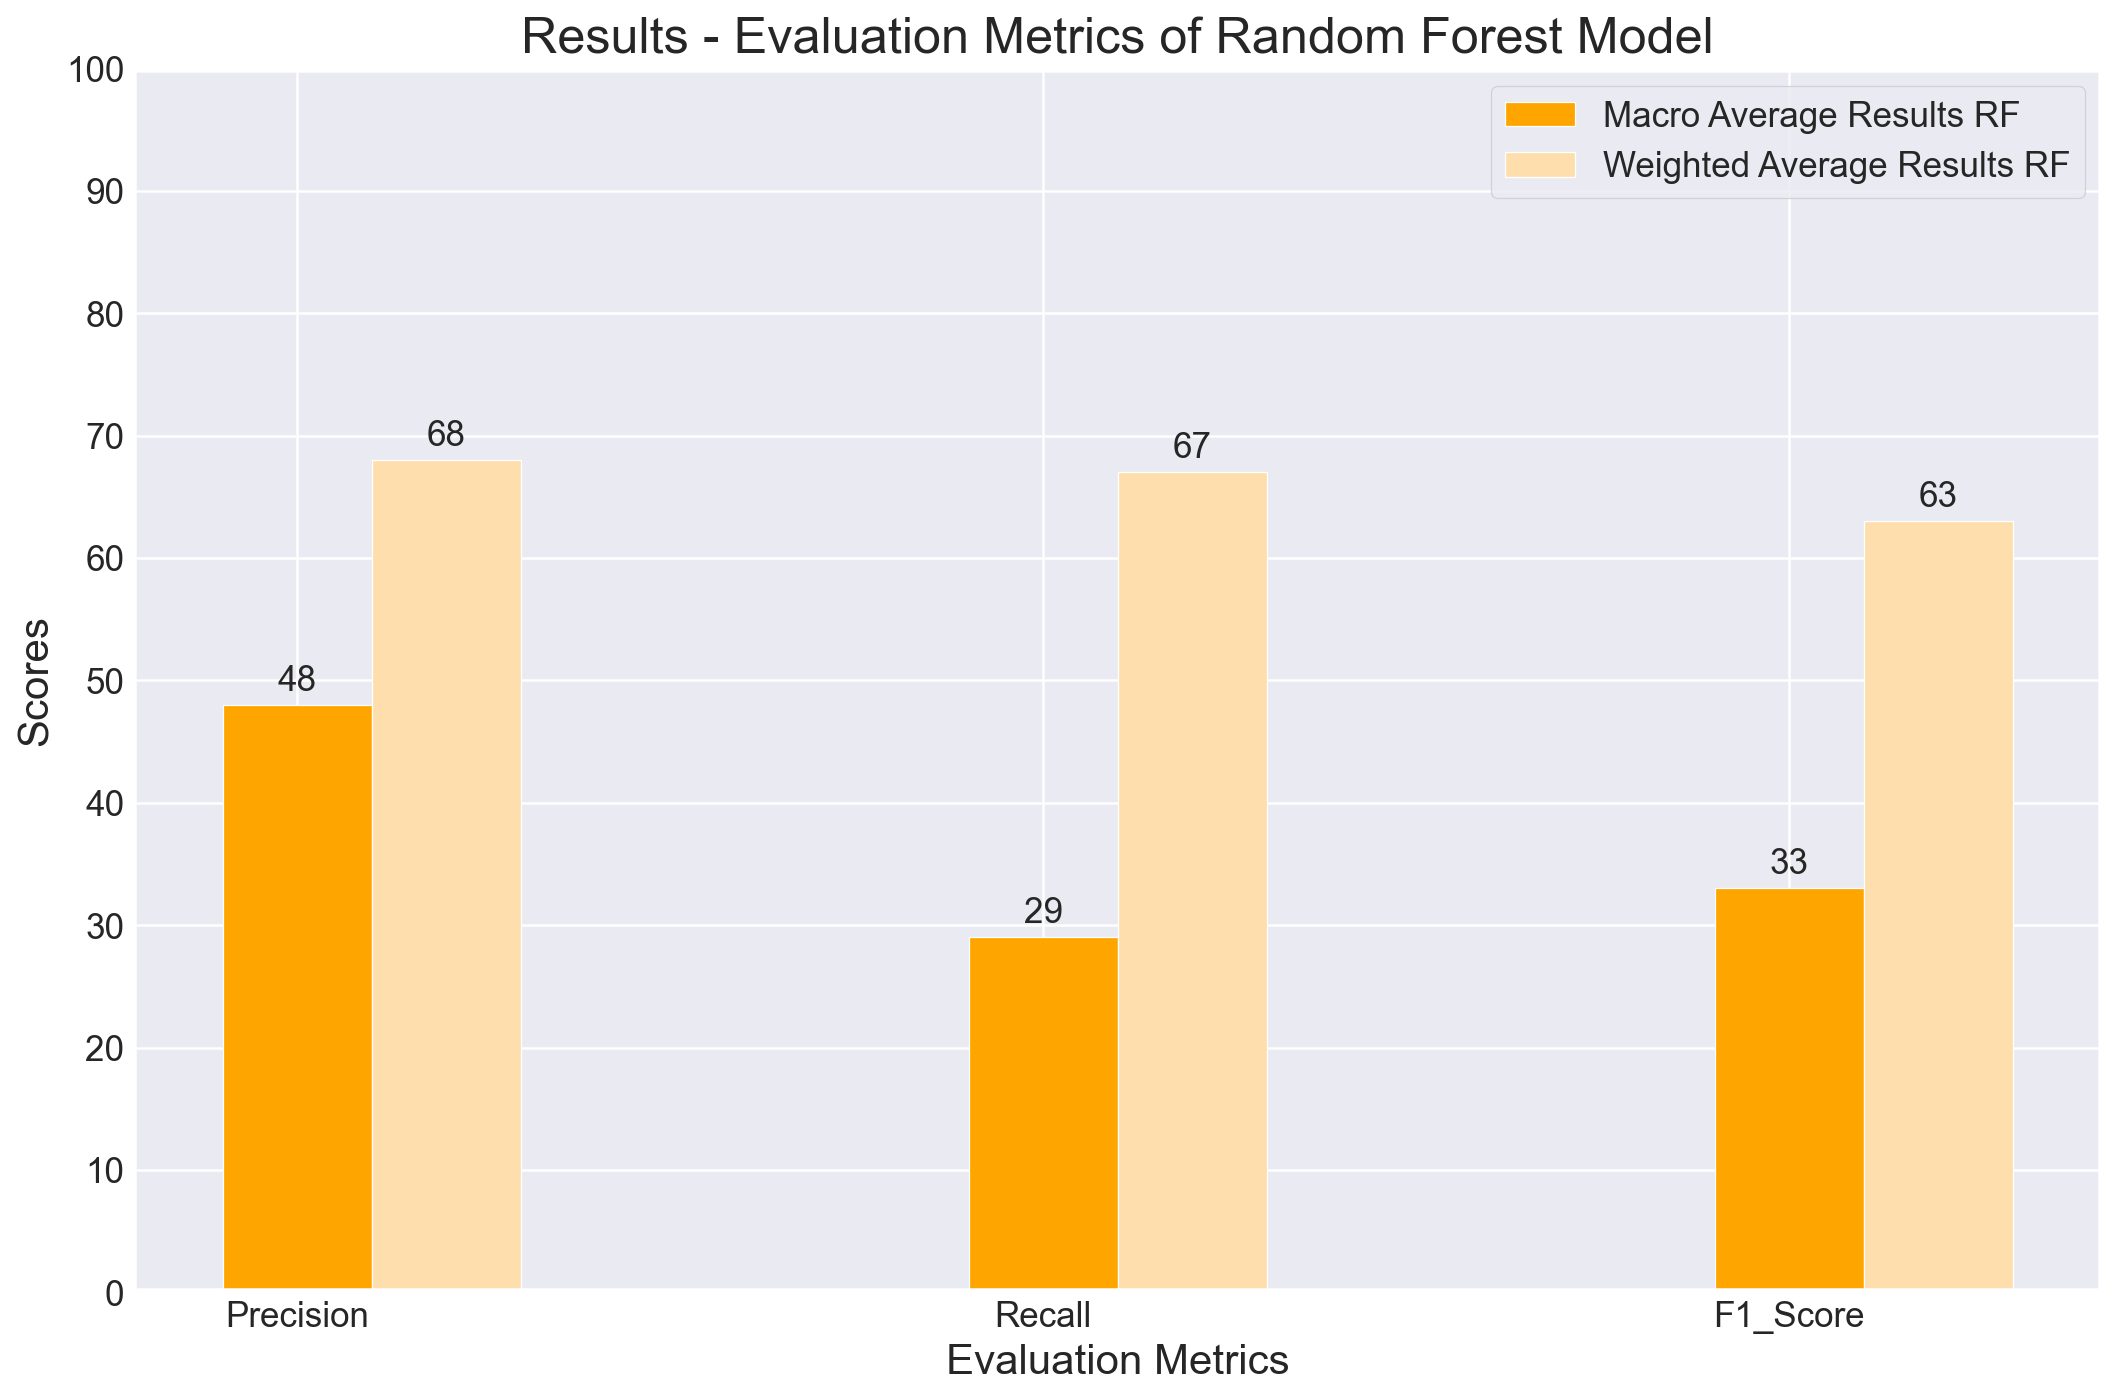

In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Precision', 'Recall', 'F1_Score']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Macro_Average_Results = [48, 29, 33]
Weighted_Average_Results = [68, 67, 63]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
Macro_Average_Results_1 = ax.bar(indx, Macro_Average_Results, bar_width, label='Macro Average Results RF',color = 'orange')
Weighted_Average_Results_1 = ax.bar(indx + bar_width, Weighted_Average_Results, bar_width, label='Weighted Average Results RF',color = 'navajowhite')



# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Results - Evaluation Metrics of Random Forest Model')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Macro_Average_Results_1)
insert_data_labels(Weighted_Average_Results_1)

plt.tight_layout()
plt.show()

In [28]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 95,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### Ensembling K-Neighbors Classifier  with default parameters into Multi Output Classifier

In [523]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

knn00 = KNeighborsClassifier()
model_knn_00 = MultiOutputClassifier(estimator = knn00)
knn00_model = model_knn_00.fit(xtrain, Y_train)
print("Train_Score = ", knn00_model.score(xtrain, Y_train),"Valid_Score = ",knn00_model.score(xvalid, Y_valid),
      "Test_Score = ", knn00_model.score(xtestdf1, Y_test_df1))

Train_Score =  0.7830773924539814 Valid_Score =  0.6775277124622103 Test_Score =  0.6544165054803353


### Hyperparameter Tuning for K-Neighbors Classifier 

In [29]:
from sklearn.neighbors import KNeighborsClassifier
Train_Score = []
Valid_Score_KNN = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs= -1)
    model2 = MultiOutputClassifier(estimator=knn)
    knn_clf = model2.fit(xtrain, Y_train)
    Train_Score.append(knn_clf.score(xtrain, Y_train))
    Valid_Score_KNN.append(knn_clf.score(xvalid, Y_valid))
    print("Estimators =", i, "Train_Score = ", knn_clf.score(xtrain, Y_train),
          "Valid_Score = ",knn_clf.score(xvalid, Y_valid))

Estimators = 1 Train_Score =  0.9989830163734363 Valid_Score =  0.7248908296943232
Estimators = 2 Train_Score =  0.8684023187226686 Valid_Score =  0.6973463218004703
Estimators = 3 Train_Score =  0.8304688294518459 Valid_Score =  0.6849177023849513
Estimators = 4 Train_Score =  0.8069765076782264 Valid_Score =  0.6818945246892845
Estimators = 5 Train_Score =  0.7830773924539814 Valid_Score =  0.6775277124622103
Estimators = 6 Train_Score =  0.7668056544289636 Valid_Score =  0.6711454484380248
Estimators = 7 Train_Score =  0.7518559951184786 Valid_Score =  0.6647631844138394
Estimators = 8 Train_Score =  0.7392453981490898 Valid_Score =  0.6627477326167283
Estimators = 9 Train_Score =  0.7297874504220482 Valid_Score =  0.663419549882432


### Printing the Validation Scores for K-Neighbors Classifier 

In [30]:
Valid_Score_KNN1 = []
for i in Valid_Score_KNN:
    Valid_Score_KNN1.append(round(i * 100, 2))
    
Valid_Score_KNN1

[72.49, 69.73, 68.49, 68.19, 67.75, 67.11, 66.48, 66.27, 66.34]

### Plotting the Validation Scores for K-Neighbors Classifier

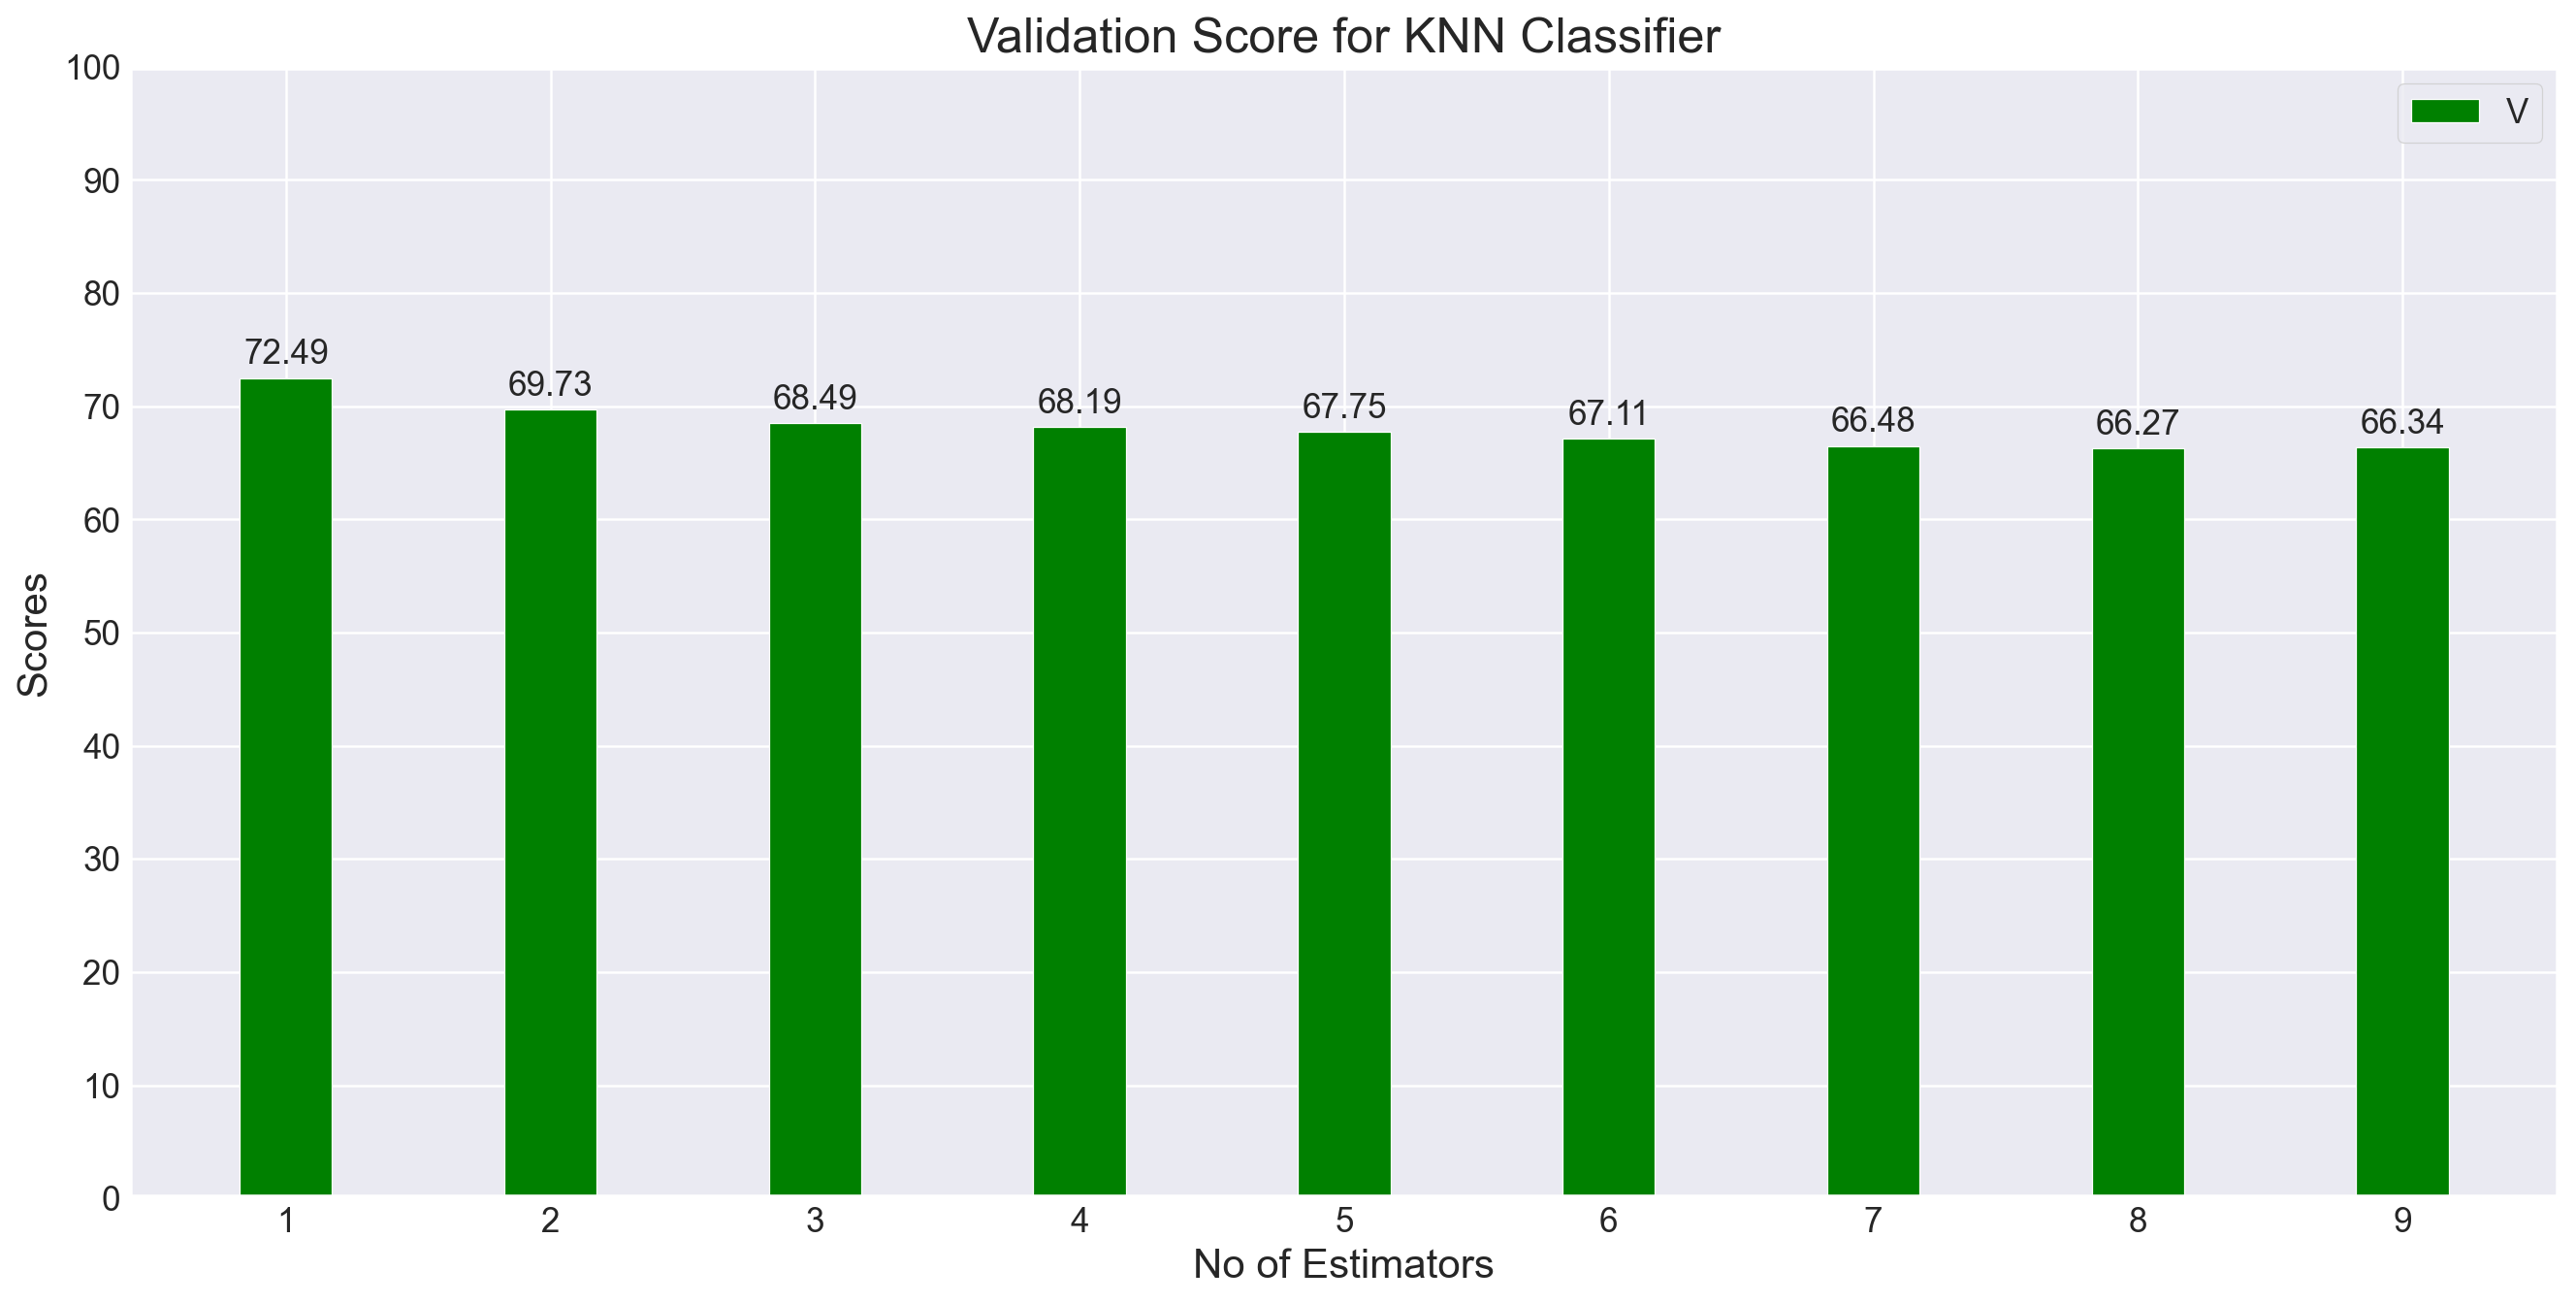

In [31]:
import matplotlib.pyplot as plt
import numpy as np

x = range(1,10)
y = Valid_Score_KNN1

fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.subplots()

xx = np.arange(len(Valid_Score_KNN1)) # the label locations
width = 0.35 # the width of the bars

#plt.xticks(rotation='vertical')

pps = ax.bar(xx - width/2, y, width, tick_label= x,color = 'g')
#plt.xticks(rotation='vertical')
ax.set_ylabel('Scores')
ax.set_xlabel('No of Estimators')
ax.legend(labels= 'Validation Scores')
ax.set_title('Validation Score for KNN Classifier')
score_label = np.arange(0, 110, 10)
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()



### Finalising the best parameter in K-Neighbors Classifier

In [111]:
knn1 = KNeighborsClassifier(n_neighbors=1, n_jobs= -1)
model21 = MultiOutputClassifier(estimator=knn1)
knn_clf1 = model21.fit(xtrain, Y_train)
print("Train_Score = ", knn_clf1.score(xtrain, Y_train),
          "Valid_Score = ",knn_clf1.score(xvalid, Y_valid),
     "Test_Score = ",knn_clf1.score(xtestdf1, Y_test_df1))

Train_Score =  0.9989830163734363 Valid_Score =  0.7248908296943232 Test_Score =  0.7005157962604771


###  Test Score of finalised parameter in K-Neighbors Classifier

In [112]:
test_df1_score_knn = knn_clf1.score(xtestdf1, Y_test_df1)
print(test_df1_score_knn)

0.7005157962604771


### Predicting the public test data using K-Neighbors Classifier

In [113]:
test_df2_predict_knn = knn_clf1.predict(xtestdf2)
print(test_df2_predict_knn)

[['67000000_Clothing' '67010000_Clothing' '67010700_Underwear']
 ['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars']
 ['64000000_Personal Accessories' '64010000_Personal Accessories'
  '64010200_Personal Carriers/Accessories']
 ...
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories']
 ['75000000_Household/Office Furniture/Furnishings'
  '75010000_Household/Office Furniture'
  '75010300_Household/Office Tables/Desks']]


### Actual Target columns of each level

In [250]:
actual_lvl1_knn = Y_test_df1.iloc[:,0].to_numpy()
actual_lvl2_knn = Y_test_df1.iloc[:,1].to_numpy()
actual_lvl3_knn = Y_test_df1.iloc[:,2].to_numpy()

### Predicted Target columns of each level


In [251]:
predicted_lvl1_knn = test_df2_predict_knn[:,0]
predicted_lvl2_knn = test_df2_predict_knn[:,1]
predicted_lvl3_knn = test_df2_predict_knn[:,2]

###  Calculating the Level 1 Classification Report of K-Neighbors Classifier 

In [252]:
print(classification_report(actual_lvl1_knn, predicted_lvl1_knn))

                                                        precision    recall  f1-score   support

                                10000000_Pet Care/Food       0.82      0.78      0.80        88
                    47000000_Cleaning/Hygiene Products       0.69      0.67      0.68        27
                        50000000_Food/Beverage/Tobacco       0.69      0.76      0.72        80
                                   51000000_Healthcare       0.79      0.80      0.79        70
                 53000000_Beauty/Personal Care/Hygiene       0.65      0.63      0.64        41
                                    54000000_Baby Care       0.71      0.56      0.63         9
          60000000_Textual/Printed/Reference Materials       0.73      0.72      0.73        50
                                        61000000_Music       1.00      0.95      0.98        22
62000000_Stationery/Office Machinery/Occasion Supplies       0.91      0.59      0.71        51
                                     63

###  Calculating the Level 2 Classification Report of K-Neighbors Classifier 

In [253]:
print(classification_report(actual_lvl2_knn, predicted_lvl2_knn))

                                                                      precision    recall  f1-score   support

                                                   10100000_Pet Care       0.81      0.76      0.78        82
                                            10110000_Pet Food/Drinks       0.71      0.83      0.77         6
                                          47100000_Cleaning Products       0.61      0.58      0.59        19
                               47120000_Insect/Pest/Allergen Control       0.88      0.88      0.88         8
            50100000_Fruits/Vegetables/Nuts/Seeds Prepared/Processed       0.60      0.50      0.55         6
          50130000_Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes       0.00      0.00      0.00         1
                                           50150000_Oils/Fats Edible       0.67      0.29      0.40         7
                    50160000_Confectionery/Sugar Sweetening Products       0.43      0.75      0.55         4
         

###  Calculating the Level 3 Classification Report of K-Neighbors Classifier 

In [254]:
print(classification_report(actual_lvl3_knn, predicted_lvl3_knn))

                                                                      precision    recall  f1-score   support

                                        10101500_Pet Welfare/Hygiene       0.80      0.80      0.80        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.76      0.70      0.73        69
                                     10101800_Pet Care Variety Packs       1.00      1.00      1.00         2
                                                   10111600_Pet Food       0.71      0.83      0.77         6
                                     47101500_Fresheners/Deodorisers       0.00      0.00      0.00         1
                                                   47101600_Cleaners       0.59      0.59      0.59        17
                                                    47101700_Laundry       1.00      1.00      1.00         1
         

### Sublist of all three Actual Target Column 

In [120]:
flatten_list1_knn = [element for sublist in Y_test_df1.to_numpy() for element in sublist]
len(flatten_list1_knn)

9306

### Sublist of all three Predicted Target Column

In [121]:
flatten_list2_knn = [element for sublist in test_df2_predict_knn for element in sublist]
len(flatten_list2_knn)


9306

###  Calculating the Level 3 Classification Report of K-Neighbors Classifier 

In [122]:
print(classification_report(flatten_list1_knn, flatten_list2_knn))

                                                                      precision    recall  f1-score   support

                                              10000000_Pet Care/Food       0.82      0.78      0.80        88
                                                   10100000_Pet Care       0.81      0.76      0.78        82
                                        10101500_Pet Welfare/Hygiene       0.80      0.80      0.80        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.76      0.70      0.73        69
                                     10101800_Pet Care Variety Packs       1.00      1.00      1.00         2
                                            10110000_Pet Food/Drinks       0.71      0.83      0.77         6
                                                   10111600_Pet Food       0.71      0.83      0.77         6
         

### Macro Average Results for KNN Model

In [255]:
macro_avg_KNN = [[0.69, 0.66, 0.67], [0.65, 0.64, 0.62], [0.54, 0.53, 0.52],[0.58, 0.57, 0.55]]
Results_Macro_Average_KNN = pd.DataFrame(macro_avg_KNN,index = ['macro_avg_KNN_lvl1','macro_avg_KNN_lvl2',
                                                        'macro_avg_KNN_lvl3','Total_Macro_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Macro_Average_KNN

Precision  Recall  F1_score
macro_avg_KNN_lvl1       0.69    0.66      0.67
macro_avg_KNN_lvl2       0.65    0.64      0.62
macro_avg_KNN_lvl3       0.54    0.53      0.52
Total_Macro_AVG          0.58    0.57      0.55

### Weighted Average Results for KNN Model

In [256]:
weighted_avg_KNN = [[0.80, 0.80, 0.80], [0.79, 0.79, 0.79], [0.71, 0.70, 0.69],[0.77, 0.77, 0.76]]
Results_Weighted_Average_KNN = pd.DataFrame(weighted_avg_KNN,index = ['weighted_avg_KNN_lvl1','weighted_avg_KNN_lvl2',
                                                        'weighted_avg_KNN_lvl3','Total_Weighted_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Weighted_Average_KNN

Precision  Recall  F1_score
weighted_avg_KNN_lvl1       0.80    0.80      0.80
weighted_avg_KNN_lvl2       0.79    0.79      0.79
weighted_avg_KNN_lvl3       0.71    0.70      0.69
Total_Weighted_AVG          0.77    0.77      0.76

###  Plotting the Evaluation Metrics of K-Neighbors Classifier

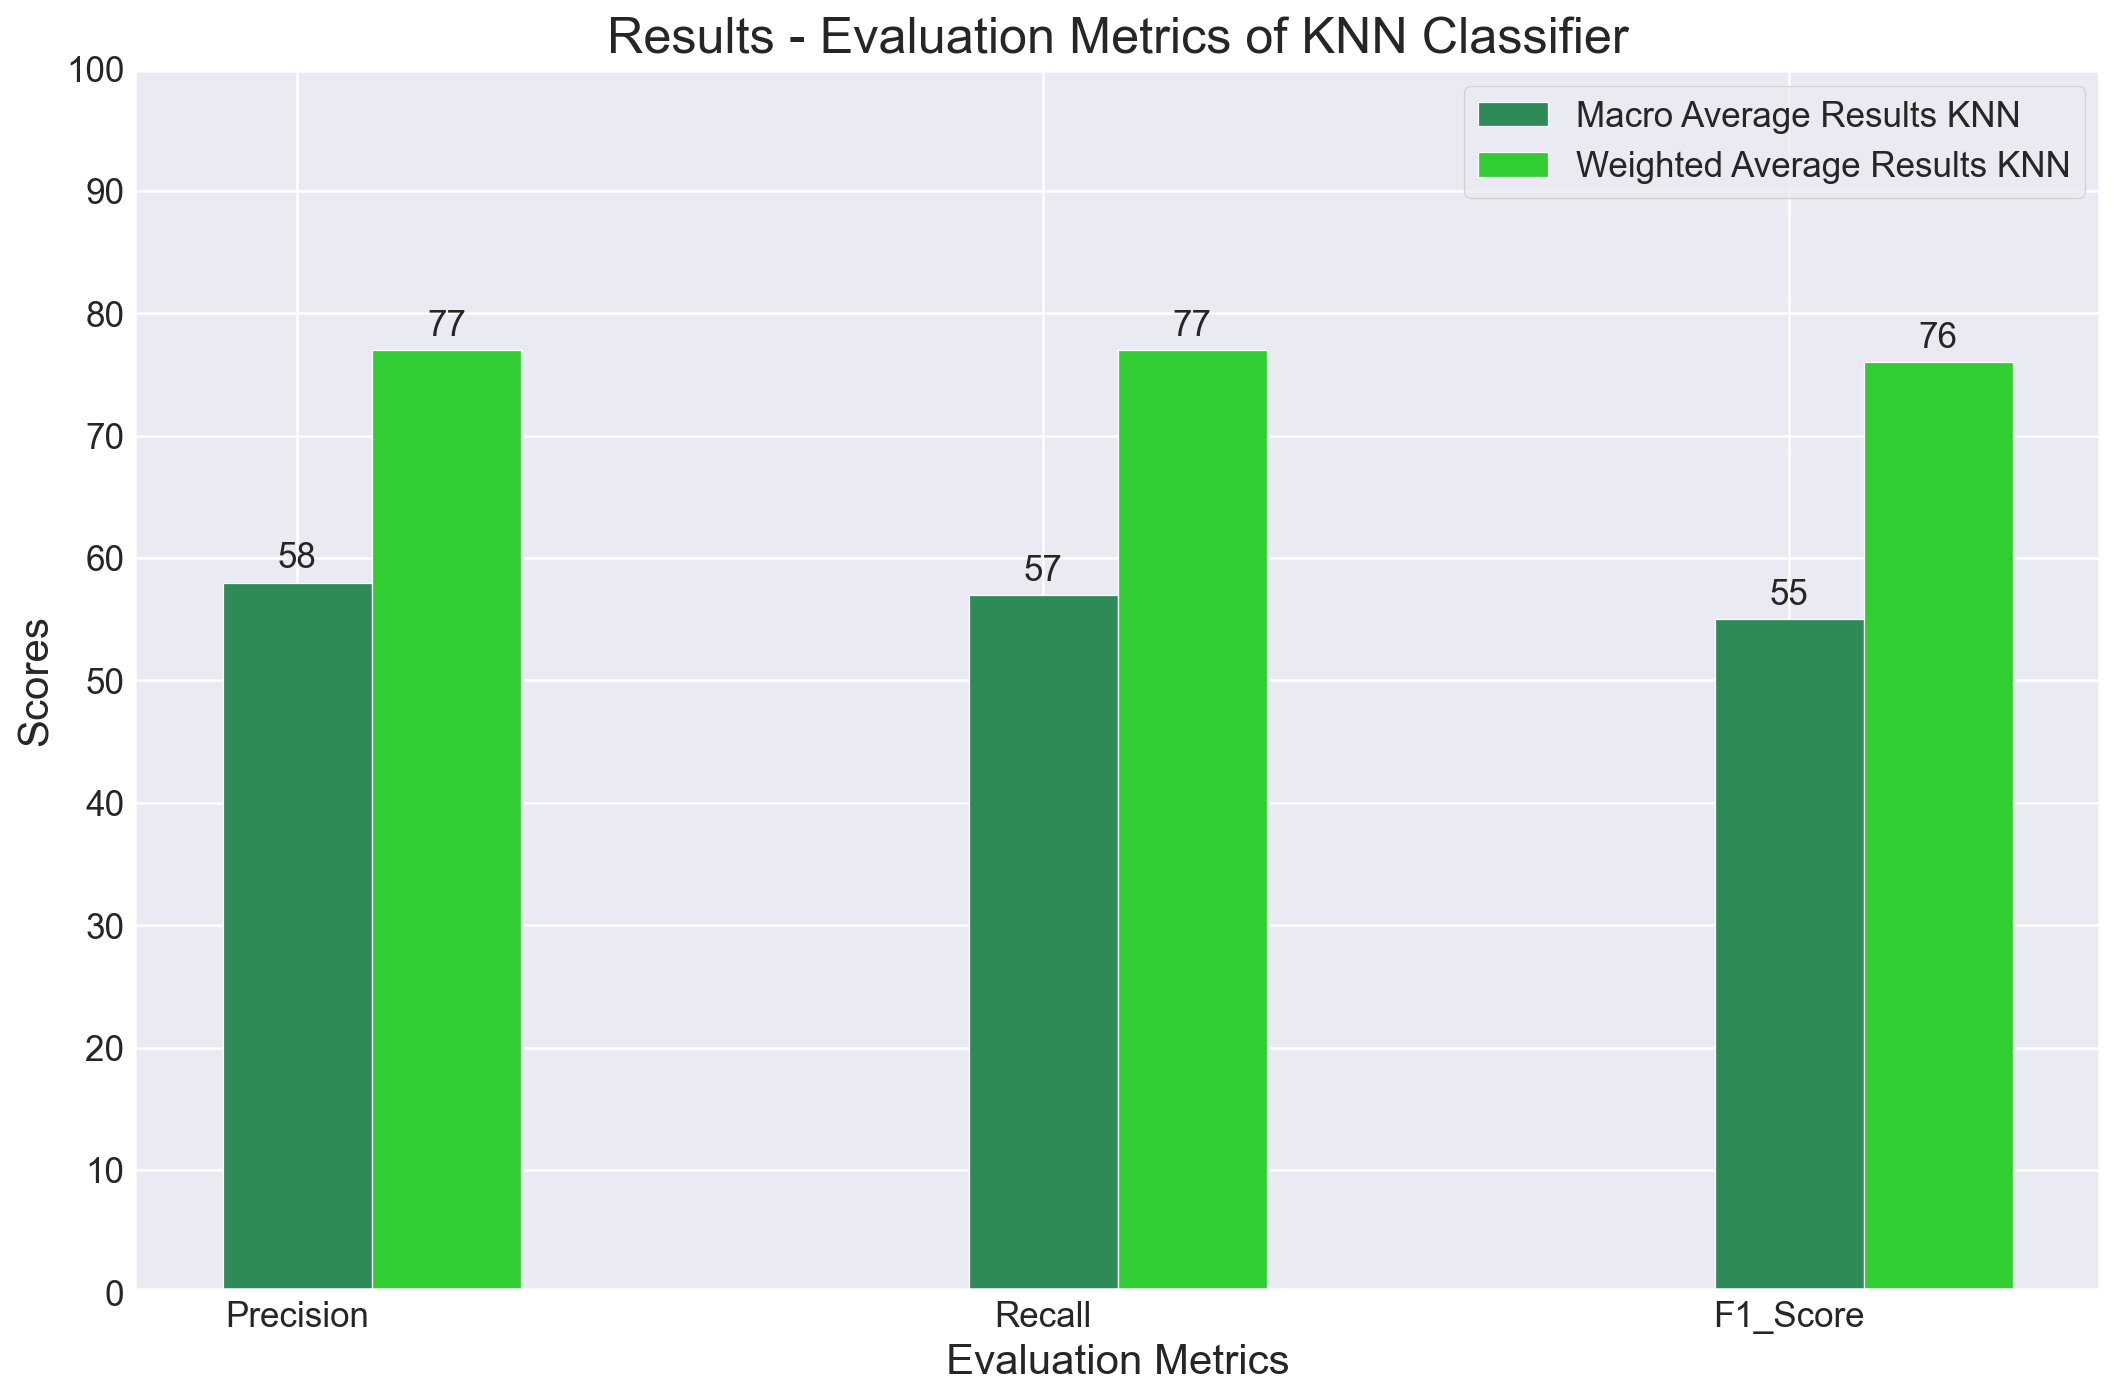

In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Precision', 'Recall', 'F1_Score']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Macro_Average_Results = [58, 57, 55]
Weighted_Average_Results = [77, 77, 76]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
Macro_Average_Results_1 = ax.bar(indx, Macro_Average_Results, bar_width, label='Macro Average Results KNN',color = 'seagreen')
Weighted_Average_Results_1 = ax.bar(indx + bar_width, Weighted_Average_Results, bar_width, label='Weighted Average Results KNN',color = 'limegreen')



# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Results - Evaluation Metrics of KNN Classifier')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Macro_Average_Results_1)
insert_data_labels(Weighted_Average_Results_1)

plt.tight_layout()
plt.show()

In [32]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'uniform'}

### Hyperparameter Tuning using differnt metrics for K-Neighbors Classifier

In [33]:
from sklearn.neighbors import KNeighborsClassifier
Valid_Score_KNN2 = []
metric = ['euclidean', 'manhattan','minkowski','cosine']
for i in range(1,6):
    for k in metric:
        knn2 = KNeighborsClassifier(n_neighbors=i, metric = k, n_jobs= -1)
        model3 = MultiOutputClassifier(estimator=knn2)
        knn2_clf = model3.fit(xtrain, Y_train)
        Valid_Score_KNN2.append(knn2_clf.score(xvalid, Y_valid))

        print("Estimators =", i, 'Metric = ', k, "Train_Score = ", knn_clf.score(xtrain, Y_train),
              "Valid_Score = ",knn2_clf.score(xvalid, Y_valid))
    print('==============================================')

Estimators = 1 Metric =  euclidean Train_Score =  0.7297874504220482 Valid_Score =  0.7248908296943232
Estimators = 1 Metric =  manhattan Train_Score =  0.7297874504220482 Valid_Score =  0.5455156197514276
Estimators = 1 Metric =  minkowski Train_Score =  0.7297874504220482 Valid_Score =  0.7248908296943232
Estimators = 1 Metric =  cosine Train_Score =  0.7297874504220482 Valid_Score =  0.7248908296943232
Estimators = 2 Metric =  euclidean Train_Score =  0.7297874504220482 Valid_Score =  0.6973463218004703
Estimators = 2 Metric =  manhattan Train_Score =  0.7297874504220482 Valid_Score =  0.522337924084649
Estimators = 2 Metric =  minkowski Train_Score =  0.7297874504220482 Valid_Score =  0.6973463218004703
Estimators = 2 Metric =  cosine Train_Score =  0.7297874504220482 Valid_Score =  0.6973463218004703
Estimators = 3 Metric =  euclidean Train_Score =  0.7297874504220482 Valid_Score =  0.6849177023849513
Estimators = 3 Metric =  manhattan Train_Score =  0.7297874504220482 Valid_Score

### Printing the Validation Scores for K-Neighbors Classifier

In [543]:
Valid_Score_KNN_2 = []
for i in Valid_Score_KNN2:
    Valid_Score_KNN_2.append(round(i * 100, 2))
    
print(Valid_Score_KNN_2)

[72.49, 54.55, 72.49, 72.49, 69.73, 52.23, 69.73, 69.73, 68.49, 46.02, 68.49, 68.49, 68.19, 44.27, 68.19, 68.26, 67.75, 46.19, 67.75, 67.79]


### Plotting the Validation Scores for K-Neighbors Classifier

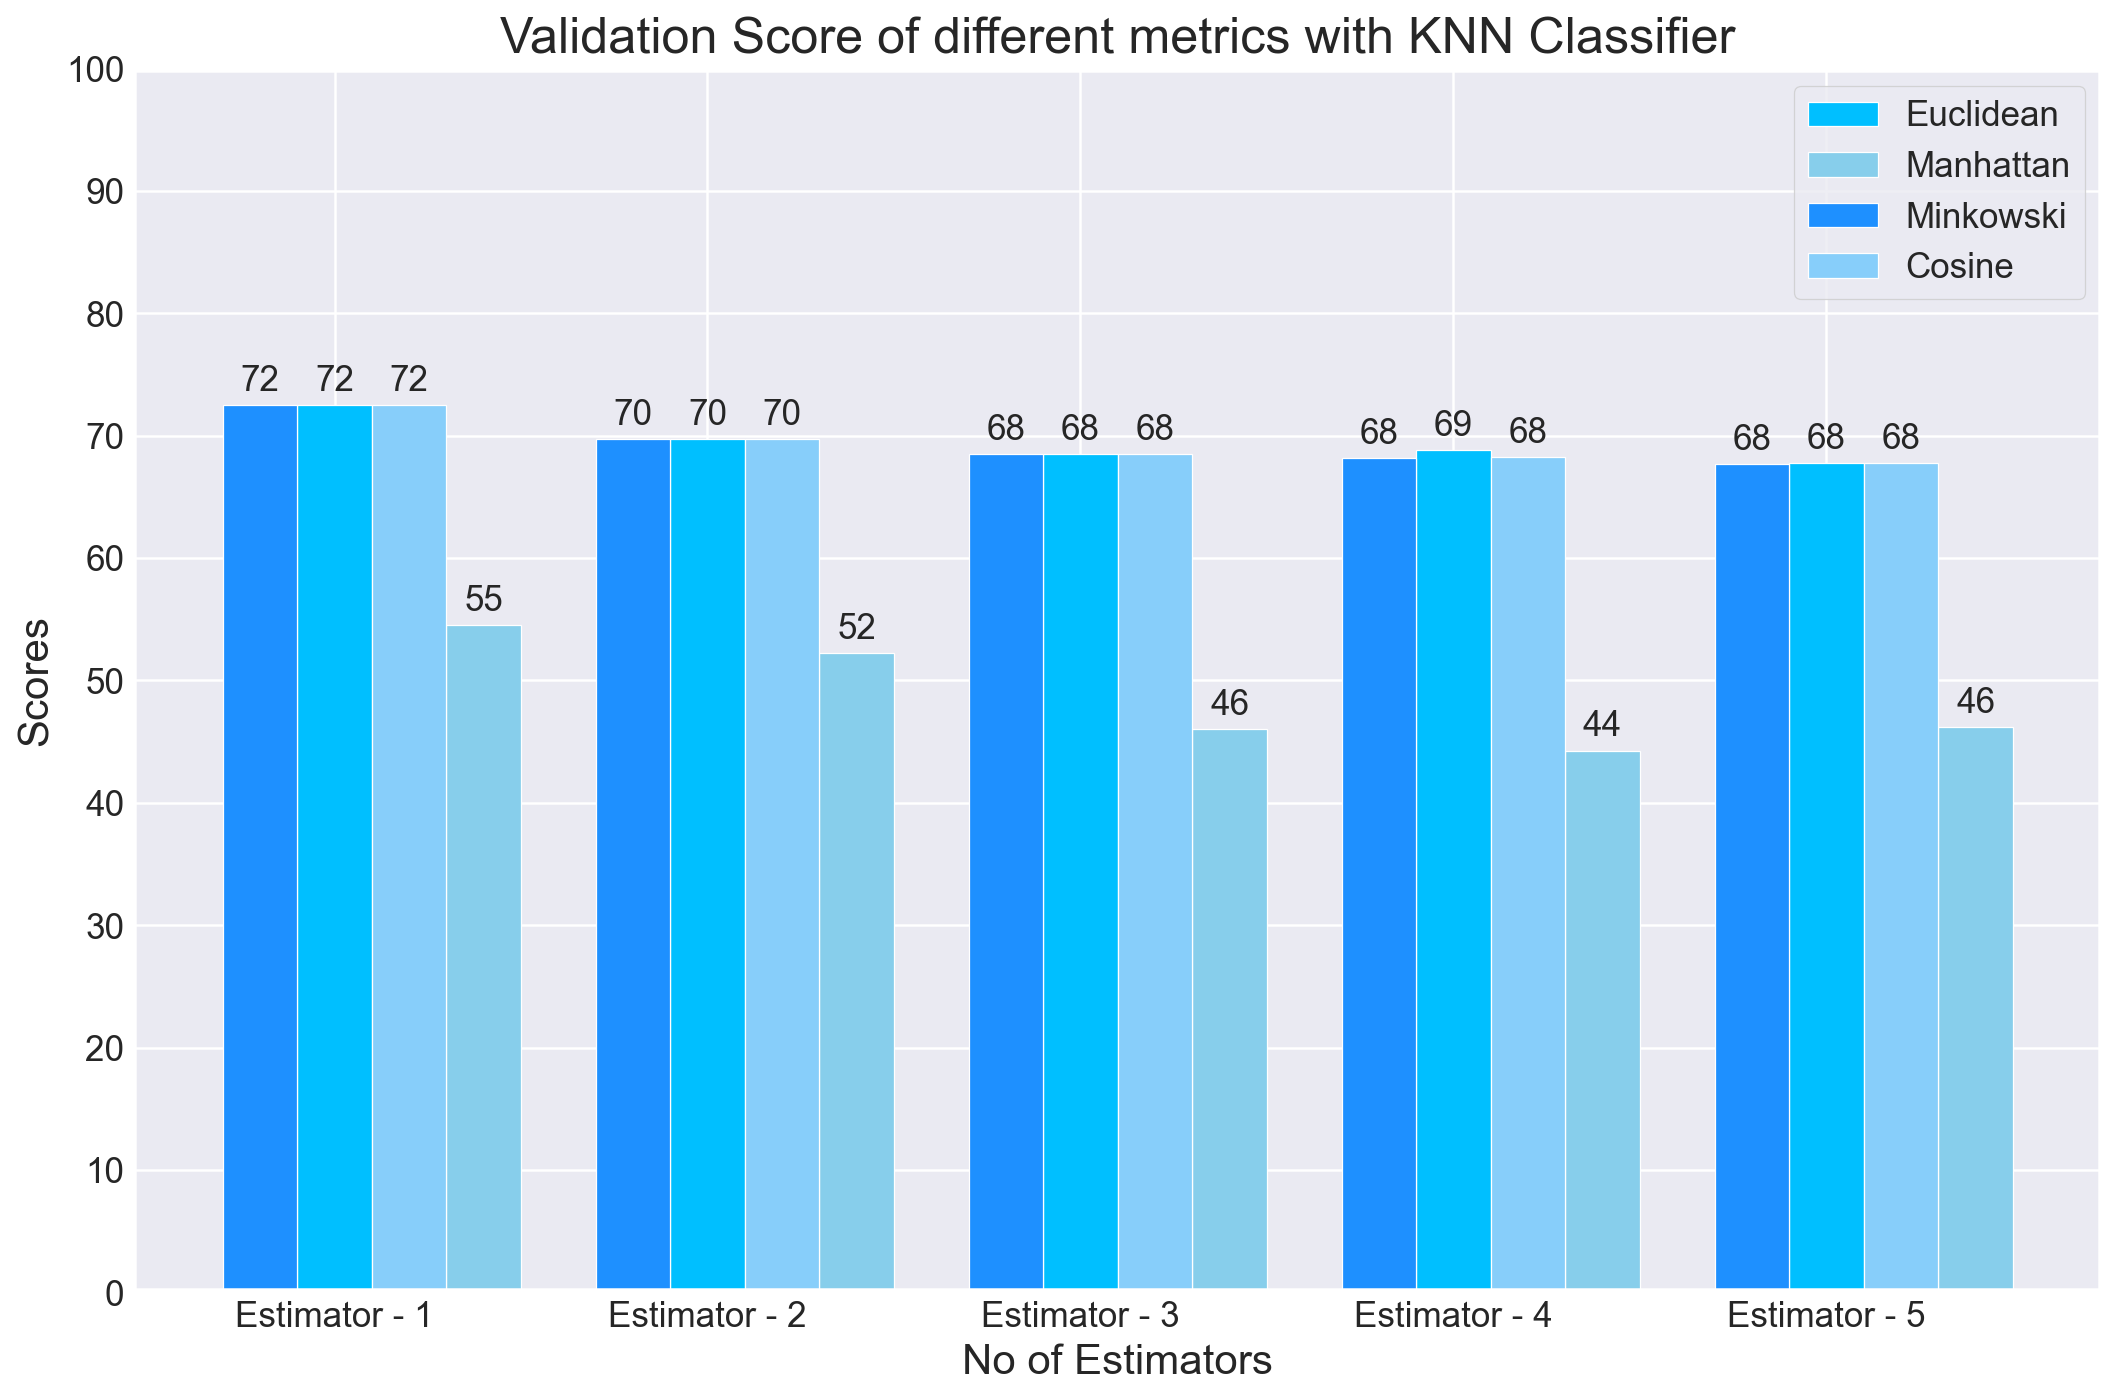

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Estimator - 1', 'Estimator - 2', 'Estimator - 3',  'Estimator - 4', 'Estimator - 5']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Euclidean = [72.49,69.73,68.49,68.81, 67.75]
Manhattan = [54.55,52.23,46.02,44.27, 46.19 ]
Minkowski = [72.49,69.73,68.49,68.19,67.7]
Cosine = [ 72.49,69.73,68.49,68.26,67.79]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
Euclidean_1 = ax.bar(indx - bar_width+0.4/2, Euclidean, bar_width, label='Euclidean',color = 'deepskyblue')
Manhattan_1 = ax.bar(indx + bar_width * 4/2, Manhattan, bar_width, label='Manhattan',color = 'skyblue')
Minkowski_1 = ax.bar(indx - bar_width * 2/2, Minkowski, bar_width, label='Minkowski',color = 'dodgerblue')
Cosine_1 = ax.bar(indx + bar_width * 2/2, Cosine, bar_width, label='Cosine',color = 'lightskyblue')


# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('No of Estimators')
ax.set_title('Validation Score of different metrics with KNN Classifier')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Euclidean_1)
insert_data_labels(Manhattan_1)
insert_data_labels(Minkowski_1)
insert_data_labels(Cosine_1)
plt.tight_layout()
plt.show()

### Printing the KNN Parameters

In [36]:
knn2.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### Ensembling Logistic Regression with default parameters into Multi Output Classifier

In [522]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

lr00 = LogisticRegression()
model_lr_00 = MultiOutputClassifier(estimator = lr00)
lr00_model = model_lr_00.fit(xtrain, Y_train)
print("Train_Score = ", lr00_model.score(xtrain, Y_train),"Valid_Score = ",lr00_model.score(xvalid, Y_valid),
      "Test_Score = ", lr00_model.score(xtestdf1, Y_test_df1))

Train_Score =  0.7476863622495677 Valid_Score =  0.6419213973799127 Test_Score =  0.6163765312701482


### Hyperparameter Tuning for Logistic Regression

In [45]:
Valid_Scores_LR = []

# Importing the required packages
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
for i in c_values:
    for j in solvers:
        lr = LogisticRegression(C = i, penalty = 'l2', solver = j)
        model8 = MultiOutputClassifier(estimator = lr)
        lr_model1 = model8.fit(xtrain, Y_train)
        Valid_Scores_LR.append(lr_model1.score(xvalid, Y_valid))
        print("For C =",i,'Solver = ',j,"Train_Score = ", 
              lr_model1.score(xtrain, Y_train),"Valid_Score = ",
              lr_model1.score(xvalid, Y_valid))
    print('==============================================')

For C = 100 Solver =  newton-cg Train_Score =  0.9980677311095292 Valid_Score =  0.7961034598589184
For C = 100 Solver =  lbfgs Train_Score =  0.9978643343842164 Valid_Score =  0.7974470943903258
For C = 100 Solver =  liblinear Train_Score =  0.9975592392962473 Valid_Score =  0.8081961706415854
For C = 10 Solver =  newton-cg Train_Score =  0.9951184785924947 Valid_Score =  0.779643936849177
For C = 10 Solver =  lbfgs Train_Score =  0.9950167802298383 Valid_Score =  0.7803157541148807
For C = 10 Solver =  liblinear Train_Score =  0.9898301637343638 Valid_Score =  0.7850184749748068
For C = 1.0 Solver =  newton-cg Train_Score =  0.7475846638869115 Valid_Score =  0.6419213973799127
For C = 1.0 Solver =  lbfgs Train_Score =  0.7476863622495677 Valid_Score =  0.6419213973799127
For C = 1.0 Solver =  liblinear Train_Score =  0.7231770568493847 Valid_Score =  0.6231105139402082
For C = 0.1 Solver =  newton-cg Train_Score =  0.3743516729380657 Valid_Score =  0.3708431306684582
For C = 0.1 Solv

###  Printing the Validation Scores for Logistic Regression

In [519]:
Valid_Scores_LR1 = []
for i in Valid_Scores_LR:
    Valid_Scores_LR1.append(round(i * 100, 2))
    
print(Valid_Scores_LR1)

[79.61, 79.74, 80.82, 77.96, 78.03, 78.5, 64.19, 64.19, 62.31, 37.08, 37.08, 36.51, 31.71, 31.71, 31.71]


###  Plotting the Validation Scores for Logistic Regression

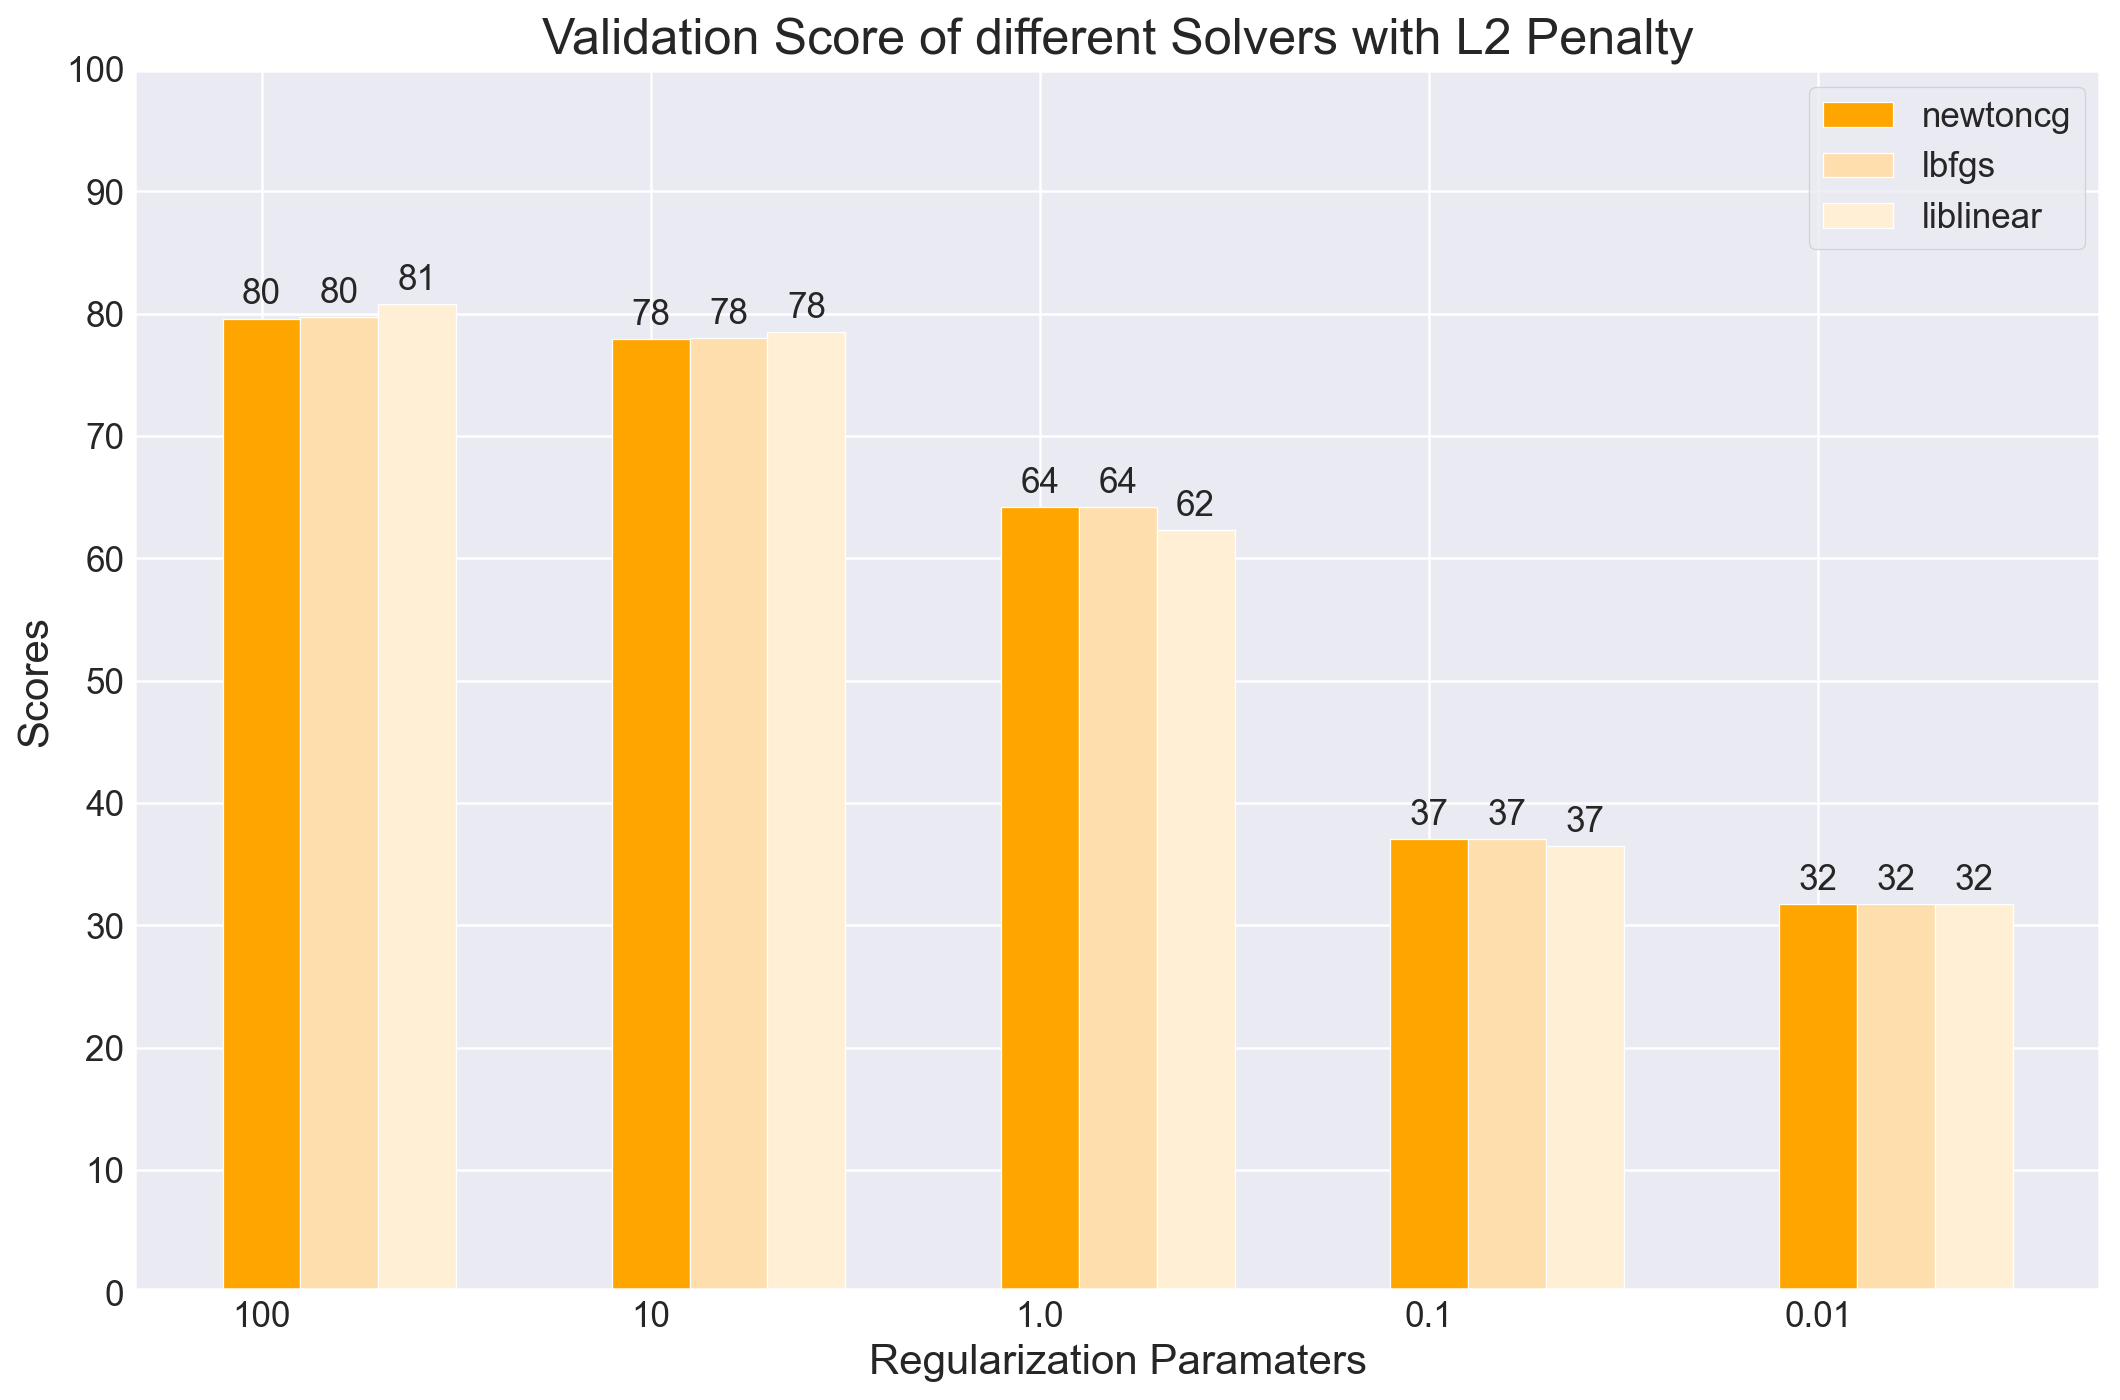

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=[100, 10, 1.0, 0.1, 0.01]


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
newtoncg = [79.61,77.96,64.19,37.08,31.71]
lbfgs = [79.74,78.03,64.19,37.08,31.71]
liblinear = [80.82,78.5,62.31,36.51,31.71]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
newtoncg_1 = ax.bar(indx - bar_width+0.4/2, newtoncg, bar_width, label='newtoncg',color = 'orange')
lbfgs_1 = ax.bar(indx + bar_width * 2/2, lbfgs, bar_width, label='lbfgs',color = 'navajowhite')
liblinear_1 = ax.bar(indx + bar_width * 4/2, liblinear, bar_width, label='liblinear',color = 'papayawhip')


# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('Regularization Paramaters')
ax.set_title('Validation Score of different Solvers with L2 Penalty')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(bar.get_height()),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(newtoncg_1)
insert_data_labels(lbfgs_1)
insert_data_labels(liblinear_1)
plt.tight_layout()
plt.show()

### Finalising the best parameter in Logistic Regression 

In [310]:
# Importing the required packages
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

lr1 = LogisticRegression(C = 100, penalty = 'l2', solver = 'liblinear')
model71 = MultiOutputClassifier(estimator = lr1)
lr_model1 = model71.fit(xtrain, Y_train)
print("Train_Score = ", lr_model1.score(xtrain, Y_train),
      "Valid_Score = ",lr_model1.score(xvalid, Y_valid),
      "Test_Score = ",lr_model1.score(xtestdf1, Y_test_df1))

Train_Score =  0.9975592392962473 Valid_Score =  0.8081961706415854 Test_Score =  0.7933591231463571


###  Test Score of finalised parameter in Logistic Regression


In [94]:
test_df1_score_lr = lr_model1.score(xtestdf1, Y_test_df1)
print(test_df1_score_lr)

0.7933591231463571


### Predicting the public test data using Logistic Regression 

In [95]:
test_df2_predict_lr = lr_model1.predict(xtestdf2)
print(test_df2_predict_lr)

[['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars']
 ['67000000_Clothing' '67010000_Clothing' '67010700_Underwear']
 ...
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories']
 ['75000000_Household/Office Furniture/Furnishings'
  '75010000_Household/Office Furniture'
  '75010300_Household/Office Tables/Desks']]


### Predicting the Probabilities of Public test data for Logistic Regression 

In [553]:
test_df2_predict_lr_proba = lr_model1.predict_proba(xtestdf2)
print(test_df2_predict_lr_proba)

[array([[3.01769013e-04, 1.50752955e-04, 2.41464504e-04, ...,
        1.54483166e-04, 1.08217555e-04, 1.44236506e-04],
       [2.41129562e-03, 3.55514717e-04, 5.77361932e-04, ...,
        1.91781549e-04, 9.70759777e-05, 9.74262006e-05],
       [1.68096326e-04, 1.83993031e-04, 7.97192550e-04, ...,
        9.70556904e-05, 9.58340839e-05, 8.78991271e-05],
       ...,
       [1.08267244e-04, 1.05162621e-04, 1.99255078e-04, ...,
        6.54220925e-05, 5.32506500e-05, 5.61581316e-05],
       [1.23946060e-04, 5.16826503e-04, 2.87008459e-04, ...,
        1.02101829e-04, 2.17016081e-04, 8.03835008e-05],
       [1.16738942e-03, 5.43220168e-04, 4.83245008e-04, ...,
        2.87226413e-04, 9.90541940e-05, 1.29750885e-04]]), array([[3.33625987e-04, 9.09531136e-05, 1.51907467e-04, ...,
        3.64977412e-05, 2.27649739e-05, 9.07650802e-05],
       [5.07907339e-03, 2.57743388e-04, 3.38262125e-04, ...,
        6.81316397e-05, 7.70430159e-05, 1.38069639e-04],
       [1.62958208e-04, 1.24671566e-04, 1

### Actual Target columns of each level

In [271]:
actual_lvl1_RR_L2 = Y_test_df1.iloc[:,0].to_numpy()
actual_lvl2_RR_L2 = Y_test_df1.iloc[:,1].to_numpy()
actual_lvl3_RR_L2 = Y_test_df1.iloc[:,2].to_numpy()

### Predicted Target columns of each level

In [272]:
predicted_lvl1_RR_L2 = test_df2_predict_lr[:,0]
predicted_lvl2_RR_L2 = test_df2_predict_lr[:,1]
predicted_lvl3_RR_L2 = test_df2_predict_lr[:,2]

###  Calculating the Level 1 Classification Report of Logistic Regression 

In [273]:
print(classification_report(actual_lvl1_RR_L2, predicted_lvl1_RR_L2))

                                                        precision    recall  f1-score   support

                                10000000_Pet Care/Food       0.93      0.93      0.93        88
                    47000000_Cleaning/Hygiene Products       0.75      0.67      0.71        27
                        50000000_Food/Beverage/Tobacco       0.92      0.81      0.86        80
                                   51000000_Healthcare       0.84      0.89      0.86        70
                 53000000_Beauty/Personal Care/Hygiene       0.72      0.71      0.72        41
                                    54000000_Baby Care       0.71      0.56      0.63         9
          60000000_Textual/Printed/Reference Materials       0.75      0.80      0.78        50
                                        61000000_Music       1.00      0.95      0.98        22
62000000_Stationery/Office Machinery/Occasion Supplies       0.97      0.67      0.79        51
                                     63

###  Calculating the Level 2 Classification Report of Logistic Regression

In [274]:
print(classification_report(actual_lvl2_RR_L2, predicted_lvl2_RR_L2))

                                                                      precision    recall  f1-score   support

                                                   10100000_Pet Care       0.91      0.94      0.92        82
                                            10110000_Pet Food/Drinks       1.00      0.67      0.80         6
                                          47100000_Cleaning Products       0.63      0.63      0.63        19
                               47120000_Insect/Pest/Allergen Control       1.00      0.88      0.93         8
            50100000_Fruits/Vegetables/Nuts/Seeds Prepared/Processed       0.50      0.33      0.40         6
          50130000_Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes       0.00      0.00      0.00         1
                                           50150000_Oils/Fats Edible       1.00      0.14      0.25         7
                    50160000_Confectionery/Sugar Sweetening Products       0.60      0.75      0.67         4
         

###  Calculating the Level 3 Classification Report of Logistic Regression

In [544]:
print(classification_report(actual_lvl3_RR_L2, predicted_lvl3_RR_L2))

                                                                      precision    recall  f1-score   support

                                        10101500_Pet Welfare/Hygiene       0.80      0.80      0.80        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.70      0.93      0.80        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                                   10111600_Pet Food       1.00      0.67      0.80         6
                                     47101500_Fresheners/Deodorisers       0.00      0.00      0.00         1
                                                   47101600_Cleaners       0.59      0.76      0.67        17
                                                    47101700_Laundry       0.00      0.00      0.00         1
         

### Sublist of all three Actual Target Column 

In [99]:
flatten_list1_lr = [element for sublist in Y_test_df1.to_numpy() for element in sublist]
len(flatten_list1_lr)

9306

### Sublist of all three Predicted Target Column 

In [100]:
flatten_list2_lr = [element for sublist in test_df2_predict_lr for element in sublist]
len(flatten_list2_lr)

9306

###  Combining all  3 levels - Classification Report of Logistic Regression 

In [101]:
print(classification_report(flatten_list1_lr, flatten_list2_lr))

                                                                      precision    recall  f1-score   support

                                              10000000_Pet Care/Food       0.93      0.93      0.93        88
                                                   10100000_Pet Care       0.91      0.94      0.92        82
                                        10101500_Pet Welfare/Hygiene       0.80      0.80      0.80        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.70      0.93      0.80        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                            10110000_Pet Food/Drinks       1.00      0.67      0.80         6
                                                   10111600_Pet Food       1.00      0.67      0.80         6
         

### Macro Average Results for Logistic Regression ( Penalty = l2 ) Model 

In [278]:
macro_avg_RR_L2 = [[0.78, 0.71, 0.74], [0.74, 0.63, 0.66], [0.61, 0.53, 0.55],[0.66, 0.57, 0.59]]
Results_Macro_Average_RR_L2 = pd.DataFrame(macro_avg_RR_L2,index = ['macro_avg_RR_L2_lvl1','macro_avg_RR_L2_lvl2',
                                                        'macro_avg_RR_L2_lvl3','Total_Macro_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Macro_Average_RR_L2

Precision  Recall  F1_score
macro_avg_RR_L2_lvl1       0.78    0.71      0.74
macro_avg_RR_L2_lvl2       0.74    0.63      0.66
macro_avg_RR_L2_lvl3       0.61    0.53      0.55
Total_Macro_AVG            0.66    0.57      0.59

### Weighted Average Results for Logistic Regresssion ( Penalty = l2 ) Model

In [279]:
weighted_avg_RR_L2 = [[0.88, 0.89, 0.88], [0.88, 0.88, 0.87], [0.80, 0.82, 0.80],[0.86, 0.86, 0.85]]
Results_Weighted_Average_RR_L2 = pd.DataFrame(weighted_avg_RR_L2,index = ['weighted_avg_RR_L2_lvl1',
                                                                          'weighted_avg_RR_L2_lvl2',
                                                        'weighted_avg_RR_L2_lvl3','Total_Weighted_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Weighted_Average_RR_L2

Precision  Recall  F1_score
weighted_avg_RR_L2_lvl1       0.88    0.89      0.88
weighted_avg_RR_L2_lvl2       0.88    0.88      0.87
weighted_avg_RR_L2_lvl3       0.80    0.82      0.80
Total_Weighted_AVG            0.86    0.86      0.85

###  Plotting the Evaluation Metrics of Logistic Regression

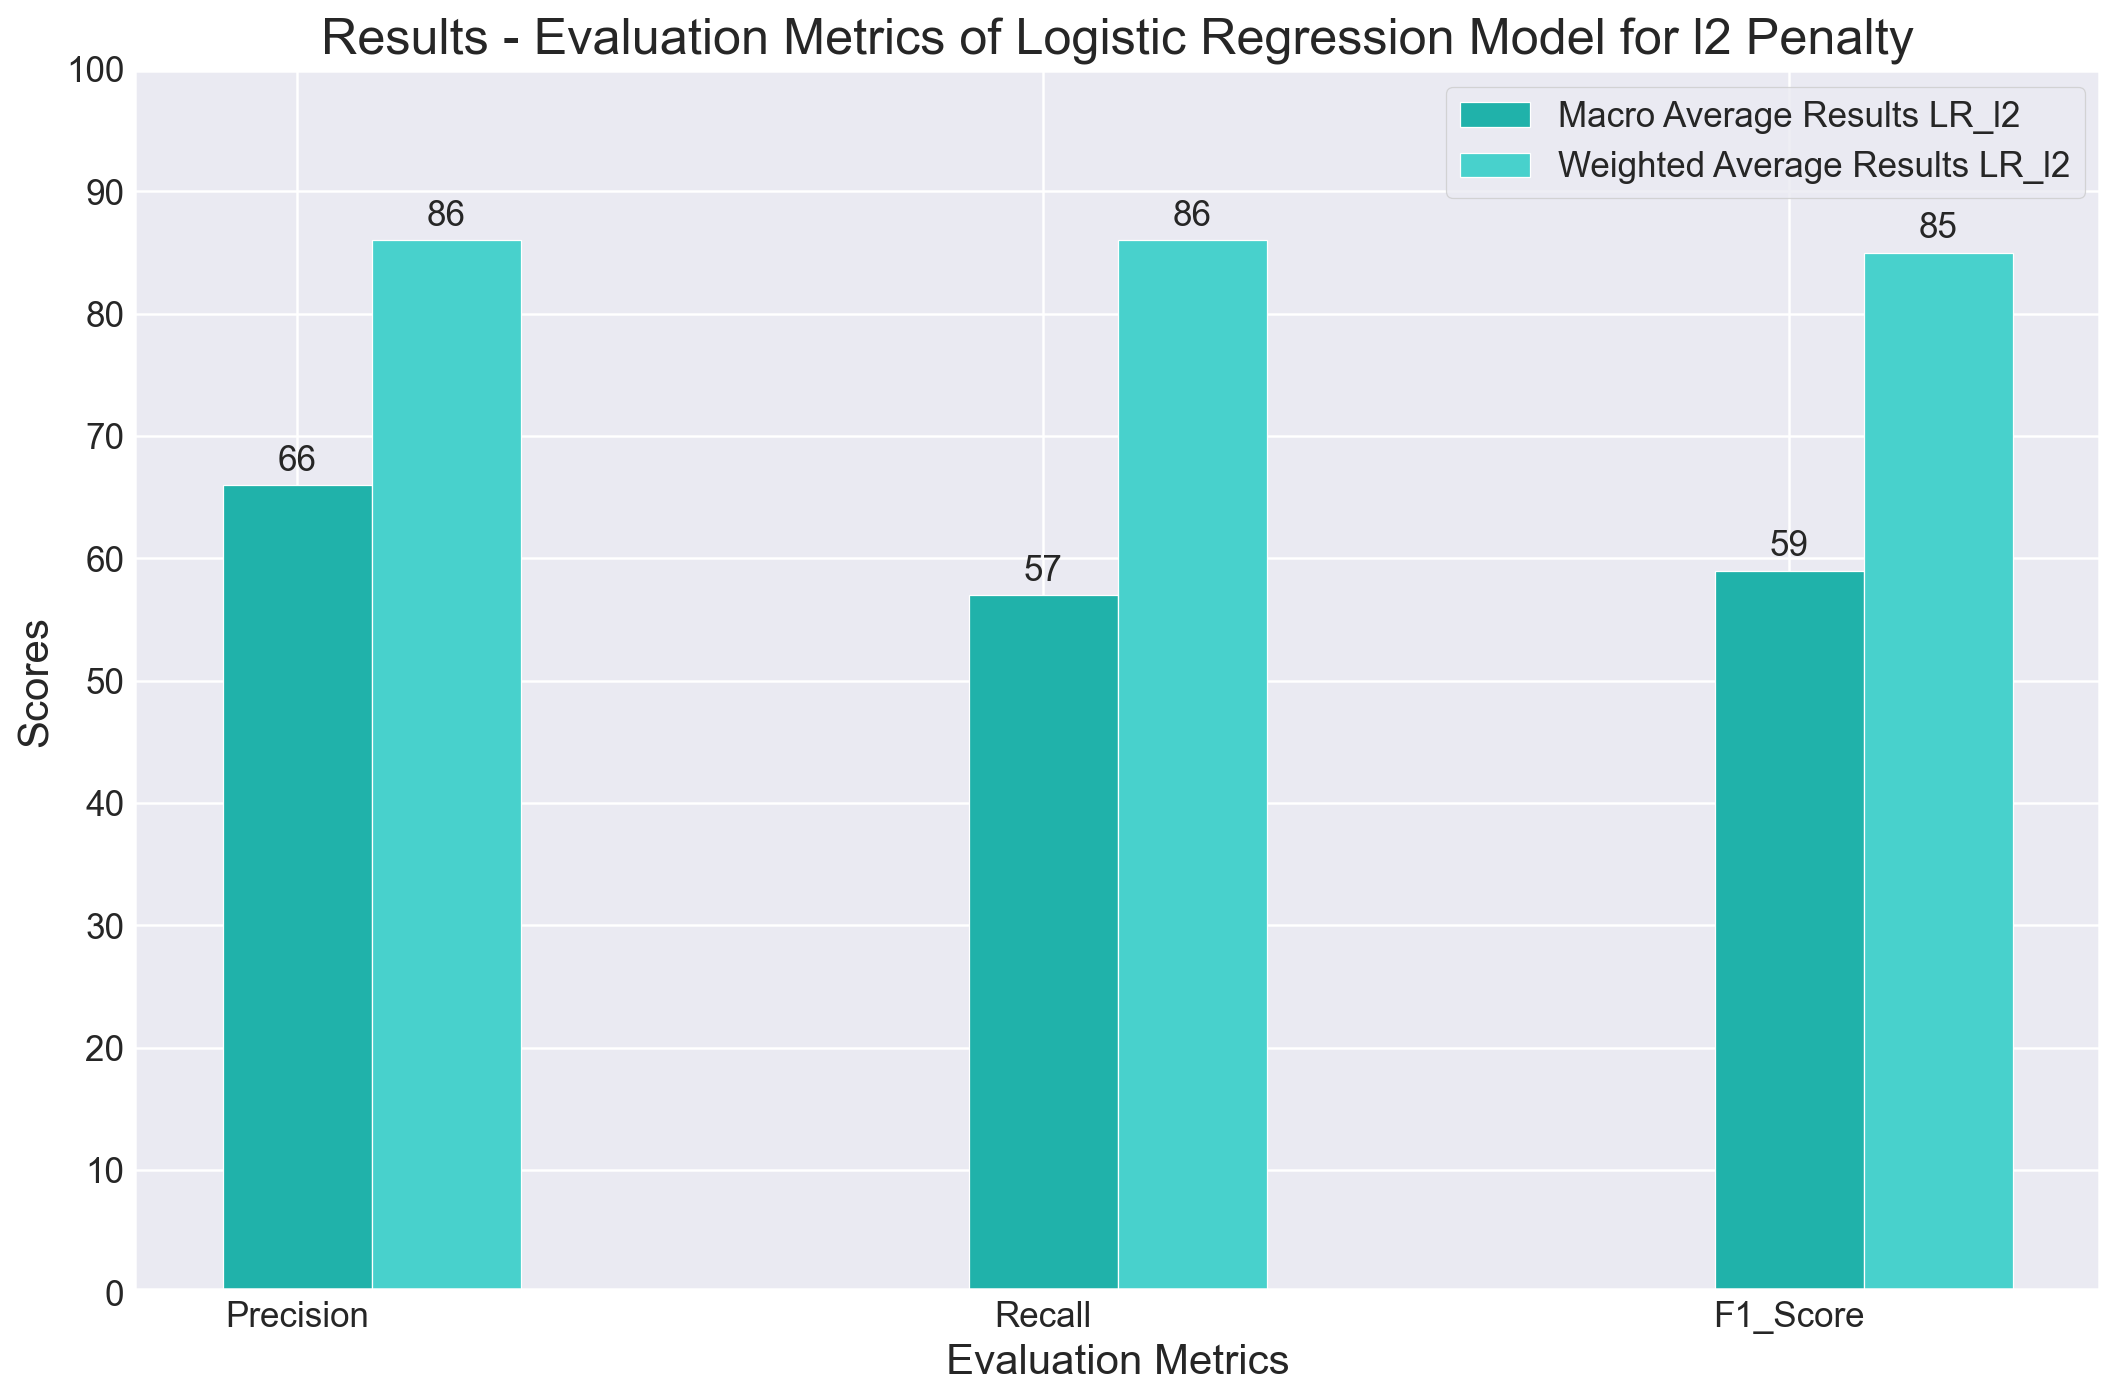

In [448]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Precision', 'Recall', 'F1_Score']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Macro_Average_Results = [66, 57, 59]
Weighted_Average_Results = [86, 86, 85]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
Macro_Average_Results_1 = ax.bar(indx, Macro_Average_Results, bar_width, label='Macro Average Results LR_l2',color = 'lightseagreen')
Weighted_Average_Results_1 = ax.bar(indx + bar_width, Weighted_Average_Results, bar_width, label='Weighted Average Results LR_l2',color = 'mediumturquoise')



# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Results - Evaluation Metrics of Logistic Regression Model for l2 Penalty')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Macro_Average_Results_1)
insert_data_labels(Weighted_Average_Results_1)

plt.tight_layout()
plt.show()

### Hyperparameter tuning using l1 penalty (logistic regression)

In [48]:
Valid_Scores_LRl2 = []
solvers = ['liblinear']
penalty = ['l2']

# Importing the required packages
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

c_values = [100, 10, 1.0, 0.1, 0.01]
for i in c_values:
    for j in solvers:
        lr = LogisticRegression(C = i, penalty = 'l1', solver = j)
        model9 = MultiOutputClassifier(estimator = lr)
        lr_model2 = model9.fit(xtrain, Y_train)
        Valid_Scores_LRl2.append(lr_model2.score(xvalid, Y_valid))
        print("For C =",i,'Solver = ',j,"Train_Score = ", 
              lr_model2.score(xtrain, Y_train),"Valid_Score = ",lr_model2.score(xvalid, Y_valid))
    print('==============================================')

For C = 100 Solver =  liblinear Train_Score =  0.9984745245601546 Valid_Score =  0.7981189116560296
For C = 10 Solver =  liblinear Train_Score =  0.9951184785924947 Valid_Score =  0.7924084648975479
For C = 1.0 Solver =  liblinear Train_Score =  0.7662971626156819 Valid_Score =  0.7044004030903595
For C = 0.1 Solver =  liblinear Train_Score =  0.42062442794671007 Valid_Score =  0.41988579106483037
For C = 0.01 Solver =  liblinear Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599


### Printing the Validation Scores of l1 Penalty

In [49]:
Valid_Scores_LR2 = []
for i in Valid_Scores_LRl2:
    Valid_Scores_LR2.append(round(i * 100, 2))
    
Valid_Scores_LR2

[79.81, 79.24, 70.44, 41.99, 31.71]

### Plotting the Validation Scores of l1 Penalty


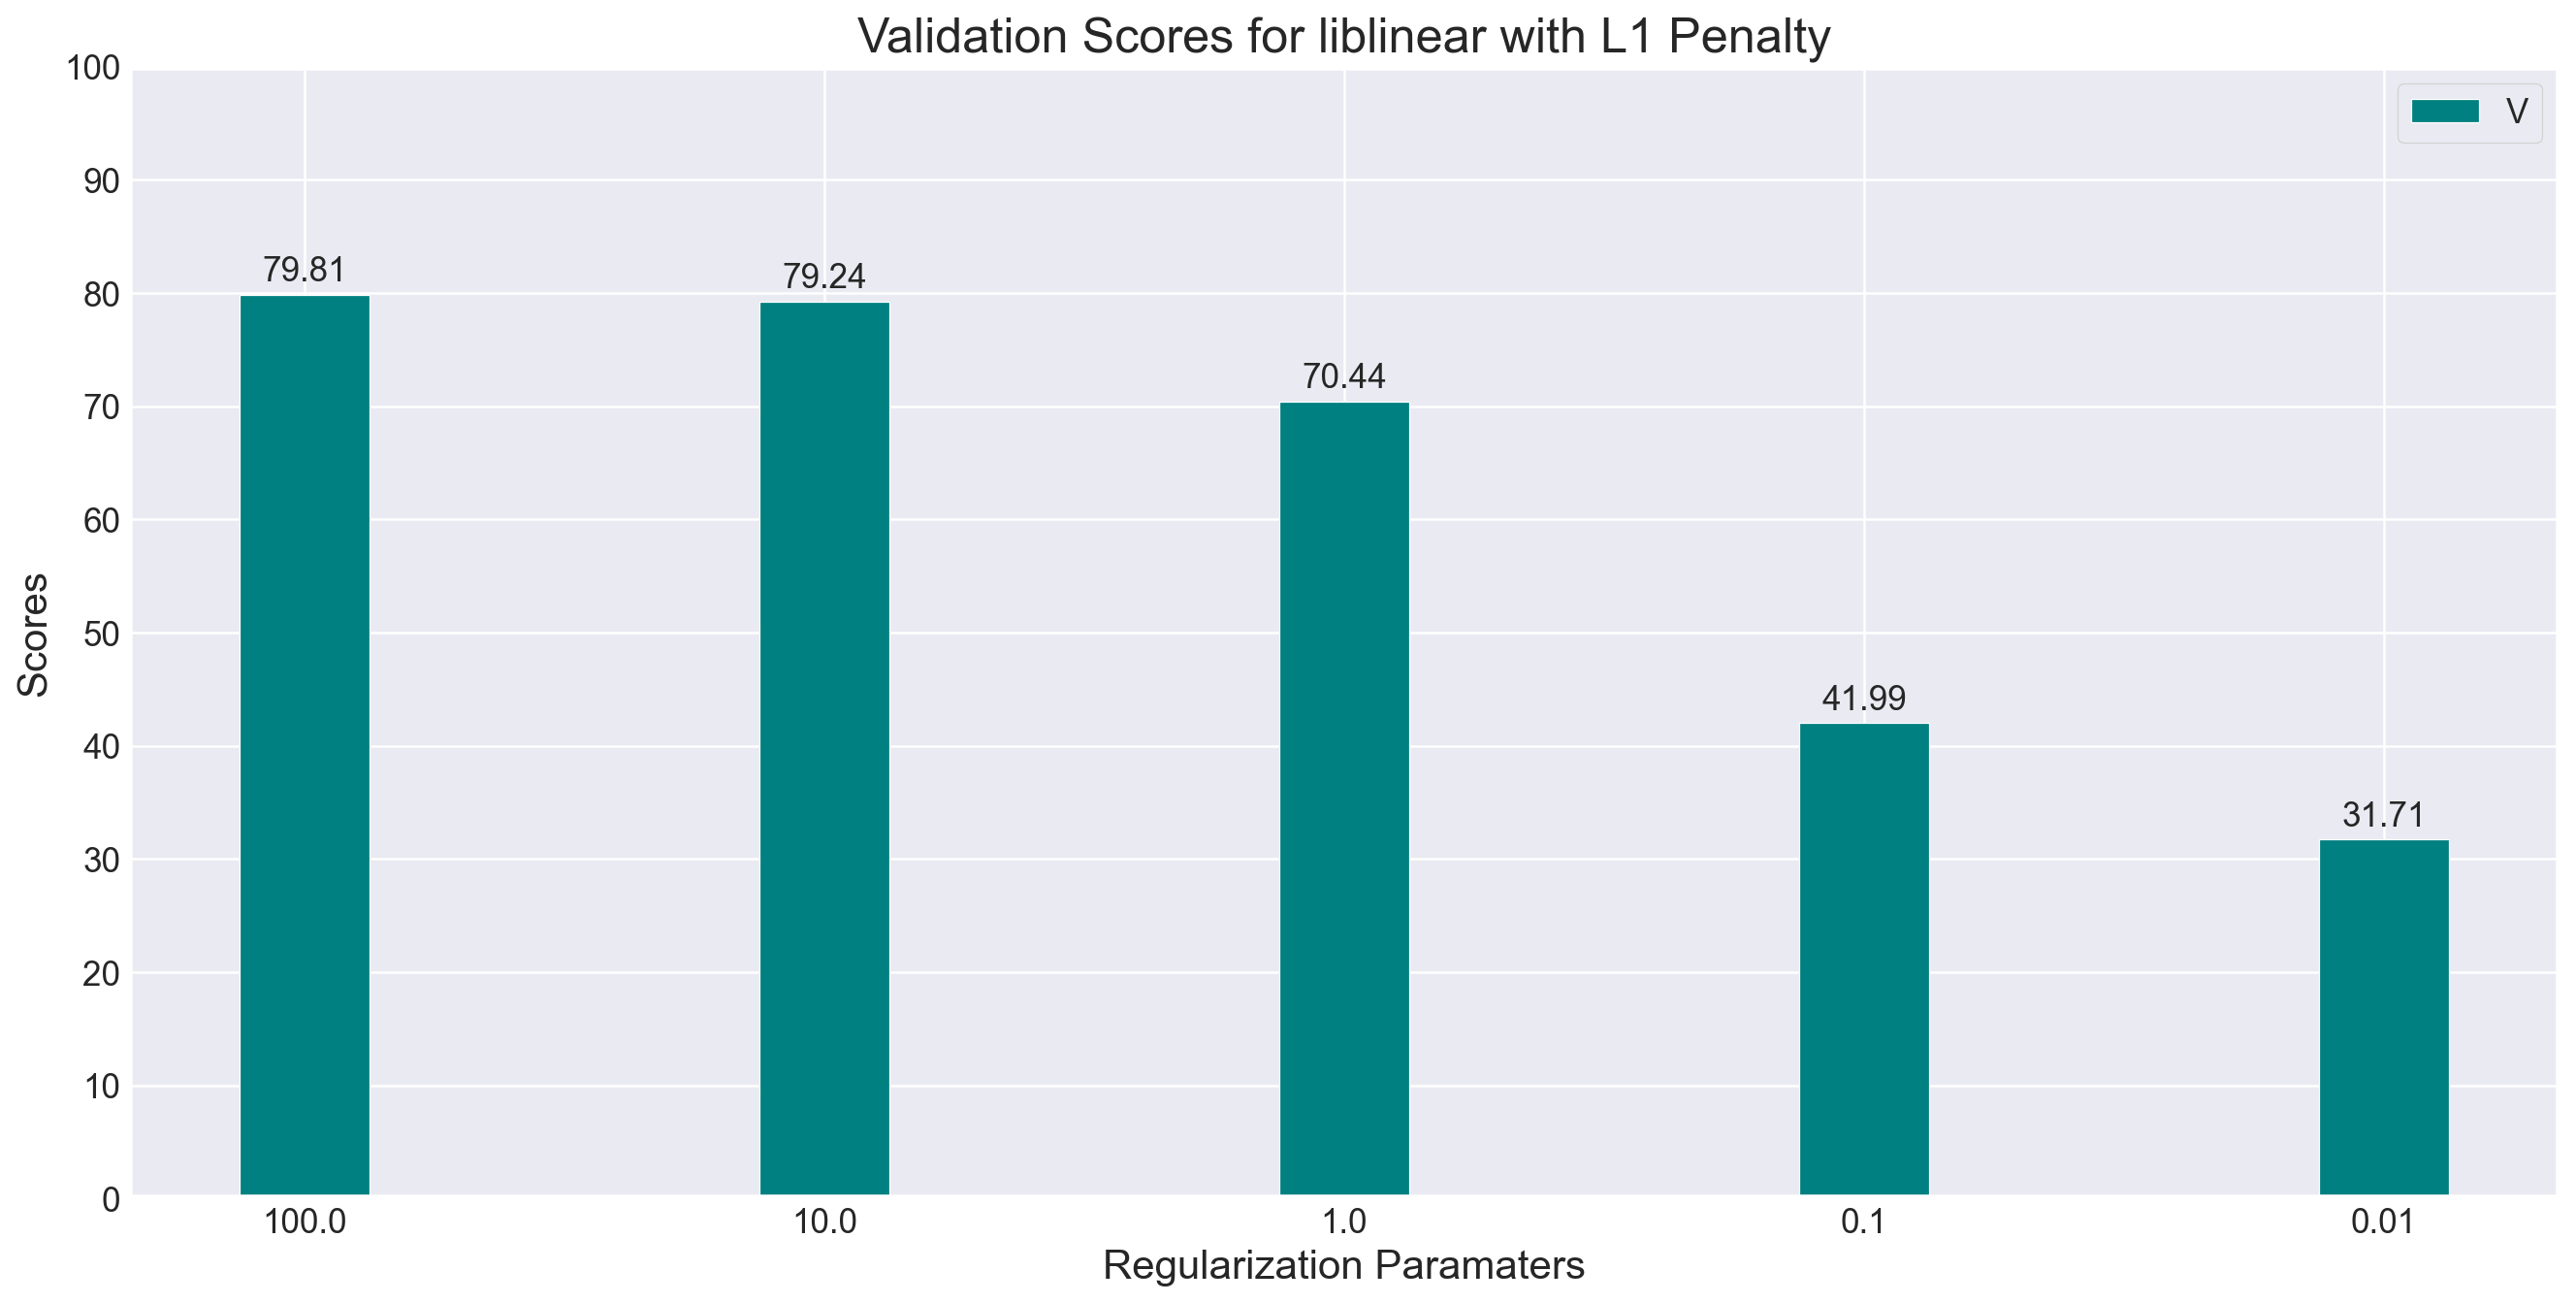

In [50]:
import matplotlib.pyplot as plt
import numpy as np

score_label = np.arange(0, 110, 10)

x = [100, 10, 1.0, 0.1, 0.01]
y = Valid_Scores_LR2

fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.subplots()

xx = np.arange(len(Valid_Scores_LR2)) # the label locations
width = 0.25 # the width of the bars

#plt.xticks(rotation='vertical')

pps = ax.bar(xx - width/2, y, width, tick_label= x,color = 'teal')
#plt.xticks(rotation='vertical')

ax.set_ylabel('Scores')
ax.set_xlabel('Regularization Paramaters')
ax.legend(labels= 'Validation Scores')
ax.set_title('Validation Scores for liblinear with L1 Penalty')


ax.set_yticks(score_label)
ax.set_yticklabels(score_label)



for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()

### Ensembling Support Vector Classifier with default parameters into Multi Output Classifier

In [524]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

SVC00 = SVC()
model_svc_00 = MultiOutputClassifier(estimator = SVC00)
svc00_model = model_svc_00.fit(xtrain, Y_train)
print("Train_Score = ", svc00_model.score(xtrain, Y_train),"Valid_Score = ",svc00_model.score(xvalid, Y_valid),
      "Test_Score = ", svc00_model.score(xtestdf1, Y_test_df1))

Train_Score =  0.9335909691853961 Valid_Score =  0.6603963721867652 Test_Score =  0.625725338491296


### Hyperparameter Tuning for SVC

In [52]:
from sklearn.svm import SVC

svc_2 = []
c_values = [0.001,0.01, 0.1, 1, 3, 5, 10]
kernel = ['linear','poly', 'rbf','sigmoid']
for i in c_values:
    for j in kernel:
        clf3 = SVC(C=i,kernel = j, random_state = 0)
        model3_3 = MultiOutputClassifier(estimator=clf3)
        svc_clf3 = model3_3.fit(xtrain, Y_train)
        svc_2.append(svc_clf3.score(xvalid, Y_valid))

        print("C = ",i, 'kernel =', j, 'Train_Score = ',svc_clf3.score(xtrain, Y_train),
             'Valid_Score = ',svc_clf3.score(xvalid, Y_valid))
    print('==============================================')    

C =  0.001 kernel = linear Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.001 kernel = poly Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.001 kernel = rbf Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.001 kernel = sigmoid Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.01 kernel = linear Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.01 kernel = poly Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.01 kernel = rbf Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.01 kernel = sigmoid Train_Score =  0.3225872063459778 Valid_Score =  0.3170977494121599
C =  0.1 kernel = linear Train_Score =  0.4380148479609478 Valid_Score =  0.42358078602620086
C =  0.1 kernel = poly Train_Score =  0.32624834740160685 Valid_Score =  0.3197850184749748
C =  0.1 kernel = rbf Train_Score =  0.3638767415844605 Valid_Scor

###  Printing the Validation Scores for SVC

In [54]:
svc_22 = []
for i in svc_2:
    svc_22.append(round(i * 100, 2))
    
svc_22

[31.71,
 31.71,
 31.71,
 31.71,
 31.71,
 31.71,
 31.71,
 31.71,
 42.36,
 31.98,
 35.61,
 41.55,
 77.23,
 45.68,
 66.04,
 75.95,
 79.68,
 49.41,
 72.02,
 80.85,
 79.61,
 49.41,
 72.02,
 80.58,
 79.64,
 49.41,
 72.02,
 80.32]

###  Plotting the Validation Scores for SVC

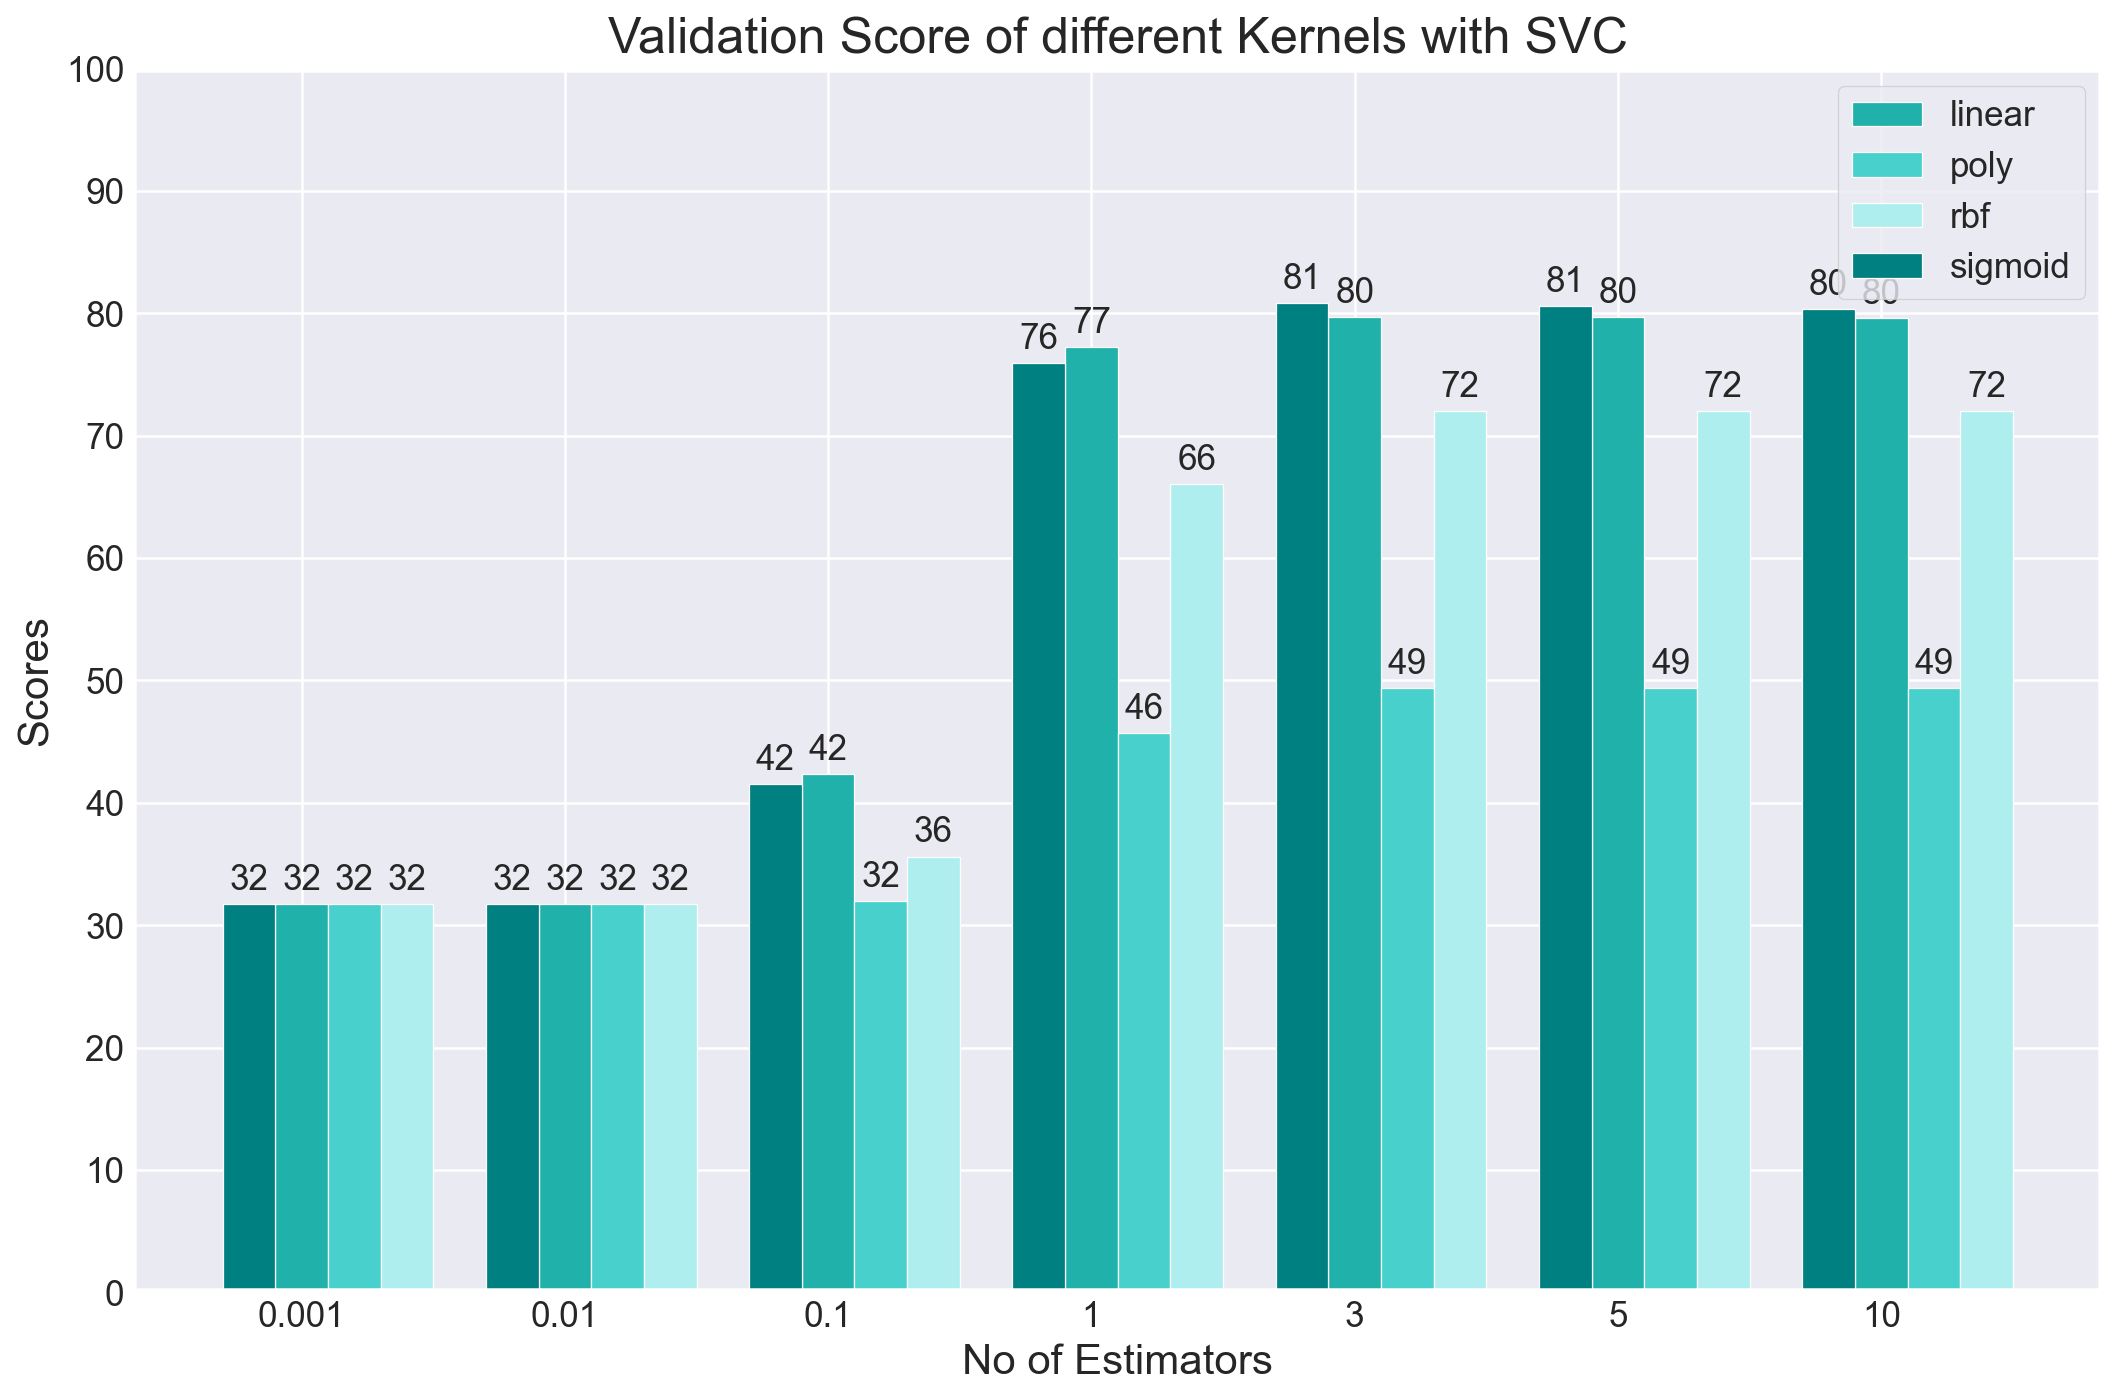

In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

c_val = [0.001, 0.01, 0.1, 1, 3, 5, 10]


indx = np.arange(len(c_val))
score_label = np.arange(0, 110, 10)
linear = [31.71, 31.71, 42.36, 77.23, 79.68,  79.68, 79.64]
poly = [31.71, 31.71, 31.98, 45.68, 49.41, 49.41, 49.41]
rbf = [31.71, 31.71, 35.61, 66.04, 72.02, 72.02, 72.02]
sigmoid = [31.71, 31.71, 41.55, 75.95, 80.85,  80.58, 80.32]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
linear_1 = ax.bar(indx - bar_width+0.4/2, linear, bar_width, label='linear',color = 'lightseagreen')
poly_1 = ax.bar(indx + bar_width * 2/2, poly, bar_width, label='poly',color = 'mediumturquoise')
rbf_1 = ax.bar(indx + bar_width * 4/2, rbf, bar_width, label='rbf',color = 'paleturquoise')
sigmoid_1 = ax.bar(indx - bar_width * 2/2, sigmoid, bar_width, label='sigmoid',color = 'teal')


# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(c_val)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('No of Estimators')
ax.set_title('Validation Score of different Kernels with SVC')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(bar.get_height()),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(linear_1)
insert_data_labels(poly_1)
insert_data_labels(rbf_1)
insert_data_labels(sigmoid_1)
plt.tight_layout()
plt.show()


### Finalising the best parameter in SVC

In [56]:
svc_1 = []
m = [1, 3, 5, 10]
kernel = ['sigmoid']
for i in m:
    for j in kernel:
        clf2 = SVC(C=i, kernel = j, random_state = 0)
        model3 = MultiOutputClassifier(estimator = clf2)
        svc_clf2 = model3.fit(xtrain, Y_train)
        svc_1.append(svc_clf2.score(xvalid, Y_valid))

        print("c = ", i, 'Kernel = ', j, "Train_Score = ", svc_clf2.score(xtrain, Y_train),
                  "Valid_Score = ",svc_clf2.score(xvalid, Y_valid))
    print('==============================================')

c =  1 Kernel =  sigmoid Train_Score =  0.8945387979253534 Valid_Score =  0.7594894188780652
c =  3 Kernel =  sigmoid Train_Score =  0.981694294721855 Valid_Score =  0.8085320792744374
c =  5 Kernel =  sigmoid Train_Score =  0.9871860063052985 Valid_Score =  0.8058448102116225
c =  10 Kernel =  sigmoid Train_Score =  0.990135258822333 Valid_Score =  0.8031575411488076


### Validation Scores of finalised  best parameter in SVC

In [58]:
svc_11 =[]
for i in svc_1:
    svc_11.append(round(i * 100, 2))
    
svc_11

[75.95, 80.85, 80.58, 80.32]

### Plotting Validation Scores of finalised  best parameter in SVC

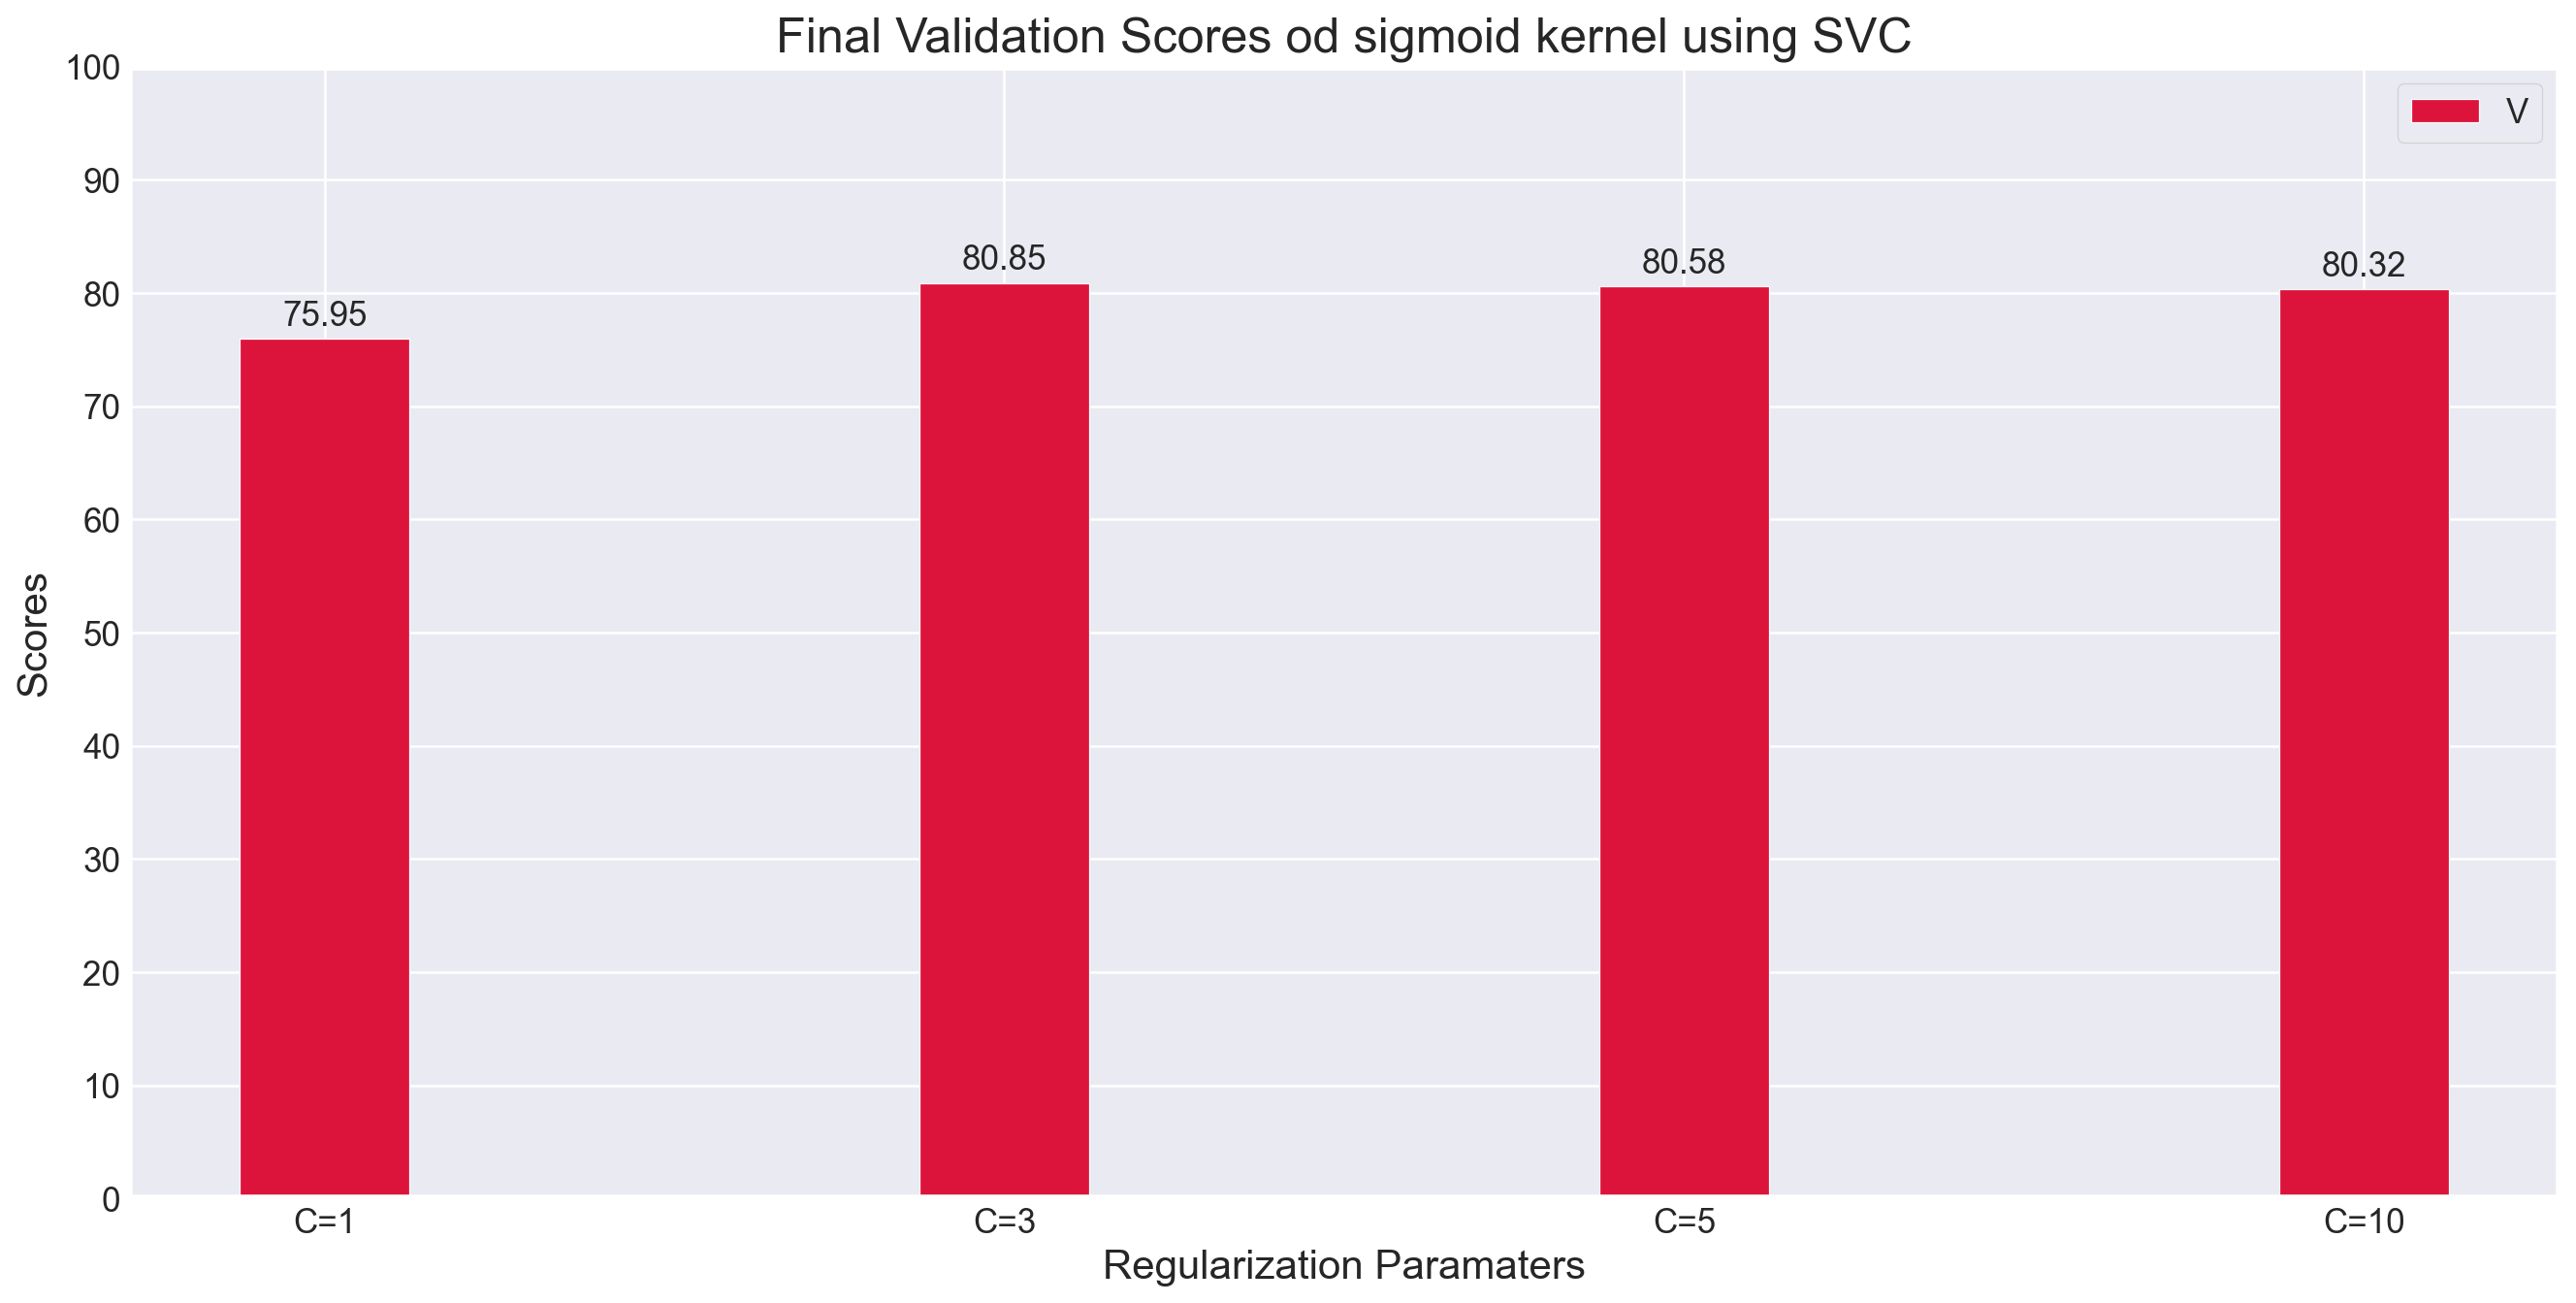

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x = ['C=1','C=3','C=5','C=10']
y = svc_11

fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.subplots()

xx = np.arange(len(svc_11)) # the label locations
width = 0.25 # the width of the bars

#plt.xticks(rotation='vertical')

pps = ax.bar(xx - width/2, y, width, tick_label= x,color = 'crimson')
#plt.xticks(rotation='vertical')
ax.set_ylabel('Scores')
ax.set_xlabel('Regularization Paramaters')
ax.legend(labels= 'Validation Scores')
ax.set_title('Final Validation Scores od sigmoid kernel using SVC')
score_label = np.arange(0, 110, 10)
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()


### Printing the directories of SVC

In [60]:
dir(svc_clf2)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_validate_data',
 'classes_',
 'estimator',
 'estimators_',
 'fit',
 'get_params',
 'n_features_in_',
 'n_jobs',
 'partial_fit',
 'predict',
 'predict_proba',
 'score',
 'set_params']

### Finalising the best parameter in SVC

In [61]:
from sklearn.svm import SVC
Final_clf = SVC(C=3, kernel = 'sigmoid', random_state = 0, probability=True)
Final_model = MultiOutputClassifier(estimator = Final_clf)
Final_SVC_clf = Final_model.fit(xtrain, Y_train)
print('Kernel = ', kernel, "Train_Score = ", Final_SVC_clf.score(xtrain, Y_train),
                  "Valid_Score = ",Final_SVC_clf.score(xvalid, Y_valid))

Kernel =  ['sigmoid'] Train_Score =  0.981694294721855 Valid_Score =  0.8085320792744374


### Printing the test score of finalised model in SVC

In [62]:
test_df1_score = Final_SVC_clf.score(xtestdf1, Y_test_df1)
print(test_df1_score)

0.7843326885880078


### Predicting the public test data using SVC 

In [63]:
test_df2_predict = Final_SVC_clf.predict(xtestdf2)
print(test_df2_predict)

[['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars']
 ['67000000_Clothing' '67010000_Clothing' '67010700_Underwear']
 ...
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories']
 ['75000000_Household/Office Furniture/Furnishings'
  '75010000_Household/Office Furniture'
  '75010300_Household/Office Tables/Desks']]


### Predicting the probabilities of public test data using SVC 

In [64]:
test_df2_predicted_proba = Final_SVC_clf.predict_proba(xtestdf2)
test_df2_predicted_proba

[array([[1.32159788e-04, 1.05597428e-04, 8.76145758e-05, ...,
         6.86019767e-05, 7.63983824e-05, 7.90554667e-05],
        [2.64259134e-03, 1.28275531e-03, 1.26887685e-03, ...,
         4.82301019e-04, 3.80934852e-04, 2.59728725e-04],
        [5.06510066e-04, 2.80801349e-04, 9.00067938e-04, ...,
         1.22850463e-04, 1.38479273e-04, 5.93967201e-05],
        ...,
        [4.09277499e-05, 3.94994327e-05, 7.09930980e-05, ...,
         1.93539336e-05, 1.64221409e-05, 1.90930123e-05],
        [7.75333562e-05, 4.39582826e-04, 9.72751805e-05, ...,
         3.52908205e-05, 1.25866784e-04, 1.62556348e-05],
        [2.79555174e-03, 2.75259513e-03, 1.19697440e-03, ...,
         9.25081090e-04, 2.51218821e-04, 2.91030682e-04]]),
 array([[2.55069436e-04, 5.47603225e-05, 1.63817465e-04, ...,
         3.95799166e-05, 1.42171091e-05, 3.03640961e-05],
        [6.10048939e-03, 1.06939649e-03, 1.57183168e-03, ...,
         3.22954152e-04, 3.52652310e-04, 4.66997833e-04],
        [5.37684684e-04, 

### Putting all together the Predicted Values and their Probabilities of SVC

In [66]:
prob = []
predict = []
target = []
max_prob = []
for i in range(test_df2.shape[0]):
    
    prob.append([test_df2_predicted_proba[0][i].max(),
                 test_df2_predicted_proba[1][i].max(),
                 test_df2_predicted_proba[2][i].max()])
    predict.append(test_df2_predict[i])
    target.append(test_df2_predict[i][np.argmax(prob[i])])
    max_prob.append(max([test_df2_predicted_proba[0][i].max(),
                         test_df2_predicted_proba[1][i].max(),
                         test_df2_predicted_proba[2][i].max()]))
    
    print(test_df2_predict[i], [test_df2_predicted_proba[0][i].max(),
                                test_df2_predicted_proba[1][i].max(),
                                test_df2_predicted_proba[2][i].max()],
          test_df2_predict[i][np.argmax(prob[i])])

['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops'] [0.9810508570076909, 0.9768485760116935, 0.5374493110862798] 67000000_Clothing
['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars'] [0.9089774584585071, 0.6196264301706204, 0.2862572349760093] 77000000_Automotive
['67000000_Clothing' '67010000_Clothing' '67010700_Underwear'] [0.9675414665021361, 0.9596138577151005, 0.4005044018332663] 67000000_Clothing
['75000000_Household/Office Furniture/Furnishings'
 '75010000_Household/Office Furniture' '75010200_Household/Office Seating'] [0.9061779476254825, 0.7782572260804995, 0.14321452822800335] 75000000_Household/Office Furniture/Furnishings
['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories'] [0.9346318995297157, 0.9198843146347819, 0.06527647931969793] 67000000_Clothing
['10000000_Pet Care/Food' '10100000_Pet Care' '10101700_Pet Accessories'] [0.25615035264244046, 0.17870511603032158, 0.09440949988799308] 10000000_Pet Care/Food


IndexError: index 3102 is out of bounds for axis 0 with size 3102

 ### Actual Target columns of each level

In [297]:
actual_lvl1_svc = Y_test_df1.iloc[:,0].to_numpy()
actual_lvl2_svc = Y_test_df1.iloc[:,1].to_numpy()
actual_lvl3_svc = Y_test_df1.iloc[:,2].to_numpy()

 ### Predicted Target columns of each level

In [298]:
predicted_lvl1_svc = test_df2_predict[:,0]
predicted_lvl2_svc = test_df2_predict[:,1]
predicted_lvl3_svc = test_df2_predict[:,2]

###  Calculating the Level 1 Classification Report of SVC

In [299]:
print(classification_report(actual_lvl1_svc, predicted_lvl1_svc))

                                                        precision    recall  f1-score   support

                                10000000_Pet Care/Food       0.94      0.91      0.92        88
                    47000000_Cleaning/Hygiene Products       0.76      0.70      0.73        27
                        50000000_Food/Beverage/Tobacco       0.88      0.84      0.86        80
                                   51000000_Healthcare       0.86      0.84      0.85        70
                 53000000_Beauty/Personal Care/Hygiene       0.73      0.73      0.73        41
                                    54000000_Baby Care       0.62      0.56      0.59         9
          60000000_Textual/Printed/Reference Materials       0.73      0.90      0.80        50
                                        61000000_Music       1.00      0.91      0.95        22
62000000_Stationery/Office Machinery/Occasion Supplies       0.92      0.67      0.77        51
                                     63

###  Calculating the Level 2 Classification Report of SVC

In [300]:
print(classification_report(actual_lvl2_svc, predicted_lvl2_svc))

                                                                      precision    recall  f1-score   support

                                                   10100000_Pet Care       0.88      0.94      0.91        82
                                            10110000_Pet Food/Drinks       1.00      0.67      0.80         6
                                          47100000_Cleaning Products       0.65      0.68      0.67        19
                               47120000_Insect/Pest/Allergen Control       1.00      0.88      0.93         8
            50100000_Fruits/Vegetables/Nuts/Seeds Prepared/Processed       0.50      0.33      0.40         6
          50130000_Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes       0.00      0.00      0.00         1
                                           50150000_Oils/Fats Edible       1.00      0.14      0.25         7
                    50160000_Confectionery/Sugar Sweetening Products       0.60      0.75      0.67         4
         

###  Calculating the Level 3 Classification Report of SVC

In [301]:
print(classification_report(actual_lvl3_svc, predicted_lvl3_svc))

                                                                      precision    recall  f1-score   support

                                        10101500_Pet Welfare/Hygiene       0.78      0.70      0.74        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.57      0.93      0.70        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                                   10111600_Pet Food       1.00      0.67      0.80         6
                                     47101500_Fresheners/Deodorisers       0.00      0.00      0.00         1
                                                   47101600_Cleaners       0.60      0.71      0.65        17
                                                    47101700_Laundry       1.00      1.00      1.00         1
         

### Sublist of all three Actual Target Column 

In [70]:
flatten_list1 = [element for sublist in Y_test_df1.to_numpy() for element in sublist]
len(flatten_list1)

9306

### Sublist of all three Predicted Target Column 

In [71]:
flatten_list2 = [element for sublist in test_df2_predict for element in sublist]
len(flatten_list2)

9306

###  Combining all  3 levels - Classification Report of SVC

In [91]:
print(classification_report(flatten_list1, flatten_list2))

                                                                      precision    recall  f1-score   support

                                              10000000_Pet Care/Food       0.94      0.91      0.92        88
                                                   10100000_Pet Care       0.88      0.94      0.91        82
                                        10101500_Pet Welfare/Hygiene       0.78      0.70      0.74        10
                                10101600_Pet Nutritional Supplements       0.00      0.00      0.00         1
                                            10101700_Pet Accessories       0.57      0.93      0.70        69
                                     10101800_Pet Care Variety Packs       0.00      0.00      0.00         2
                                            10110000_Pet Food/Drinks       1.00      0.67      0.80         6
                                                   10111600_Pet Food       1.00      0.67      0.80         6
         

### Macro Average Results for SVC Model

In [304]:
macro_avg_svc = [[0.79, 0.70, 0.73], [0.74, 0.64, 0.66], [0.63, 0.54, 0.56],[0.67, 0.58, 0.60]]
Results_Macro_Average_svc = pd.DataFrame(macro_avg_svc,index = ['macro_avg_svc_lvl1','macro_avg_svc_lvl2',
                                                        'macro_avg_svc_lvl3','Total_Macro_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Macro_Average_svc

Precision  Recall  F1_score
macro_avg_svc_lvl1       0.79    0.70      0.73
macro_avg_svc_lvl2       0.74    0.64      0.66
macro_avg_svc_lvl3       0.63    0.54      0.56
Total_Macro_AVG          0.67    0.58      0.60

### Weighted Average Results for SVC Model

In [305]:
weighted_avg_svc = [[0.88, 0.89, 0.88], [0.87, 0.88, 0.87], [0.80, 0.81, 0.79],[0.85, 0.86, 0.85]]
Results_Weighted_Average_svc = pd.DataFrame(weighted_avg_svc,index = ['weighted_avg_svc_lvl1','weighted_avg_svc_lvl2',
                                                        'weighted_avg_svc_lvl3','Total_Weighted_AVG'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Weighted_Average_svc

Precision  Recall  F1_score
weighted_avg_svc_lvl1       0.88    0.89      0.88
weighted_avg_svc_lvl2       0.87    0.88      0.87
weighted_avg_svc_lvl3       0.80    0.81      0.79
Total_Weighted_AVG          0.85    0.86      0.85

### Plotting the Evaluation Metrics of SVC

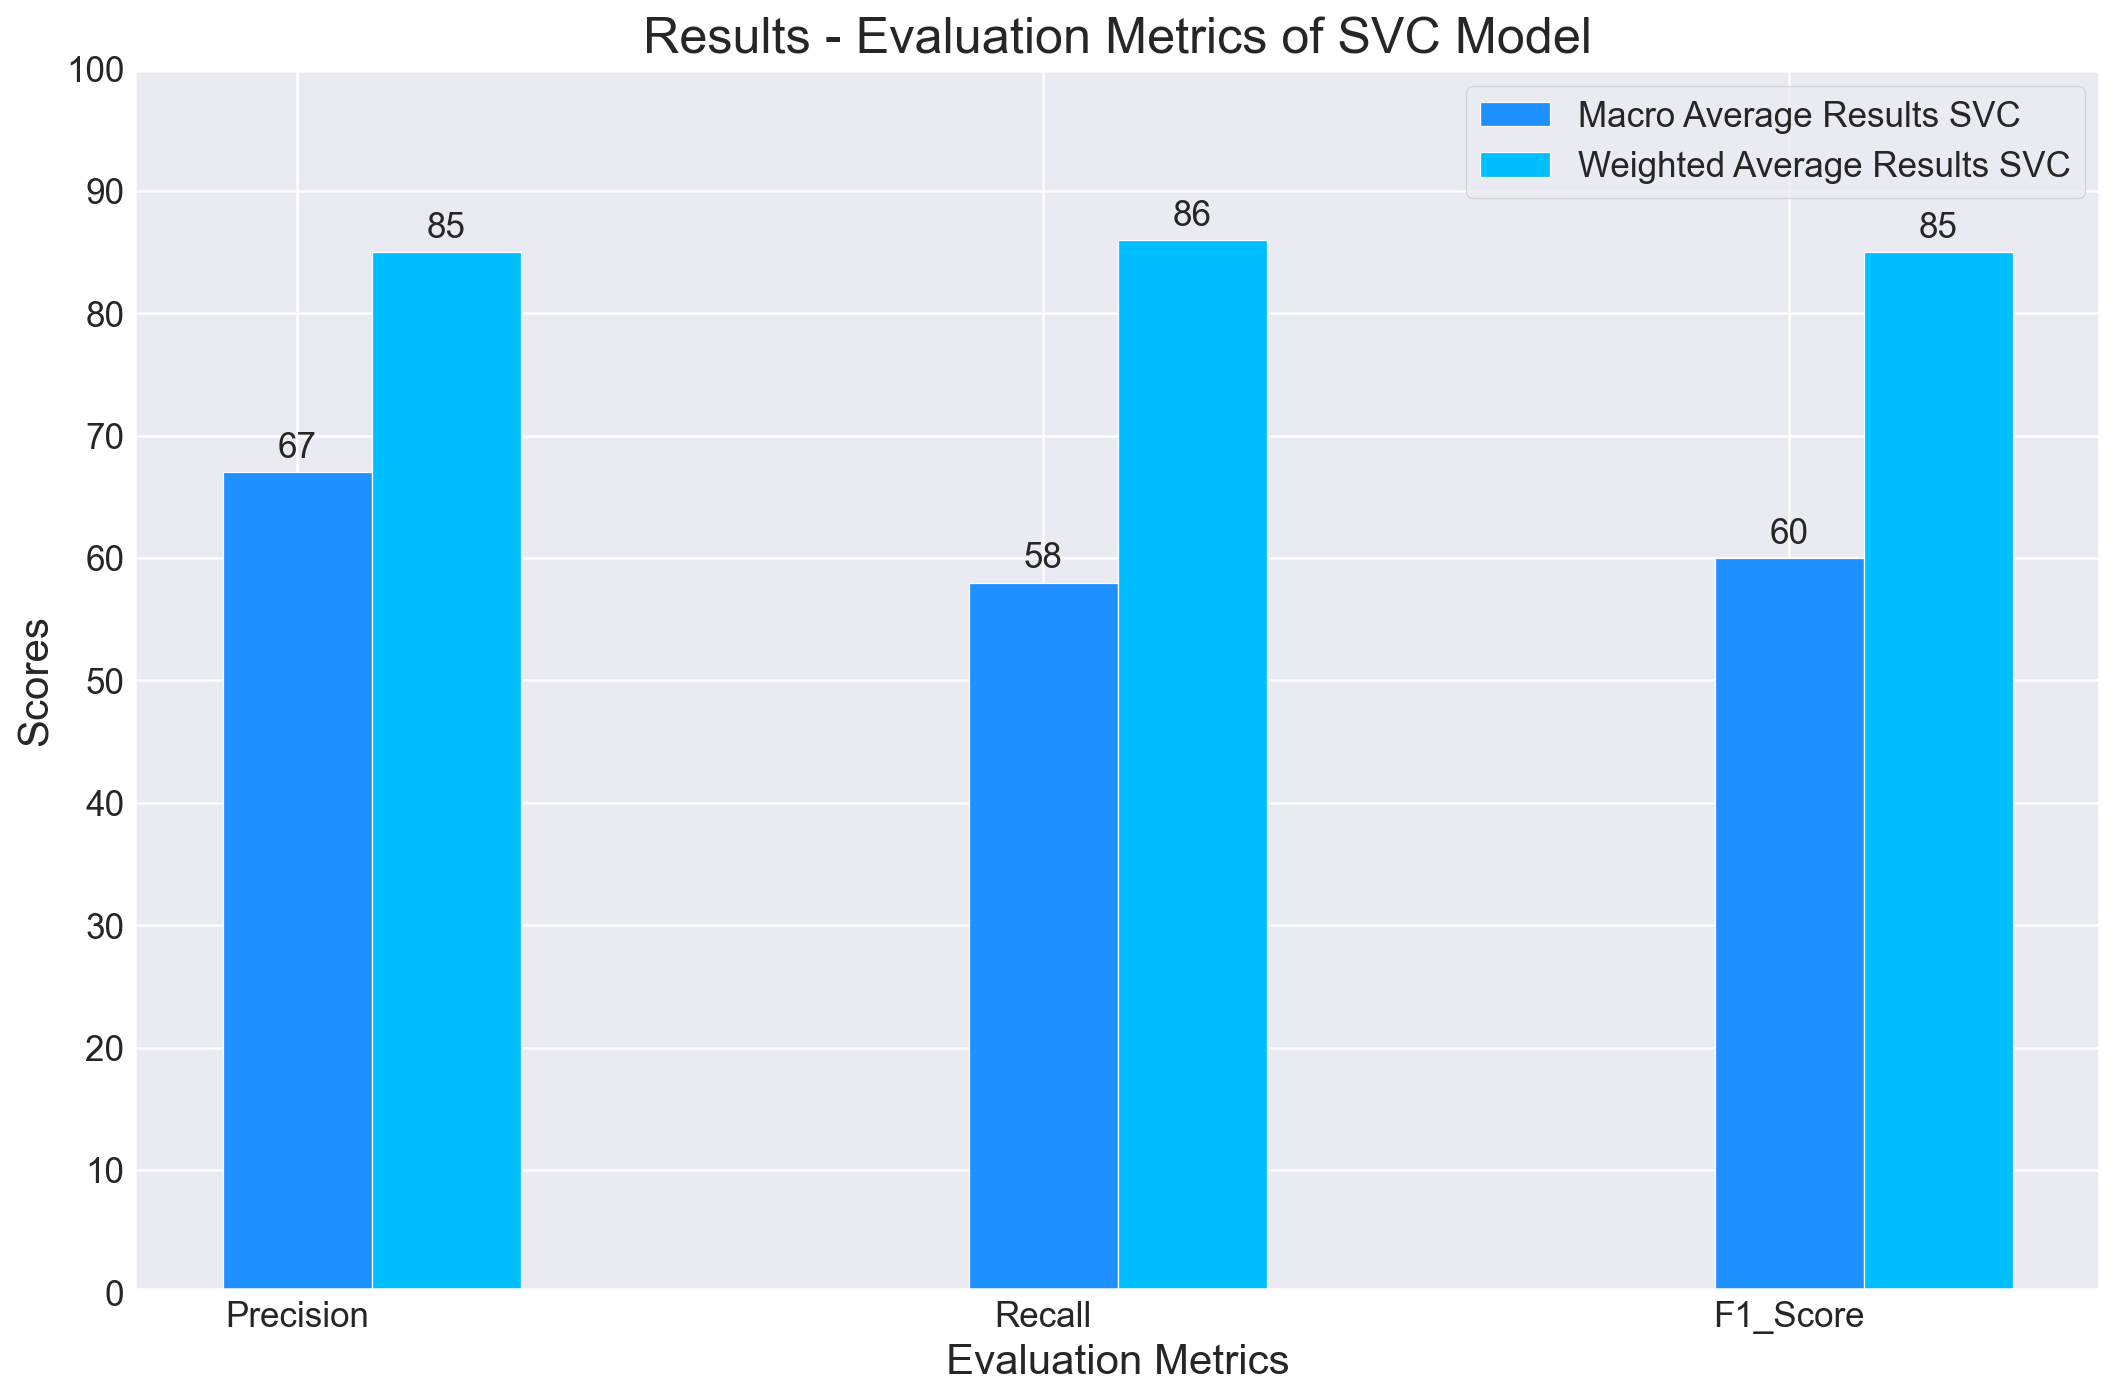

In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Precision', 'Recall', 'F1_Score']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Macro_Average_Results = [67, 58, 60]
Weighted_Average_Results = [85, 86, 85]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 180)
Macro_Average_Results_1 = ax.bar(indx, Macro_Average_Results, bar_width, 
                                 label='Macro Average Results SVC',color = 'dodgerblue')
Weighted_Average_Results_1 = ax.bar(indx + bar_width, Weighted_Average_Results, bar_width, 
                                    label='Weighted Average Results SVC',color = 'deepskyblue')



# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Scores')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Results - Evaluation Metrics of SVC Model')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Macro_Average_Results_1)
insert_data_labels(Weighted_Average_Results_1)

plt.tight_layout()
plt.show()

### Printing the Probabilities of all three levels of SVC in a Data Frame

In [73]:
prob_df = pd.DataFrame(prob,columns = ['LVL_1_Probability','LVL_2_Probability','LVL_3_Probability'])
predict_df = pd.DataFrame(predict, columns = ['Predicted_LVL_1','Predicted_LVL_2','Predicted_LVL_3'])
target_df = pd.DataFrame(target, columns= ['Final_Predicted_Level'])
max_prob_df = pd.DataFrame(max_prob, columns = ['Probabilty_of_Final_Predicted_Level'])
prob_df.head()

LVL_1_Probability  LVL_2_Probability  LVL_3_Probability
0           0.981051           0.976849           0.537449
1           0.908977           0.619626           0.286257
2           0.967541           0.959614           0.400504
3           0.906178           0.778257           0.143215
4           0.934632           0.919884           0.065276

### Printing the Actual Target Columns of all three levels in a Data Frame

In [74]:
actual_test_df = Y_test_df1.reset_index()
actual_test_df.drop('index', inplace = True, axis = 1)
actual_test_df

lvl1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                                     lvl2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                                   lvl3  
0                         67010800_Upper Body Wear/Tops  
1                                         77030100_Cars  
2                                    67010700_Underwear  
3                     75010200_Household/Office Seating  
4                         67010100_Clothing Accessories  
...                                                 ...  
3097                  73040200_Water/Beverage Equipment  
3098  51121600_Vitamins/Minerals/Nutritional Supplem...  
3099                      67010800_Upper Body Wear/Tops  
3100                      67010100_Clothing Accessories  
3101             75010300_Household/Office Tables/Desks  

[3102 rows x 3 columns]

### Final Public Test Results of SVC consisting All 3 levels Actual and Predicted Values with their Probabilities

In [75]:
final_df = pd.concat([actual_test_df,predict_df,prob_df, target_df,max_prob_df], axis = 1)
final_df

lvl1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                                     lvl2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                                   lvl3  \
0                         67010800_Upper Body Wear/Tops   
1                                         77030100_Cars   
2                                    67010700_Underwear   
3                     75010200_Household/Office Seating   
4                         67010100_Clothing Accessories   
...                                                 ...   
3097                  73040200_Water/Beverage Equipment   
3098  51121600_Vitamins/Minerals/Nutritional Supplem...   
3099                      67010800_Upper Body Wear/Tops   
3100                      67010100_Clothing Accessories   
3101             75010300_Household/Office Tables/Desks   

                                      Predicted_LVL_1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                          Predicted_LVL_2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                        Predicted_LVL_3  LVL_1_Probability  \
0                         67010800_Upper Body Wear/Tops           0.981051   
1                                         77030100_Cars           0.908977   
2                                    67010700_Underwear           0.967541   
3                     75010200_Household/Office Seating           0.906178   
4                         67010100_Clothing Accessories           0.934632   
...                                                 ...                ...   
3097                  73040200_Water/Beverage Equipment           0.944159   
3098  51121600_Vitamins/Minerals/Nutritional Supplem...           0.661781   
3099                      67010800_Upper Body Wear/Tops           0.994566   
3100                      67010100_Clothing Accessories           0.990965   
3101             75010300_Hous

### Predicting the Public Test Data using Logistic Regression

In [527]:
test_df2_predict_lr = lr_model1.predict(xtestdf2)
print(test_df2_predict_lr)

[['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars']
 ['67000000_Clothing' '67010000_Clothing' '67010700_Underwear']
 ...
 ['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']
 ['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories']
 ['75000000_Household/Office Furniture/Furnishings'
  '75010000_Household/Office Furniture'
  '75010300_Household/Office Tables/Desks']]


### Predicting the Probabilities of Public Test Data using Logistic Regression

In [528]:
test_df2_final_predicted_proba = lr_model1.predict_proba(xtestdf2)
test_df2_final_predicted_proba

[array([[3.01769013e-04, 1.50752955e-04, 2.41464504e-04, ...,
         1.54483166e-04, 1.08217555e-04, 1.44236506e-04],
        [2.41129562e-03, 3.55514717e-04, 5.77361932e-04, ...,
         1.91781549e-04, 9.70759777e-05, 9.74262006e-05],
        [1.68096326e-04, 1.83993031e-04, 7.97192550e-04, ...,
         9.70556904e-05, 9.58340839e-05, 8.78991271e-05],
        ...,
        [1.08267244e-04, 1.05162621e-04, 1.99255078e-04, ...,
         6.54220925e-05, 5.32506500e-05, 5.61581316e-05],
        [1.23946060e-04, 5.16826503e-04, 2.87008459e-04, ...,
         1.02101829e-04, 2.17016081e-04, 8.03835008e-05],
        [1.16738942e-03, 5.43220168e-04, 4.83245008e-04, ...,
         2.87226413e-04, 9.90541940e-05, 1.29750885e-04]]),
 array([[3.33625987e-04, 9.09531136e-05, 1.51907467e-04, ...,
         3.64977412e-05, 2.27649739e-05, 9.07650802e-05],
        [5.07907339e-03, 2.57743388e-04, 3.38262125e-04, ...,
         6.81316397e-05, 7.70430159e-05, 1.38069639e-04],
        [1.62958208e-04, 

### Putting all together the Predicted Values and their Probabilities of Logistic Regression

In [533]:
prob_f = []
predict_f = []
target_f = []
max_prob_f = []
for i in range(test_df2.shape[0]):
    
    prob_f.append([test_df2_final_predicted_proba[0][i].max(),
                 test_df2_final_predicted_proba[1][i].max(),
                 test_df2_final_predicted_proba[2][i].max()])
    predict_f.append(test_df2_predict_lr[i])
    target_f.append(test_df2_predict_lr[i][np.argmax(prob[i])])
    max_prob_f.append(max([test_df2_final_predicted_proba[0][i].max(),
                         test_df2_final_predicted_proba[1][i].max(),
                         test_df2_final_predicted_proba[2][i].max()]))
    
    print(test_df2_predict_lr[i], [test_df2_final_predicted_proba[0][i].max(),
                                test_df2_final_predicted_proba[1][i].max(),
                                test_df2_final_predicted_proba[2][i].max()],
          test_df2_predict_lr[i][np.argmax(prob[i])])

['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops'] [0.9526049502164178, 0.9505531531345366, 0.6974119448113649] 67000000_Clothing
['77000000_Automotive' '77030000_Cars and Motorcycles' '77030100_Cars'] [0.9538834426676901, 0.7959834164067653, 0.8423055902013789] 77000000_Automotive
['67000000_Clothing' '67010000_Clothing' '67010700_Underwear'] [0.9813493880081502, 0.9799311999528278, 0.8999001498547389] 67000000_Clothing
['75000000_Household/Office Furniture/Furnishings'
 '75010000_Household/Office Furniture' '75010200_Household/Office Seating'] [0.9473771165343795, 0.9419871342272238, 0.9458045413675137] 75000000_Household/Office Furniture/Furnishings
['67000000_Clothing' '67010000_Clothing' '67010100_Clothing Accessories'] [0.9777528214491792, 0.975180922598207, 0.7241743296163327] 67000000_Clothing
['10000000_Pet Care/Food' '10100000_Pet Care' '10101700_Pet Accessories'] [0.4405041944583053, 0.4563560378297956, 0.2140585240259627] 10000000_Pet Care/Food
['1000

IndexError: index 3102 is out of bounds for axis 0 with size 3102

### Printing the Probabilities of all three levels of Logistic Regression in a Data Frame

In [535]:
prob_df_lr = pd.DataFrame(prob_f,columns = ['LVL_1_Probability','LVL_2_Probability','LVL_3_Probability'])
predict_df_lr = pd.DataFrame(predict_f, columns = ['Predicted_LVL_1','Predicted_LVL_2','Predicted_LVL_3'])
target_df_lr = pd.DataFrame(target_f, columns= ['Final_Predicted_Level'])
max_prob_df_lr = pd.DataFrame(max_prob_f, columns = ['Probabilty_of_Final_Predicted_Level'])
prob_df_lr.head()

LVL_1_Probability  LVL_2_Probability  LVL_3_Probability
0           0.952605           0.950553           0.697412
1           0.953883           0.795983           0.842306
2           0.981349           0.979931           0.899900
3           0.947377           0.941987           0.945805
4           0.977753           0.975181           0.724174

### Printing the Actual Target Columns of all three levels in a Data Frame

In [537]:
original_test_df = Y_test_df1.reset_index()
original_test_df.drop('index', inplace = True, axis = 1)
original_test_df

lvl1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                                     lvl2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                                   lvl3  
0                         67010800_Upper Body Wear/Tops  
1                                         77030100_Cars  
2                                    67010700_Underwear  
3                     75010200_Household/Office Seating  
4                         67010100_Clothing Accessories  
...                                                 ...  
3097                  73040200_Water/Beverage Equipment  
3098  51121600_Vitamins/Minerals/Nutritional Supplem...  
3099                      67010800_Upper Body Wear/Tops  
3100                      67010100_Clothing Accessories  
3101             75010300_Household/Office Tables/Desks  

[3102 rows x 3 columns]

### Final Public Test Results of Logistic Regression consisting All 3 levels Actual and Predicted Values with their Probabilities

In [538]:
final_df_lr = pd.concat([original_test_df,predict_df_lr,prob_df_lr, target_df_lr,max_prob_df_lr], axis = 1)
final_df_lr

lvl1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                                     lvl2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                                   lvl3  \
0                         67010800_Upper Body Wear/Tops   
1                                         77030100_Cars   
2                                    67010700_Underwear   
3                     75010200_Household/Office Seating   
4                         67010100_Clothing Accessories   
...                                                 ...   
3097                  73040200_Water/Beverage Equipment   
3098  51121600_Vitamins/Minerals/Nutritional Supplem...   
3099                      67010800_Upper Body Wear/Tops   
3100                      67010100_Clothing Accessories   
3101             75010300_Household/Office Tables/Desks   

                                      Predicted_LVL_1  \
0                                   67000000_Clothing   
1                                 77000000_Automotive   
2                                   67000000_Clothing   
3     75000000_Household/Office Furniture/Furnishings   
4                                   67000000_Clothing   
...                                               ...   
3097                     73000000_Kitchen Merchandise   
3098                              51000000_Healthcare   
3099                                67000000_Clothing   
3100                                67000000_Clothing   
3101  75000000_Household/Office Furniture/Furnishings   

                          Predicted_LVL_2  \
0                       67010000_Clothing   
1           77030000_Cars and Motorcycles   
2                       67010000_Clothing   
3     75010000_Household/Office Furniture   
4                       67010000_Clothing   
...                                   ...   
3097         73040000_Kitchen Merchandise   
3098          51120000_Health Enhancement   
3099                    67010000_Clothing   
3100                    67010000_Clothing   
3101  75010000_Household/Office Furniture   

                                        Predicted_LVL_3  LVL_1_Probability  \
0                         67010800_Upper Body Wear/Tops           0.952605   
1                                         77030100_Cars           0.953883   
2                                    67010700_Underwear           0.981349   
3                     75010200_Household/Office Seating           0.947377   
4                         67010100_Clothing Accessories           0.977753   
...                                                 ...                ...   
3097                  73040200_Water/Beverage Equipment           0.912321   
3098  51121600_Vitamins/Minerals/Nutritional Supplem...           0.854550   
3099                      67010800_Upper Body Wear/Tops           0.995127   
3100                      67010100_Clothing Accessories           0.987965   
3101             75010300_Hous

In [554]:
cleaned_test_df2.iloc[0,0]

'alpinestars winter tech performance top product description alpinestars winter tech performance top automatic translation original description available here alpinestars winter tech performance top is part of alpinestars range of base layer underwear developed for providing core temperature regulation  dual density layers provide extra moisture wicking to keep the body comfortablefeatures   developed for cold weather riding conditions with double density fabric covering the most exposed areas   comfortable moisture wicking material for optimal thermal protection   made from polypropylene with elastine fabric that will not melt under abrasion   tubular, seamless construction   compression fit for muscle support to reduce fatigue   hypoallergenic and bacteriostatic fabric  alpinestars winter tech performance top is a product that corresponds to the underwear category within mens clothing selection at your store, motardinn  wait no more and learn about all the advantages belonging to the

In [555]:
Lo_RE_fr = xtestdf2[0.0]
Lo_RE_fr

<1x30812 sparse matrix of type '<class 'numpy.float64'>'
	with 113 stored elements in Compressed Sparse Row format>

In [556]:
Lo_RE_predict = lr_model1.predict(Lo_RE_fr)
print(Lo_RE_predict)

[['67000000_Clothing' '67010000_Clothing' '67010800_Upper Body Wear/Tops']]


In [578]:
f = [np.max(lr_model1.predict_proba(Lo_RE_fr)[0][0]), np.max(lr_model1.predict_proba(Lo_RE_fr)[1][0]), np.max(lr_model1.predict_proba(Lo_RE_fr)[2][0])]
f

[0.9526049502164178, 0.9505531531345366, 0.6974119448113649]

### Testing for Single Input Data using Logistic Regression

In [579]:
# Testing for Single Input Data
print('single Input Data =',cleaned_test_df2.iloc[0,0],'\n','\n',
      'Predicted Output =', Lo_RE_predict[0],'\n','\n',
      
      'Probabilities of Predicted Output =',[lr_model1.predict_proba(Lo_RE_fr)[0][0].max(), 
      lr_model1.predict_proba(Lo_RE_fr)[1][0].max(), 
      lr_model1.predict_proba(Lo_RE_fr)[2][0].max()],'\n','\n',
      
      
      "For given Input the predicted label = {}".format(Lo_RE_predict[0][np.argmax(f)]),
      ",and its Probability is",max([lr_model1.predict_proba(Lo_RE_fr)[0][0].max(), 
      lr_model1.predict_proba(Lo_RE_fr)[1][0].max(), 
      lr_model1.predict_proba(Lo_RE_fr)[2][0].max()]))

single Input Data = alpinestars winter tech performance top product description alpinestars winter tech performance top automatic translation original description available here alpinestars winter tech performance top is part of alpinestars range of base layer underwear developed for providing core temperature regulation  dual density layers provide extra moisture wicking to keep the body comfortablefeatures   developed for cold weather riding conditions with double density fabric covering the most exposed areas   comfortable moisture wicking material for optimal thermal protection   made from polypropylene with elastine fabric that will not melt under abrasion   tubular, seamless construction   compression fit for muscle support to reduce fatigue   hypoallergenic and bacteriostatic fabric  alpinestars winter tech performance top is a product that corresponds to the underwear category within mens clothing selection at your store, motardinn  wait no more and learn about all the advantag

###  Evaluation Metrics of All the Models Implemented

In [156]:
Random_Forest = [0.48, 0.29, 0.33]
K_n_n = [0.58, 0.57, 0.55]
Multinominal_NB = [0.61, 0.52, 0.53]
Bernouli_NB = [0.48, 0.37, 0.39]
Logistic_Regression_l2 = [0.66, 0.57, 0.59]
Logistic_Regression_l1 = [0.64, 0.60, 0.60]
SVC = [0.67, 0.58, 0.60]

### Overall Weightned Average Results of all the Models

In [467]:
weighted_avg = [[0.68, 0.67, 0.63],[0.77, 0.77, 0.76],
               [0.85, 0.85, 0.85],[0.86, 0.86, 0.85],  [0.85, 0.86, 0.85]]
Results_Weightned_Average = pd.DataFrame(weighted_avg,index = ['Random_Forest','K_Nearest_Neighbor',
                                                      'Logistic_Regression_(l1)',
                                                               'Logistic_Regression_(l2)',
                                                               'Support_Vector_Classiier'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Weightned_Average

Precision  Recall  F1_score
Random_Forest                  0.68    0.67      0.63
K_Nearest_Neighbor             0.77    0.77      0.76
Logistic_Regression_(l1)       0.85    0.85      0.85
Logistic_Regression_(l2)       0.86    0.86      0.85
Support_Vector_Classiier       0.85    0.86      0.85

### Overall Macro Average Results of all the Models

In [515]:
macro_avg = [[0.48, 0.29, 0.33],[0.58, 0.57, 0.55],[0.64, 0.60, 0.60],[0.66, 0.57, 0.59],
     [0.67, 0.58, 0.60]]
Results_Macro_Average = pd.DataFrame(macro_avg,index = ['Random_Forest','K_Nearest_Neighbor',
                                                        
                                  'Logistic_Regression_(l1)','Logistic_Regression_(l2)','SVC'], 
                       columns = ['Precision', 'Recall', 'F1_score'])
Results_Macro_Average

Precision  Recall  F1_score
Random_Forest                  0.48    0.29      0.33
K_Nearest_Neighbor             0.58    0.57      0.55
Logistic_Regression_(l1)       0.64    0.60      0.60
Logistic_Regression_(l2)       0.66    0.57      0.59
SVC                            0.67    0.58      0.60

### Plotting All Models - Macro Averages of Precision, Recall and F1_Score

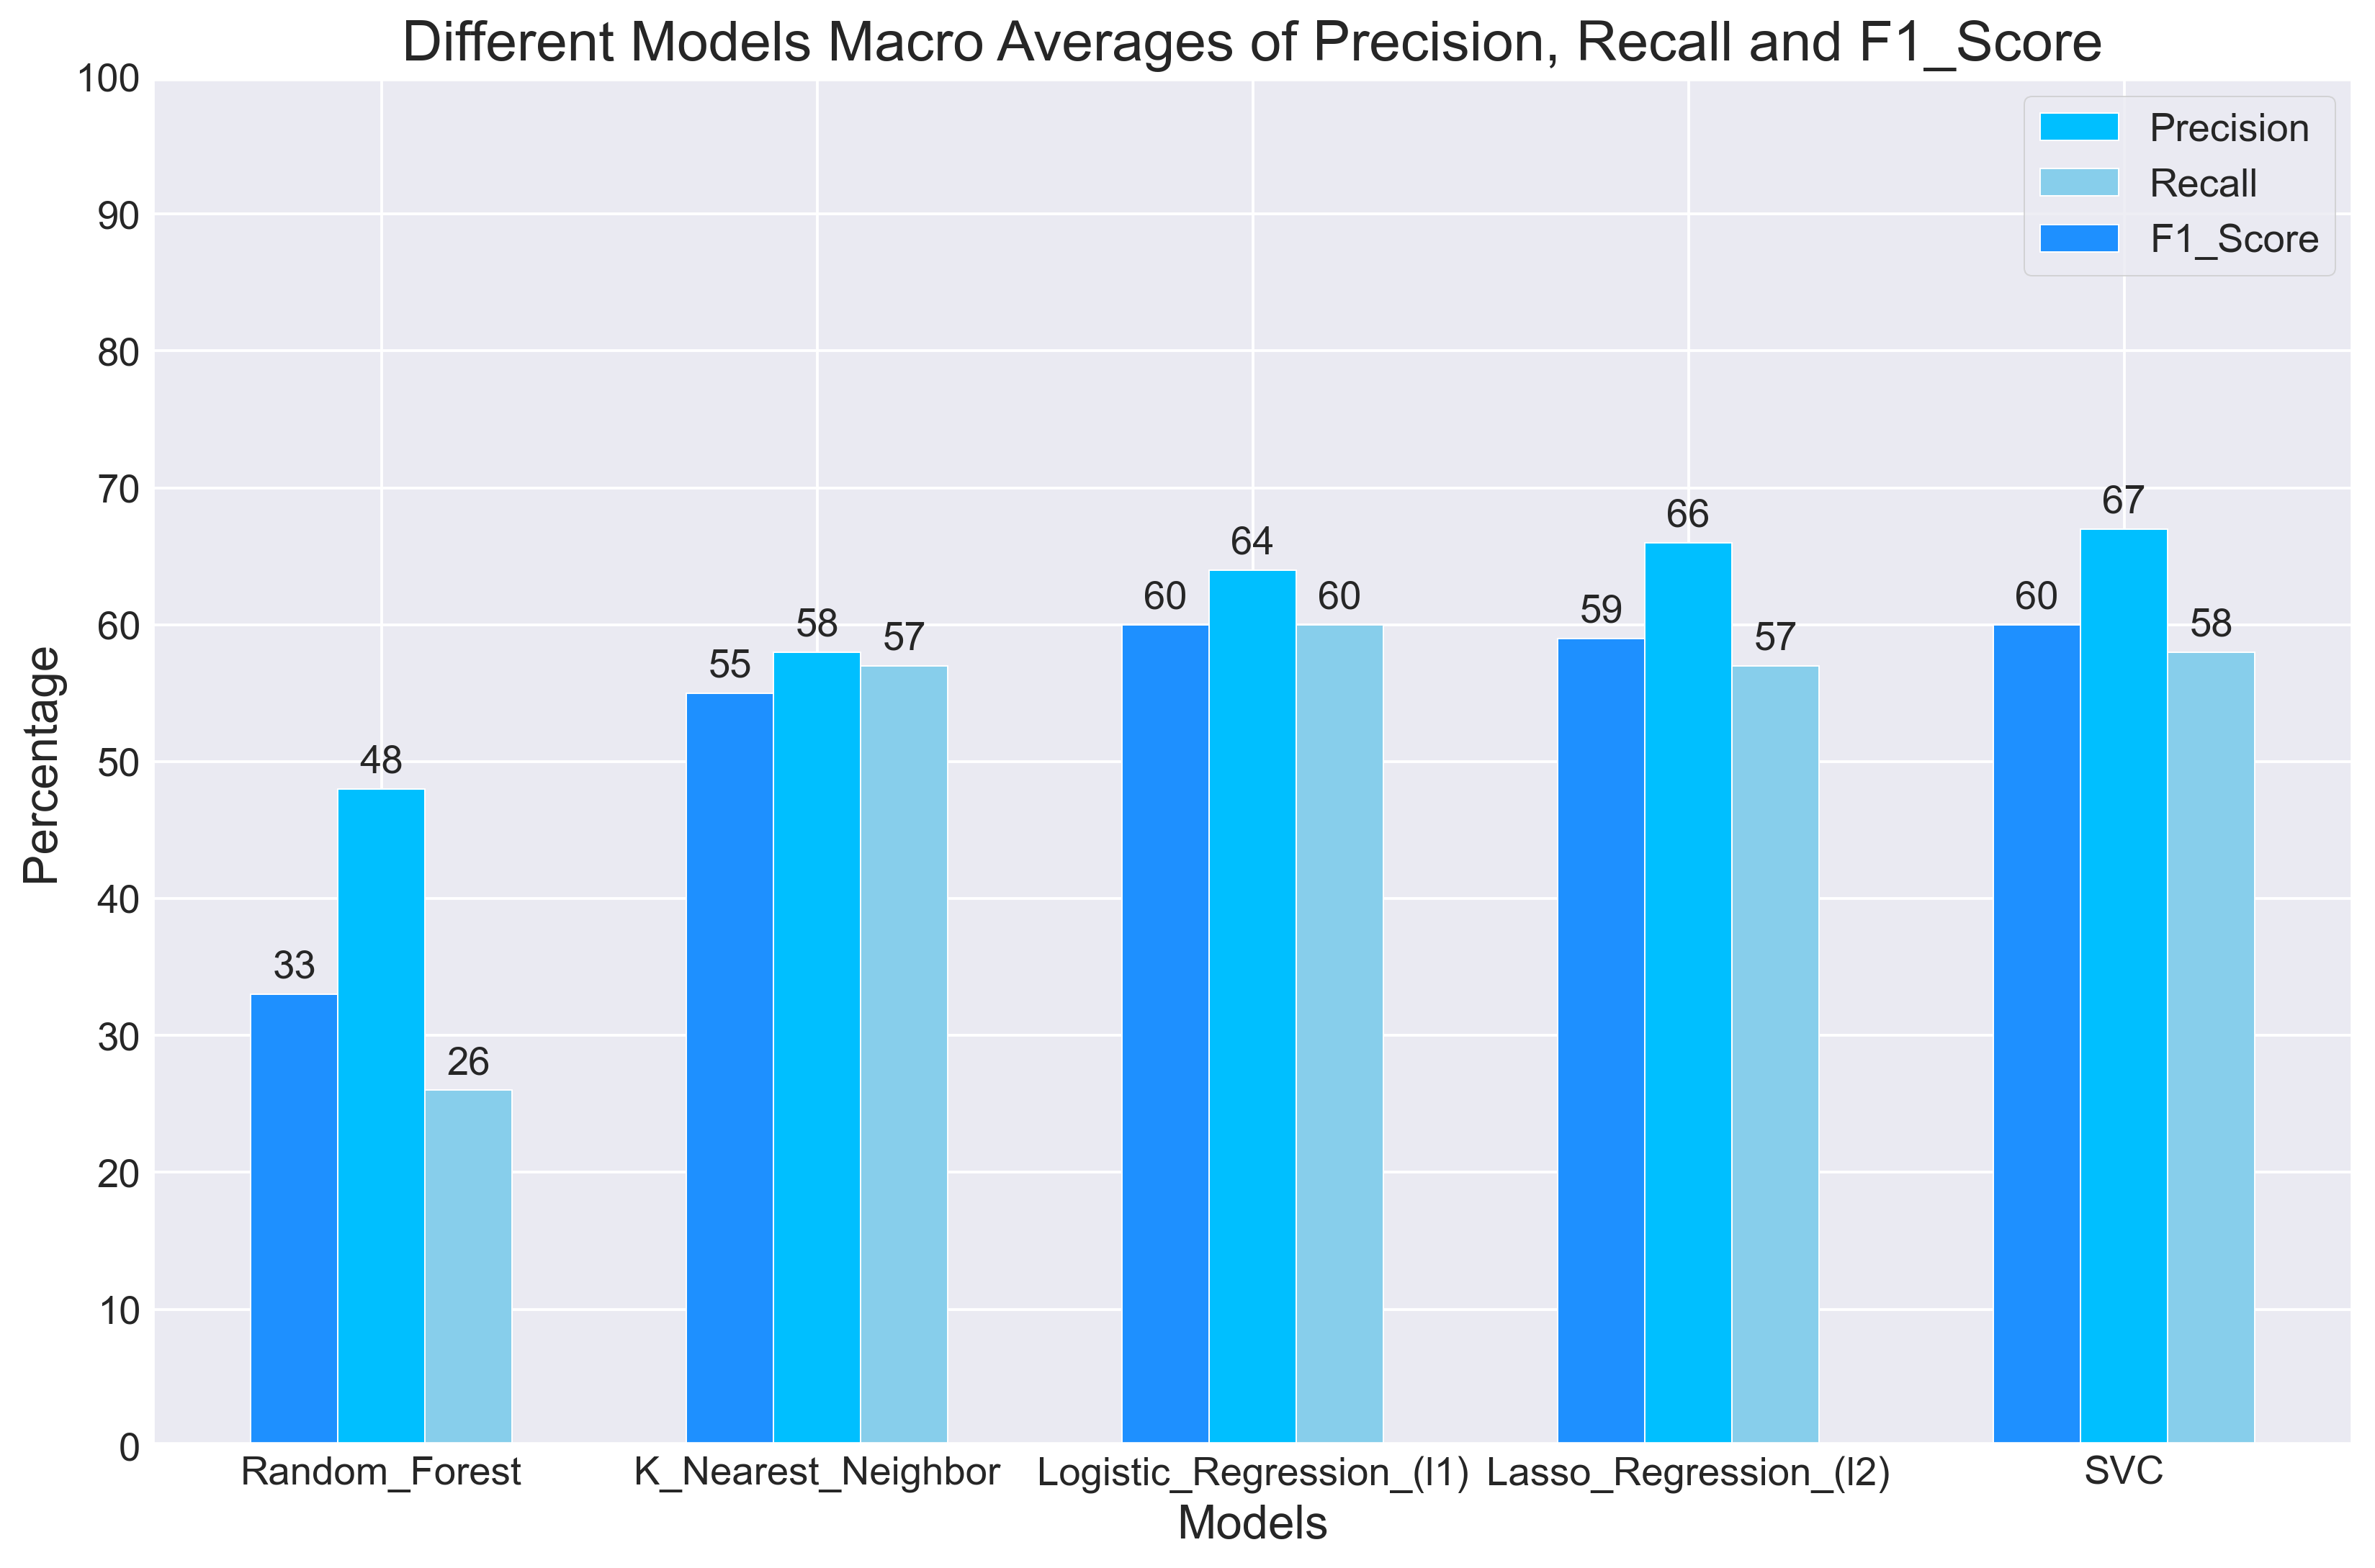

In [505]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Random_Forest','K_Nearest_Neighbor',
        'Logistic_Regression_(l1)','Lasso_Regression_(l2)','SVC']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Precision = [48,58,64,66,67]
Recall = [26, 57, 60, 57, 58]
F1_Score = [33,55,60,59,60]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 280)
Precision_1 = ax.bar(indx - bar_width+0.4/2, Precision, bar_width, label='Precision',color = 'deepskyblue')
Recall_1 = ax.bar(indx + bar_width * 2/2, Recall, bar_width, label='Recall',color = 'skyblue')
F1_Score_1 = ax.bar(indx - bar_width * 2/2, F1_Score, bar_width, label='F1_Score',color = 'dodgerblue')


# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Percentage')
ax.set_xlabel('Models')
ax.set_title('Different Models Macro Averages of Precision, Recall and F1_Score')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Precision_1)
insert_data_labels(Recall_1)
insert_data_labels(F1_Score_1)
plt.tight_layout()
plt.show()

### Plotting All Models - Weighted Averages of Precision, Recall and F1_Score

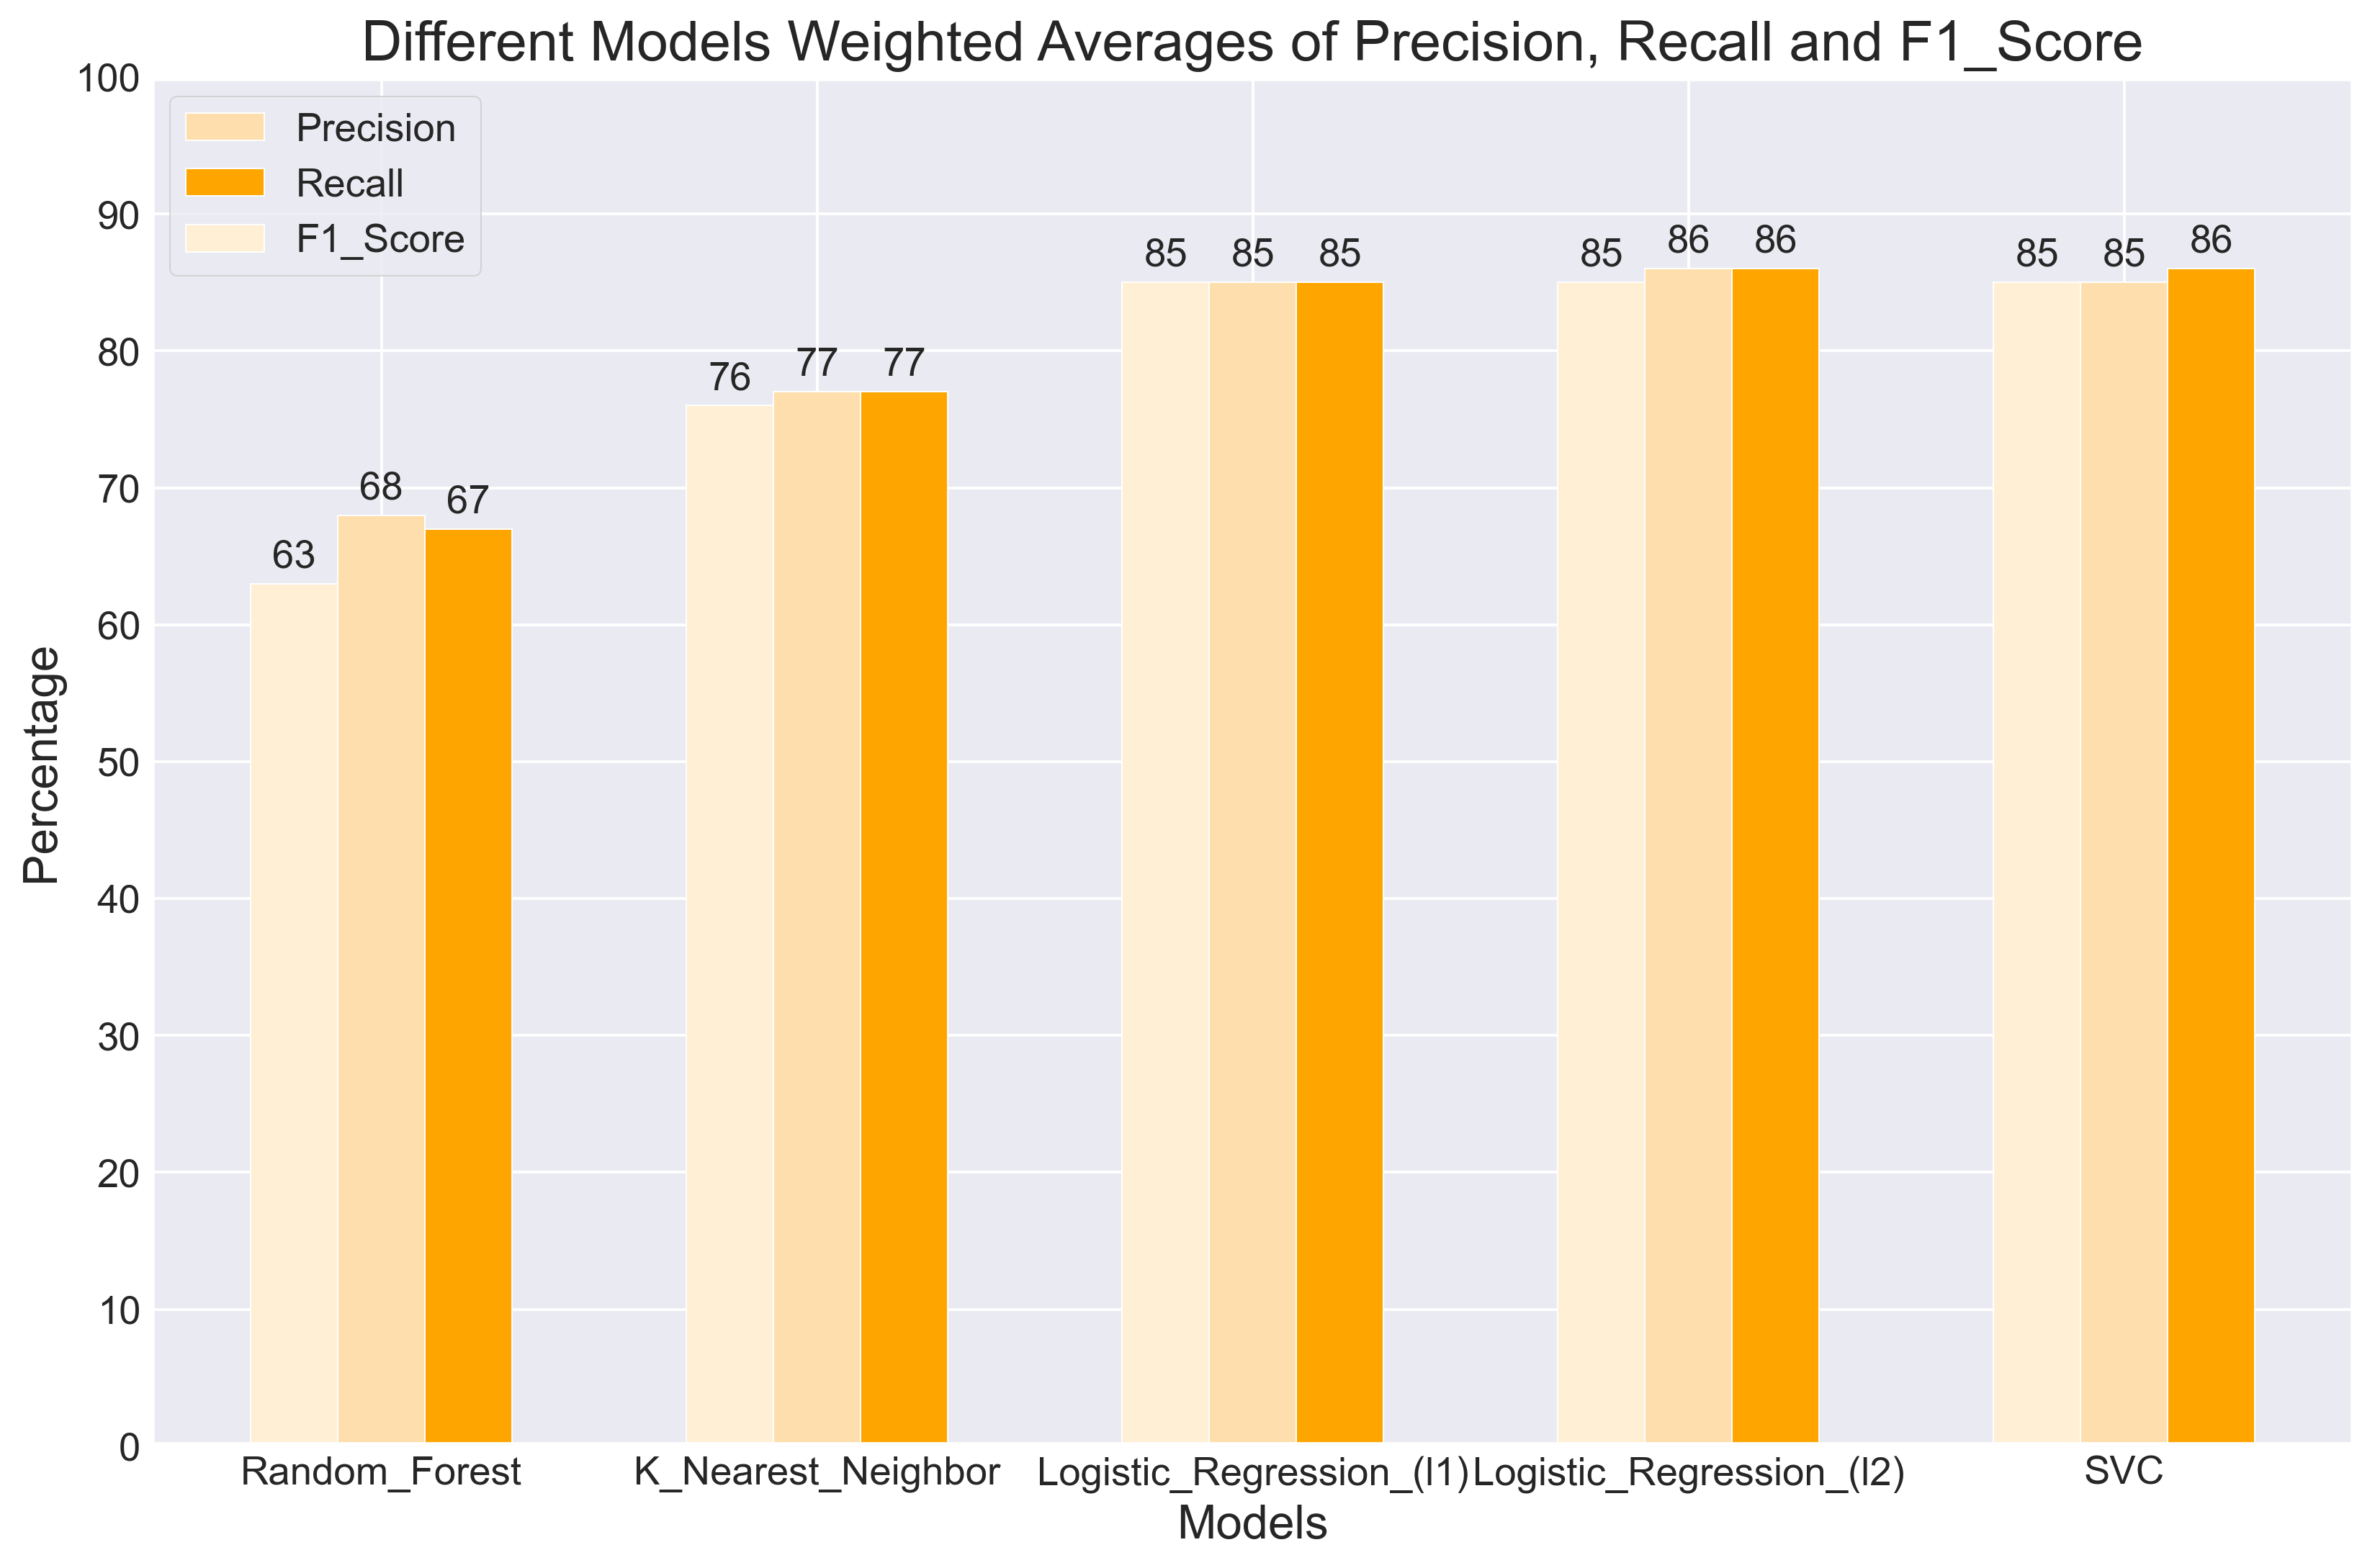

In [525]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#figure(num=None, figsize=(18, 10),dpi=500)

Labels=['Random_Forest','K_Nearest_Neighbor',
        'Logistic_Regression_(l1)','Logistic_Regression_(l2)','SVC']


indx = np.arange(len(Labels))
score_label = np.arange(0, 110, 10)
Precision = [68, 77, 85, 86, 85]
Recall = [67, 77, 85, 86, 86]
F1_Score = [63, 76, 85, 85, 85]

bar_width = 0.2

fig, ax = plt.subplots(1,1, figsize = (12, 8),dpi= 280)
Precision_1 = ax.bar(indx - bar_width+0.4/2, Precision, bar_width, label='Precision',color = 'navajowhite')
Recall_1 = ax.bar(indx + bar_width * 2/2, Recall, bar_width, label='Recall',color = 'orange')
F1_Score_1 = ax.bar(indx - bar_width * 2/2, F1_Score, bar_width, label='F1_Score',color = 'papayawhip')


# inserting x axis label

ax.set_xticks(indx)
ax.set_xticklabels(Labels)

# inserting y axis label

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.set_ylabel('Percentage')
ax.set_xlabel('Models')
ax.set_title('Different Models Weighted Averages of Precision, Recall and F1_Score')

# inserting legend
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(round(bar.get_height())),xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),textcoords='offset points',ha='center',
            va='bottom'
        )

insert_data_labels(Precision_1)
insert_data_labels(Recall_1)
insert_data_labels(F1_Score_1)
plt.tight_layout()
plt.show()